In [3]:
import os
import numpy as np
import rasterio
from sklearn.model_selection import train_test_split
from rasterio.transform import from_origin
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
import torch
from torch_geometric.data import Data
from tqdm import tqdm
import torch.nn.functional as F
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GATConv
import torch.nn as nn
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [18]:
# Path to your dataset folder
dataset_path = r"E:\patches_all_split\part1"

def load_tiles(folder, clip_max=50):
    X = []
    Y = []

    for tile in os.listdir(folder):
        tile_path = os.path.join(folder, tile)
        if not os.path.isdir(tile_path):
            continue
        try:
            # Load rasters
            dsm_path = os.path.join(tile_path, "dsm.tif")
            cdsm_path = os.path.join(tile_path, "cdsm.tif")
            svf_path = os.path.join(tile_path, "svf.tif")

            if not (os.path.exists(dsm_path) and os.path.exists(cdsm_path) and os.path.exists(svf_path)):
                continue

            dsm = rasterio.open(dsm_path).read(1).astype(np.float32)
            cdsm = rasterio.open(cdsm_path).read(1).astype(np.float32)
            svf = rasterio.open(svf_path).read(1).astype(np.float32)

            # Replace NaNs
            dsm = np.nan_to_num(dsm, nan=0.0)
            cdsm = np.nan_to_num(cdsm, nan=0.0)
            svf = np.nan_to_num(svf, nan=0.0)

            # Optional: Clip extreme values (e.g. buildings taller than 50m)
            dsm = np.clip(dsm, 0, clip_max)
            cdsm = np.clip(cdsm, 0, clip_max)

            # Normalize to [0, 1]
            dsm_max = np.max(dsm)
            cdsm_max = np.max(cdsm)

            dsm = dsm / dsm_max if dsm_max > 0 else np.zeros_like(dsm)
            cdsm = cdsm / cdsm_max if cdsm_max > 0 else np.zeros_like(cdsm)

            # Normalize SVF to [0, 1] if not already
            svf = np.clip(svf, 0, 1)

            # Stack inputs and outputs
            input_stack = np.stack([dsm, cdsm], axis=-1)      # (128, 128, 2)
            svf_target = svf[..., np.newaxis]                 # (128, 128, 1)

            X.append(input_stack)
            Y.append(svf_target)

        except Exception as e:
            print(f"Skipping tile {tile}: {e}")

    X = np.array(X)
    Y = np.array(Y)
    print(f"Loaded {len(X)} valid tiles.")
    return X, Y

# Load data
X, Y = load_tiles(dataset_path)

# Split into training and validation
#X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.1, random_state=42)

# Split into train+val and test first
X_temp, X_test, Y_temp, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Then split train+val further into train and val
X_train, X_val, Y_train, Y_val = train_test_split(X_temp, Y_temp, test_size=0.1, random_state=42)

Loaded 3708 valid tiles.


In [22]:
print("Dataset split:")
print(f"Train set:      {X_train.shape[0]} tiles")
print(f"Validation set: {X_val.shape[0]} tiles")
print(f"Test set:       {X_test.shape[0]} tiles")

Dataset split:
Train set:      2669 tiles
Validation set: 297 tiles
Test set:       742 tiles


In [23]:
def build_svf_cnn(input_shape=(128, 128, 2)):
    inputs = layers.Input(shape=input_shape)

    # Encoder
    x = layers.Conv2D(32, 3, activation='relu', padding='same')(inputs)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(64, 3, activation='relu', padding='same')(x)
    x = layers.MaxPooling2D()(x)

    # Bottleneck
    x = layers.Conv2D(128, 3, activation='relu', padding='same')(x)

    # Decoder
    x = layers.UpSampling2D()(x)
    x = layers.Conv2D(64, 3, activation='relu', padding='same')(x)
    x = layers.UpSampling2D()(x)
    x = layers.Conv2D(32, 3, activation='relu', padding='same')(x)

    # Output layer
    outputs = layers.Conv2D(1, 1, activation='sigmoid', padding='same')(x)

    model = models.Model(inputs, outputs)
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

In [27]:
svf_model = build_svf_cnn()

history = svf_model.fit(
    X_train, Y_train,
    validation_data=(X_val, Y_val),
    epochs=50,
    batch_size=16
)

Epoch 1/50
167/167 ━━━━━━━━━━━━━━━━━━━━ 92s 533ms/step - loss: 0.0252 - mae: 0.1084 - val_loss: 0.0153 - val_mae: 0.0848
Epoch 2/50
167/167 ━━━━━━━━━━━━━━━━━━━━ 86s 514ms/step - loss: 0.0127 - mae: 0.0749 - val_loss: 0.0105 - val_mae: 0.0689
Epoch 3/50
167/167 ━━━━━━━━━━━━━━━━━━━━ 87s 521ms/step - loss: 0.0105 - mae: 0.0675 - val_loss: 0.0096 - val_mae: 0.0683
Epoch 4/50
167/167 ━━━━━━━━━━━━━━━━━━━━ 89s 534ms/step - loss: 0.0094 - mae: 0.0637 - val_loss: 0.0082 - val_mae: 0.0578
Epoch 5/50
167/167 ━━━━━━━━━━━━━━━━━━━━ 117s 702ms/step - loss: 0.0084 - mae: 0.0597 - val_loss: 0.0081 - val_mae: 0.0623
Epoch 6/50
167/167 ━━━━━━━━━━━━━━━━━━━━ 124s 590ms/step - loss: 0.0082 - mae: 0.0593 - val_loss: 0.0075 - val_mae: 0.0551
Epoch 7/50
167/167 ━━━━━━━━━━━━━━━━━━━━ 87s 519ms/step - loss: 0.0076 - mae: 0.0566 - val_loss: 0.0070 - val_mae: 0.0549
Epoch 8/50
167/167 ━━━━━━━━━━━━━━━━━━━━ 94s 560ms/step - loss: 0.0073 - mae: 0.0558 - val_loss: 0.0069 - val_mae: 0.0524
Epoch 9/50
167/167 ━━━━━━━━━━━

In [30]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

def evaluate_model_on_test(model, X_test, Y_test):
    # Evaluate with Keras
    results = model.evaluate(X_test, Y_test, batch_size=32, verbose=0)
    
    # Predict
    predictions = model.predict(X_test, batch_size=32)

    # Flatten arrays for sklearn metrics
    y_true = Y_test.flatten()
    y_pred = predictions.flatten()

    # Metrics
    mae = np.mean(np.abs(y_true - y_pred))
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)

    # Print results
    print(f"Test Loss:    {results[0]:.4f}")
    print(f"Test MAE:     {results[1] if len(results) > 1 else 'N/A'}")
    print(f"Computed MAE: {mae:.4f}")
    print(f"RMSE:         {rmse:.4f}")
    print(f"R² Score:     {r2:.4f}")

    return {
        'loss': results[0],
        'mae': results[1] if len(results) > 1 else None,
        'computed_mae': mae,
        'rmse': rmse,
        'r2': r2
    }


In [31]:
evaluate_model_on_test(svf_model, X_test, Y_test)


24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 213ms/step
Test Loss:    0.0042
Test MAE:     0.043994609266519547
Computed MAE: 0.0440
RMSE:         0.0647
R² Score:     0.9612


{'loss': 0.004189102910459042,
 'mae': 0.043994609266519547,
 'computed_mae': np.float32(0.043994617),
 'rmse': np.float64(0.06472327231480549),
 'r2': 0.9612423777580261}

In [ ]:
"""def visualize_all_validation(X_val, Y_val, model, max_plots=None):
    preds = model.predict(X_val)

    n_samples = len(X_val) if max_plots is None else min(len(X_val), max_plots)

    for i in range(n_samples):
        gt = Y_val[i].squeeze()
        pred = preds[i].squeeze()
        error = np.abs(gt - pred)

        fig, axs = plt.subplots(1, 3, figsize=(15, 4))

        # Ground truth in greyscale
        im0 = axs[0].imshow(gt, cmap='gray', vmin=0, vmax=1)
        axs[0].set_title(f"Validation {i+1} - Expected SVF")

        # Prediction in greyscale
        im1 = axs[1].imshow(pred, cmap='gray', vmin=0, vmax=1)
        axs[1].set_title("Predicted SVF")

        # Error in 'hot' colormap with colorbar
        im2 = axs[2].imshow(error, cmap='hot')
        axs[2].set_title("Absolute Error")
        cbar = fig.colorbar(im2, ax=axs[2], fraction=0.046, pad=0.04)
        cbar.set_label("Error Magnitude")

        for ax in axs:
            ax.axis('off')

        plt.tight_layout()
        plt.show()

visualize_all_validation(X_val, Y_val, svf_model, max_plots=10)"""

In [ ]:
"""def visualize_test_predictions_cnn(model, X_test, Y_test, n=5):
    preds = model.predict(X_test)

    for i in range(n):
        pred = preds[i].squeeze()
        true = Y_test[i].squeeze()
        error = np.abs(pred - true)

        # Per-image metrics
        mae = np.mean(error)
        rmse = np.sqrt(np.mean((pred - true) ** 2))

        # Title string with metrics
        title = f"Sample #{i} | MAE: {mae:.4f}, RMSE: {rmse:.4f}"

        # Create figure and axes
        fig, axs = plt.subplots(1, 3, figsize=(15, 5), constrained_layout=True)
        fig.suptitle(title, fontsize=14, weight='bold')

        axs[0].imshow(true, cmap='gray', vmin=0, vmax=1)
        axs[0].set_title("Calculated SVF")

        axs[1].imshow(pred, cmap='gray', vmin=0, vmax=1)
        axs[1].set_title("Predicted SVF")

        im2 = axs[2].imshow(error, cmap='hot', vmin=0, vmax=1)
        axs[2].set_title("Absolute Error")

        # Colorbar for error map
        cbar = fig.colorbar(im2, ax=axs[2], fraction=0.046, pad=0.04)
        cbar.set_label("Error Magnitude")

        for ax in axs:
            ax.axis('off')

        plt.show()

visualize_test_predictions_cnn(svf_model, X_test, Y_test, n=5)"""

In [ ]:
"""visualize_test_predictions_cnn(svf_model, X_test, Y_test, n=5)"""

24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 198ms/step


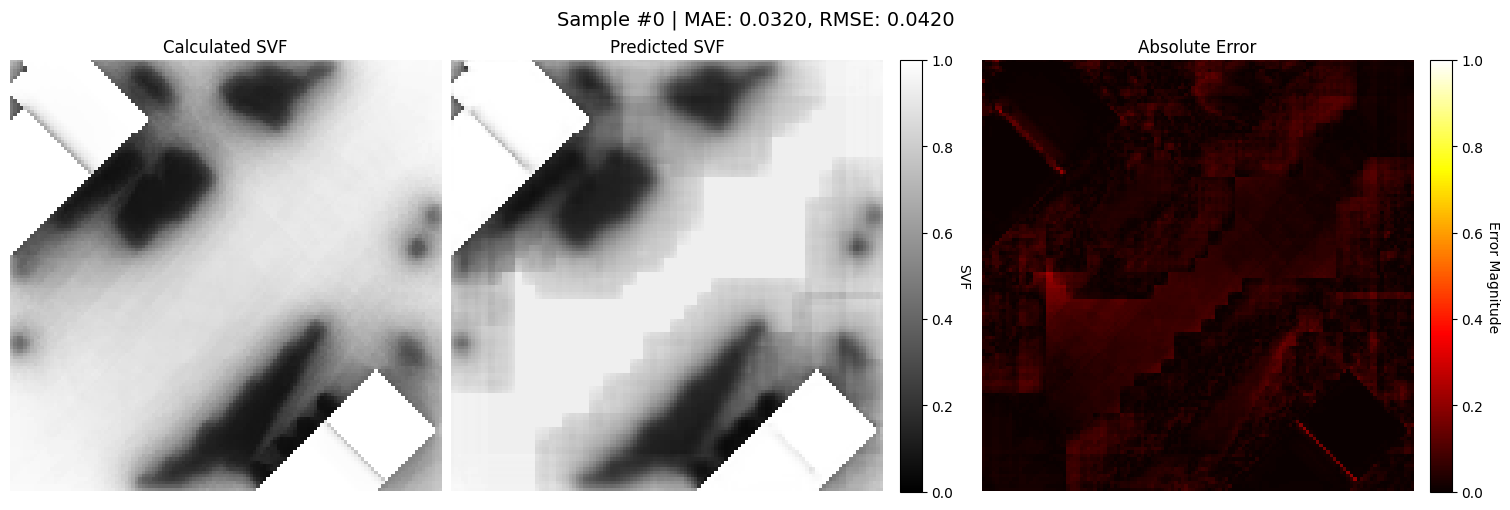

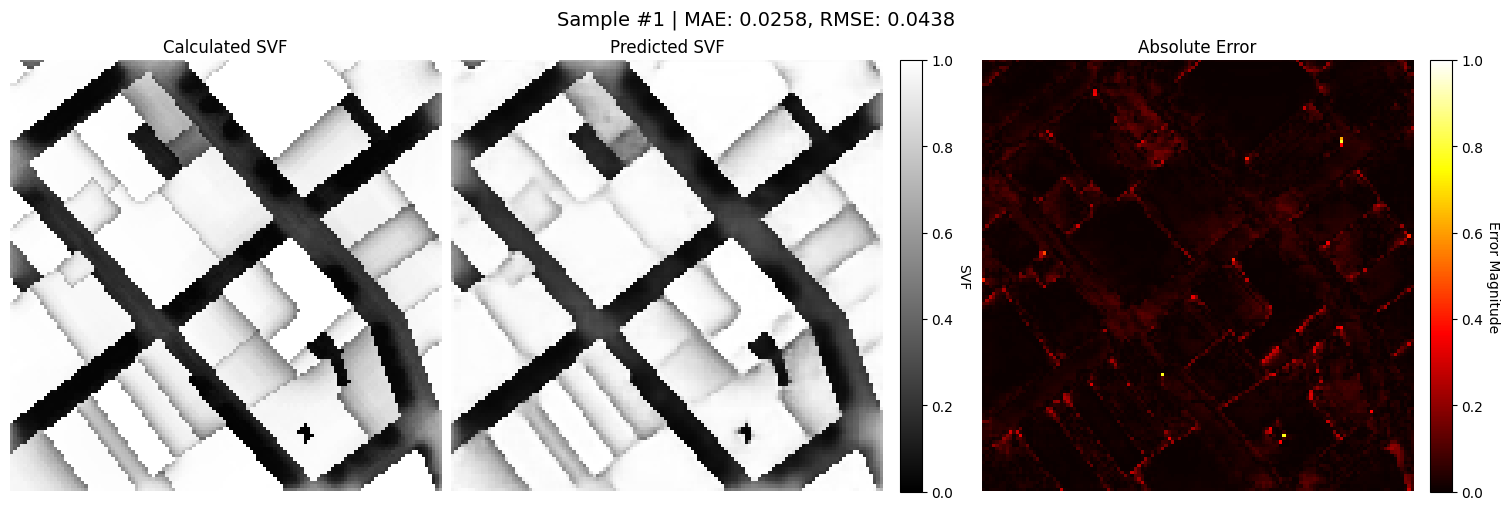

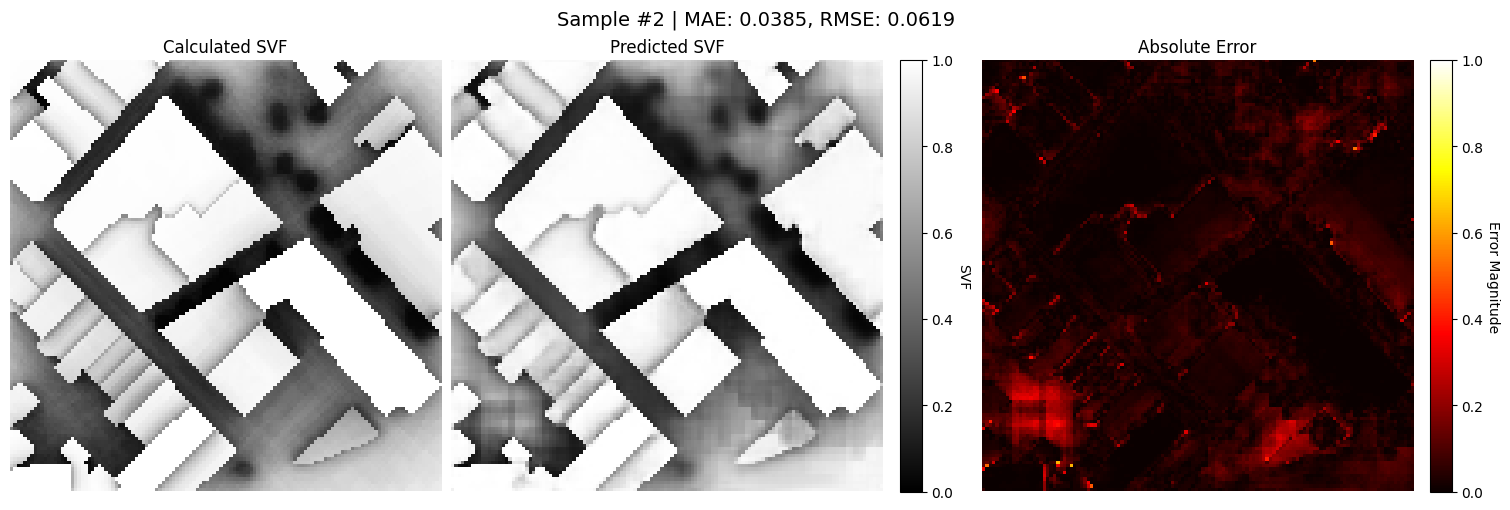

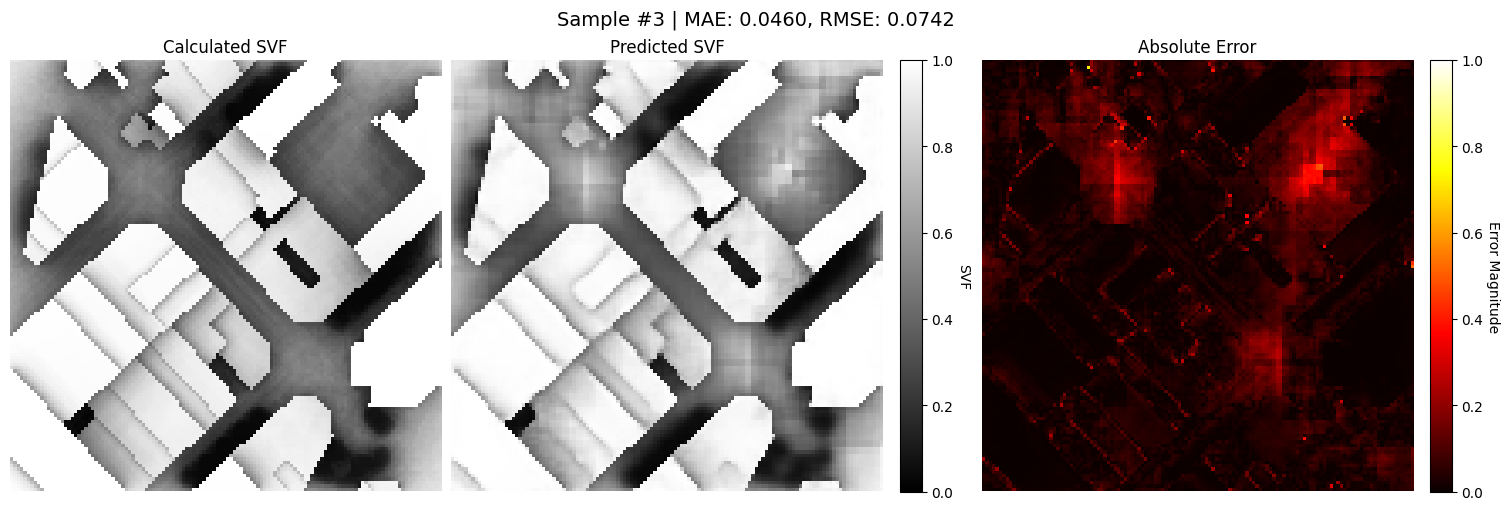

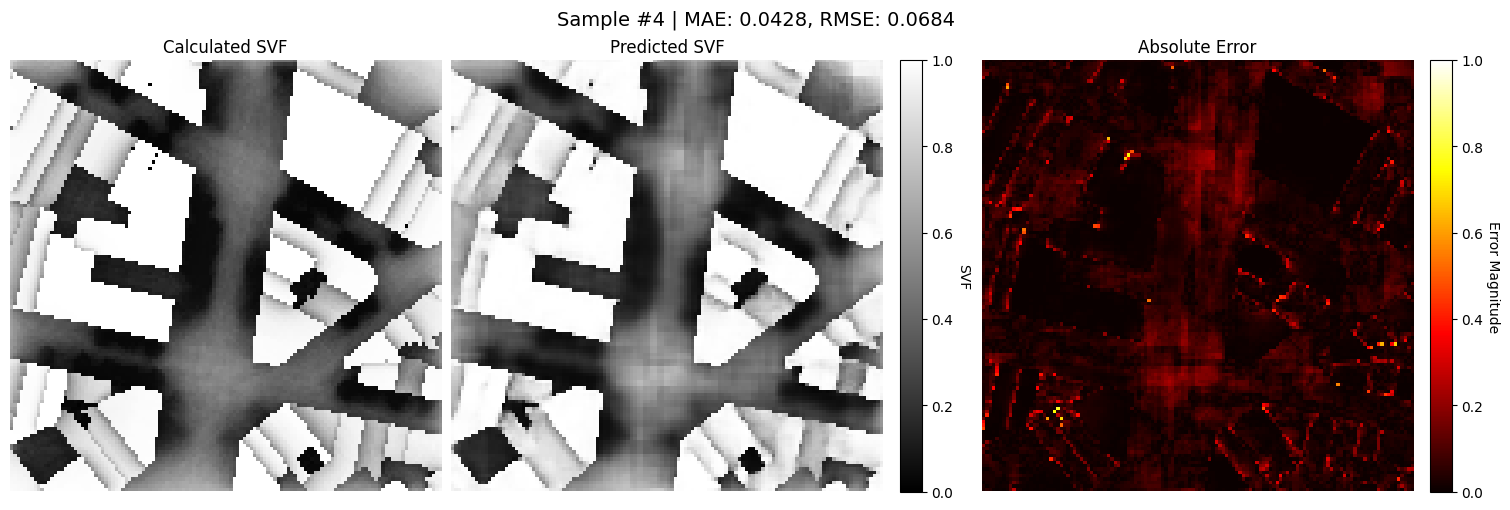

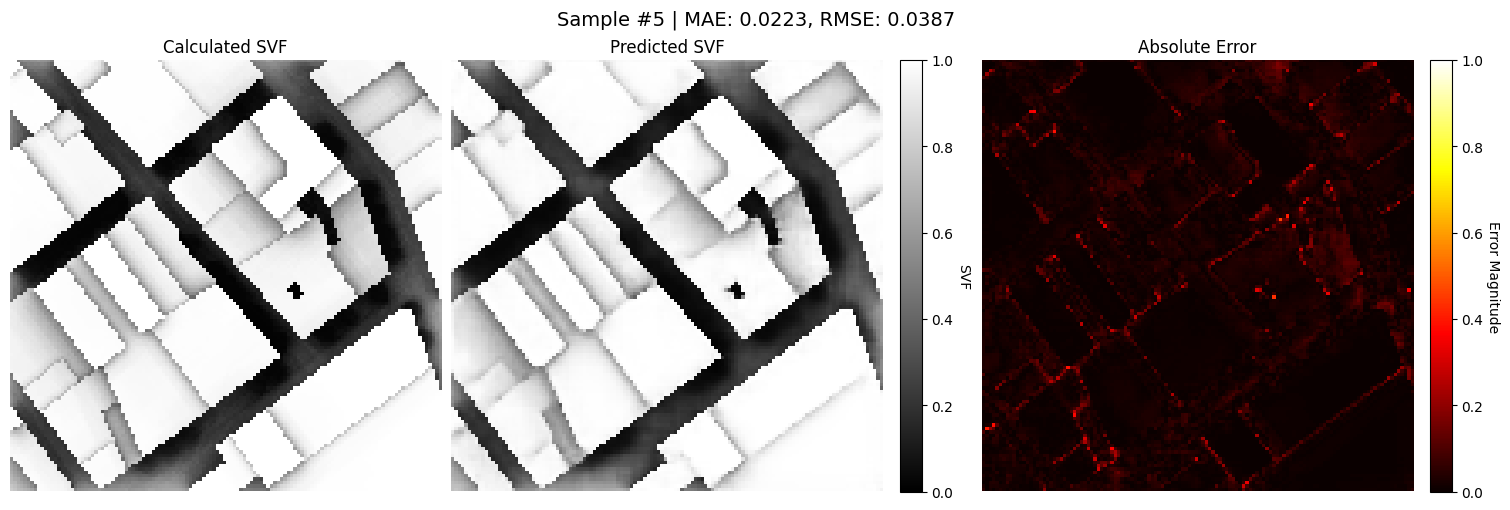

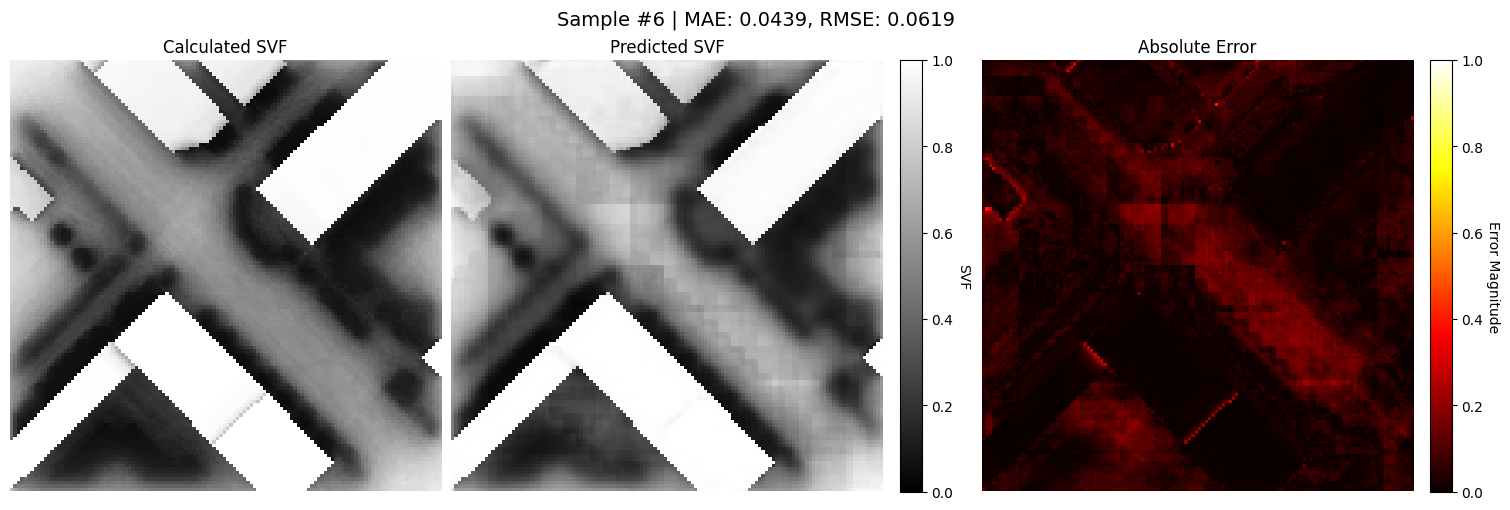

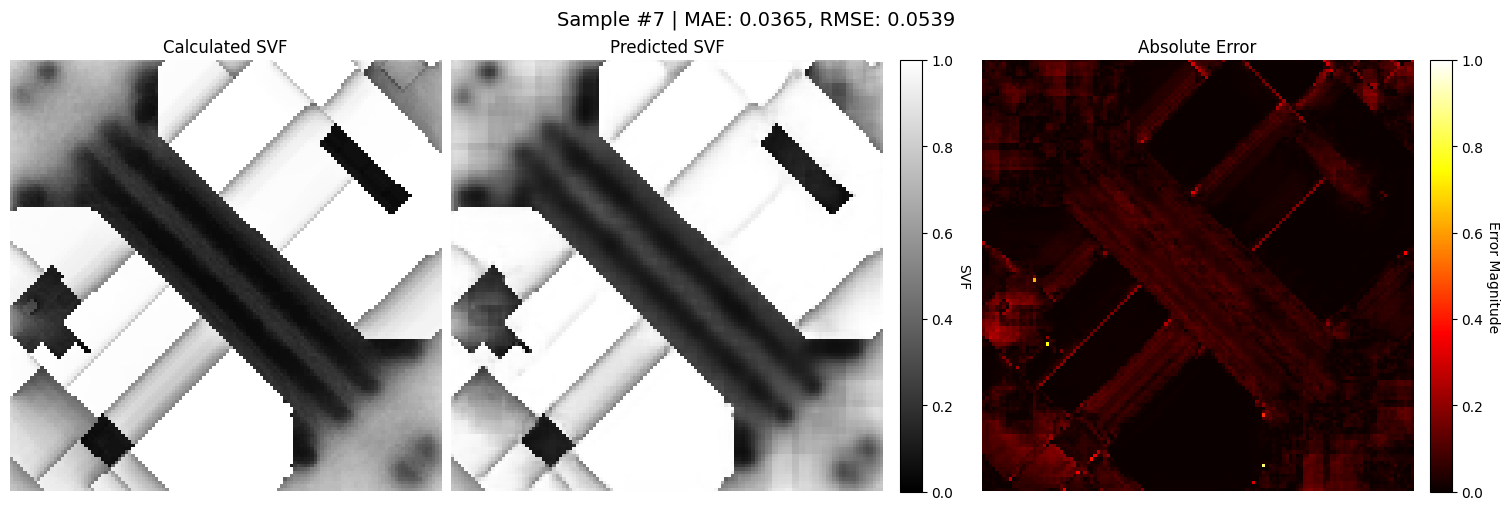

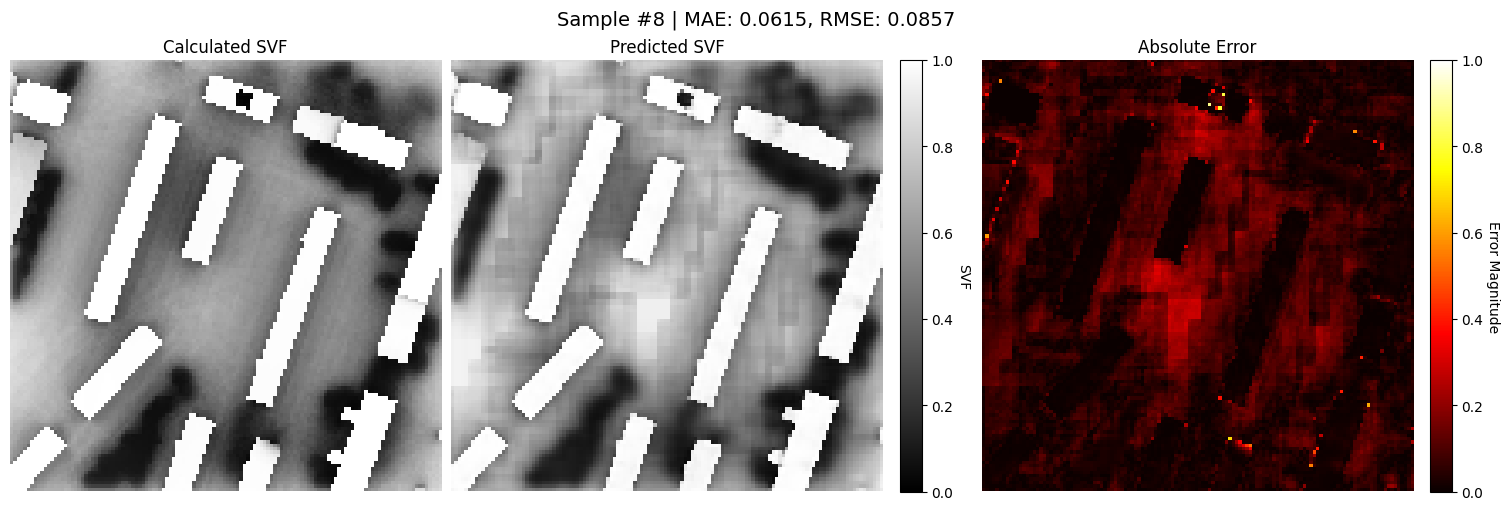

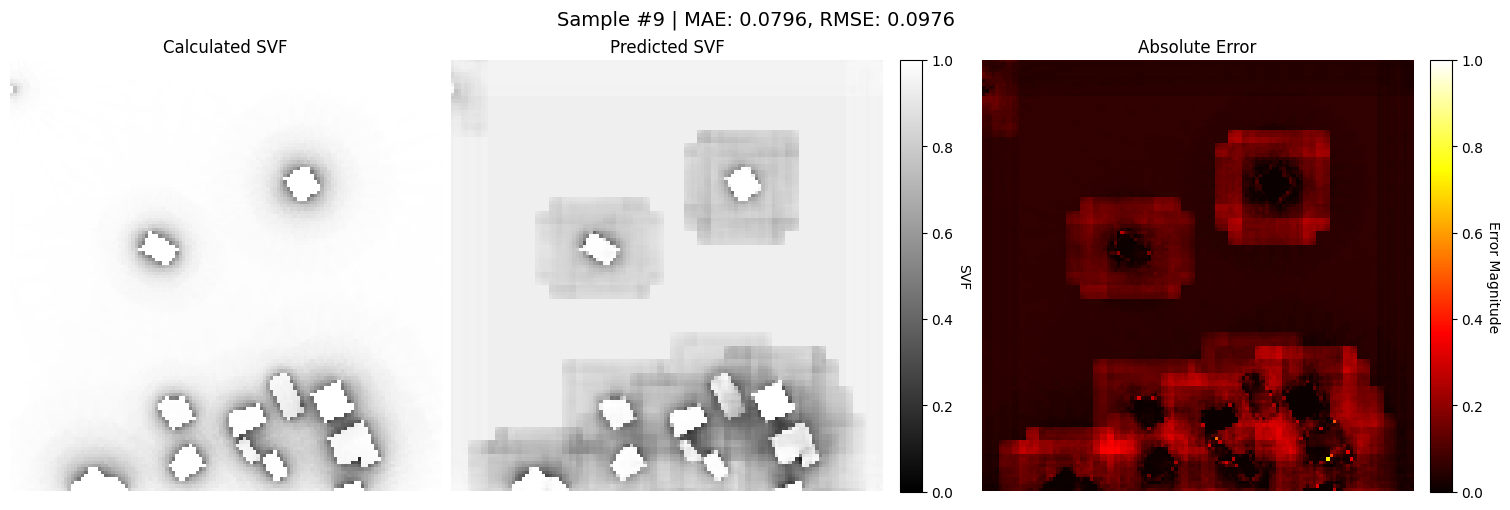

In [131]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_test_predictions_cnn(model, X_test, Y_test, n=10):
    preds = model.predict(X_test)

    for i in range(n):
        pred = preds[i].squeeze()
        true = Y_test[i].squeeze()
        error = np.abs(pred - true)

        # Per-image metrics
        mae = np.mean(error)
        rmse = np.sqrt(np.mean((pred - true) ** 2))

        # Title string with metrics
        title = f"Sample #{i} | MAE: {mae:.4f}, RMSE: {rmse:.4f}"

        # Create figure and axes
        fig, axs = plt.subplots(1, 3, figsize=(15, 5), constrained_layout=True)
        fig.suptitle(title, fontsize=14, weight='normal')

        axs[0].imshow(true, cmap='gray', vmin=0, vmax=1)
        axs[0].set_title("Calculated SVF")

        im1 = axs[1].imshow(pred, cmap='gray', vmin=0, vmax=1)
        axs[1].set_title("Predicted SVF")

        im2 = axs[2].imshow(error, cmap='hot', vmin=0, vmax=1)
        axs[2].set_title("Absolute Error")

        # Colorbar for SVF prediction
        cbar1 = fig.colorbar(im1, ax=axs[1], fraction=0.05, pad=0.04)
        cbar1.set_label("SVF", rotation=270, labelpad=12)

        # Colorbar for error map
        cbar2 = fig.colorbar(im2, ax=axs[2], fraction=0.05, pad=0.04)
        cbar2.set_label("Error Magnitude", rotation=270, labelpad=12)

        for ax in axs:
            ax.axis('off')

        plt.show()

# Usage
visualize_test_predictions_cnn(svf_model, X_test, Y_test, n=10)


Summary
Metric	Description	Good Value
MAE	Avg. absolute error (pixelwise)	→ 0
RMSE	Root mean squared error	→ 0
SSIM	Structural similarity	→ 1
PSNR	Signal-to-noise ratio	↑ dB

✅ 1. Add SSIM/PSNR Per Image

These metrics complement MAE/RMSE by capturing perceptual or structural similarity between the prediction and ground truth:

🔍 SSIM (Structural Similarity Index)

Measures luminance, contrast, and structure similarity.

Range: [-1, 1], where 1 is perfect.

More aligned with how humans perceive quality.

🔍 PSNR (Peak Signal-to-Noise Ratio)

Based on the logarithmic ratio of signal vs. error.

Higher is better. Typically:

>30 dB: Good

20–30 dB: Acceptable

<20 dB: Poor

In [ ]:
"""from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr

def visualize_test_predictions_cnn(model, X_test, Y_test, n=5):
    preds = model.predict(X_test)

    for i in range(n):
        pred = preds[i].squeeze()
        true = Y_test[i].squeeze()
        error = np.abs(pred - true)

        # Per-image metrics
        mae = np.mean(error)
        rmse = np.sqrt(np.mean((pred - true) ** 2))
        ssim_score = ssim(true, pred, data_range=1.0)
        psnr_score = psnr(true, pred, data_range=1.0)

        # Title string
        title = (f"Sample #{i} | MAE: {mae:.4f}, RMSE: {rmse:.4f}, "
                 f"SSIM: {ssim_score:.4f}, PSNR: {psnr_score:.2f} dB")

        # Create figure
        fig, axs = plt.subplots(1, 3, figsize=(15, 5), constrained_layout=True)
        fig.suptitle(title, fontsize=14, weight='bold')

        axs[0].imshow(true, cmap='gray', vmin=0, vmax=1)
        axs[0].set_title("Expected SVF")

        axs[1].imshow(pred, cmap='gray', vmin=0, vmax=1)
        axs[1].set_title("Predicted SVF")

        im2 = axs[2].imshow(error, cmap='hot', vmin=0, vmax=1)
        axs[2].set_title("Absolute Error")

        # Colorbar
        cbar = fig.colorbar(im2, ax=axs[2], fraction=0.046, pad=0.04)
        cbar.set_label("Error Magnitude")

        for ax in axs:
            ax.axis('off')

        plt.show()"""


In [ ]:
"""def compute_global_metrics(model, X_test, Y_test):
    preds = model.predict(X_test)

    y_true_flat = Y_test.reshape(-1)
    y_pred_flat = preds.reshape(-1)

    # Pixel-wise metrics
    # Pixel-wise metrics
    mae = mean_absolute_error(y_true_flat, y_pred_flat)
    rmse = np.sqrt(mean_squared_error(y_true_flat, y_pred_flat))  # Fixed line



    # Image-wise SSIM/PSNR
    ssim_scores = []
    psnr_scores = []

    for i in range(Y_test.shape[0]):
        true = Y_test[i].squeeze()
        pred = preds[i].squeeze()
        ssim_scores.append(ssim(true, pred, data_range=1.0))
        psnr_scores.append(psnr(true, pred, data_range=1.0))

    mean_ssim = np.mean(ssim_scores)
    mean_psnr = np.mean(psnr_scores)

    print(" Global Test Metrics Summary:")
    print(f"MAE:  {mae:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"SSIM: {mean_ssim:.4f}")
    print(f"PSNR: {mean_psnr:.2f} dB")
"""

In [ ]:
"""# Show sample predictions with metrics
visualize_test_predictions_cnn(svf_model, X_test, Y_test, n=5)

# Show global metrics below
compute_global_metrics(svf_model, X_test, Y_test)"""


In [10]:
# Save in legacy HDF5 format
svf_model.save("C:/Users/Ardo/Desktop/trained_models/cnn_svf_model_new.h5")

In [ ]:
"""import os
import numpy as np
import rasterio
import matplotlib.pyplot as plt

from tensorflow.keras.models import load_model

# Load trained model
model_path = r"C:\Users\Ardo\Desktop\trained_models\cnn_svf_model.h5"
svf_model = load_model("cnn_svf_model.h5", compile=False)


# Folder with new unseen tiles
new_tiles_folder = r"C:\Users\Ardo\Desktop\patch_combined_red"

# Prediction output folder
output_folder = os.path.join(new_tiles_folder, "predicted_svf_outputs")
os.makedirs(output_folder, exist_ok=True)

def load_input_from_tile(tile_path, clip_max=50):
    try:
        dsm = rasterio.open(os.path.join(tile_path, "dsm.tif")).read(1).astype(np.float32)
        cdsm = rasterio.open(os.path.join(tile_path, "cdsm.tif")).read(1).astype(np.float32)

        dsm = np.nan_to_num(np.clip(dsm, 0, clip_max))
        cdsm = np.nan_to_num(np.clip(cdsm, 0, clip_max))

        dsm /= np.max(dsm) if np.max(dsm) > 0 else 1
        cdsm /= np.max(cdsm) if np.max(cdsm) > 0 else 1

        input_stack = np.stack([dsm, cdsm], axis=-1)  # (H, W, 2)
        return input_stack[np.newaxis, ...], dsm.shape  # Add batch dimension

    except Exception as e:
        print(f" Error loading tile {tile_path}: {e}")
        return None, None

def save_svf_prediction(pred, tile_path, shape):
    tile_name = os.path.basename(tile_path)
    svf_pred = pred.squeeze()  # Remove batch and channel dims

    # Save as PNG
    plt.imsave(os.path.join(output_folder, f"{tile_name}_predicted_svf.png"), svf_pred, cmap='gray', vmin=0, vmax=1)

    # Save as GeoTIFF
    dsm_path = os.path.join(tile_path, "dsm.tif")
    with rasterio.open(dsm_path) as src:
        profile = src.profile

    profile.update(dtype=rasterio.float32, count=1)

    with rasterio.open(os.path.join(output_folder, f"{tile_name}_predicted_svf.tif"), 'w', **profile) as dst:
        dst.write(svf_pred.astype(np.float32), 1)

# Loop over each tile folder and predict
for tile in os.listdir(new_tiles_folder):
    tile_path = os.path.join(new_tiles_folder, tile)
    if not os.path.isdir(tile_path):
        continue

    input_tensor, shape = load_input_from_tile(tile_path)
    if input_tensor is None:
        continue

    pred = svf_model.predict(input_tensor)
    save_svf_prediction(pred, tile_path, shape)

print(" All SVF predictions saved.")"""


In [ ]:
"""import matplotlib.pyplot as plt

def plot_training_history(history):
    plt.figure(figsize=(12, 5))

    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title("MSE Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    # MAE plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['mae'], label='Train MAE')
    plt.plot(history.history['val_mae'], label='Val MAE')
    plt.title("Mean Absolute Error")
    plt.xlabel("Epoch")
    plt.ylabel("MAE")
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_training_history(history)"""


C:\Users\Ardo\AppData\Local\Temp\ipykernel_11108\3273590405.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap("viridis")


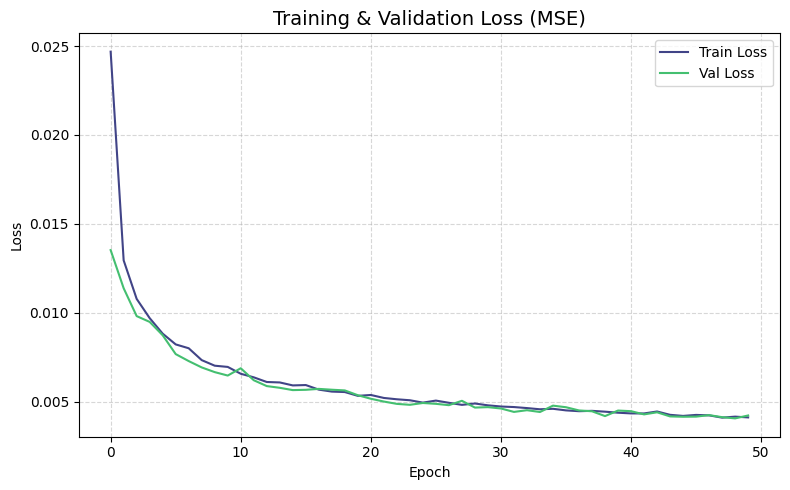

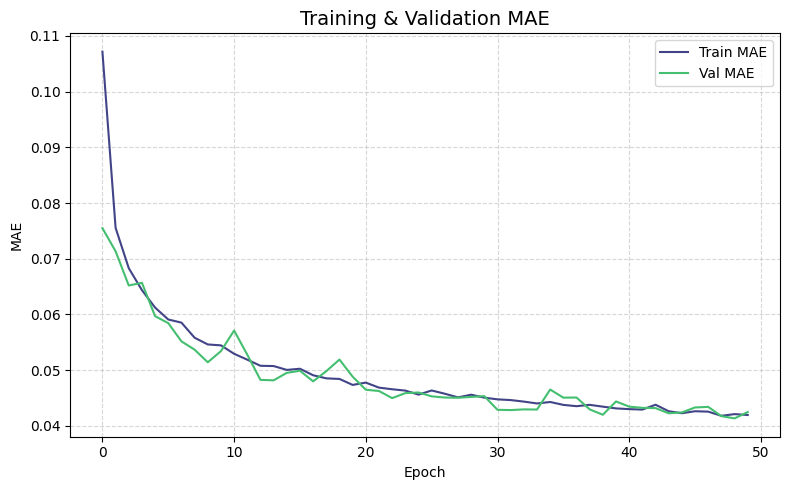

In [11]:
from matplotlib.cm import get_cmap


def plot_training_history(history):
    cmap = get_cmap("viridis")

    # -------- LOSS PLOT --------
    plt.figure(figsize=(8, 5))
    plt.plot(history.history.get('loss', []), label='Train Loss', color=cmap(0.2))
    plt.plot(history.history.get('val_loss', []), label='Val Loss', color=cmap(0.7))
    plt.title("Training & Validation Loss (MSE)", fontsize=14)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # -------- MAE PLOT --------
    plt.figure(figsize=(8, 5))
    plt.plot(history.history.get('mae', []), label='Train MAE', color=cmap(0.2))
    plt.plot(history.history.get('val_mae', []), label='Val MAE', color=cmap(0.7))
    plt.title("Training & Validation MAE", fontsize=14)
    plt.xlabel("Epoch")
    plt.ylabel("MAE")
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_training_history(history)

10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 203ms/step


C:\Users\Ardo\AppData\Local\Temp\ipykernel_11108\3092372602.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap("viridis")


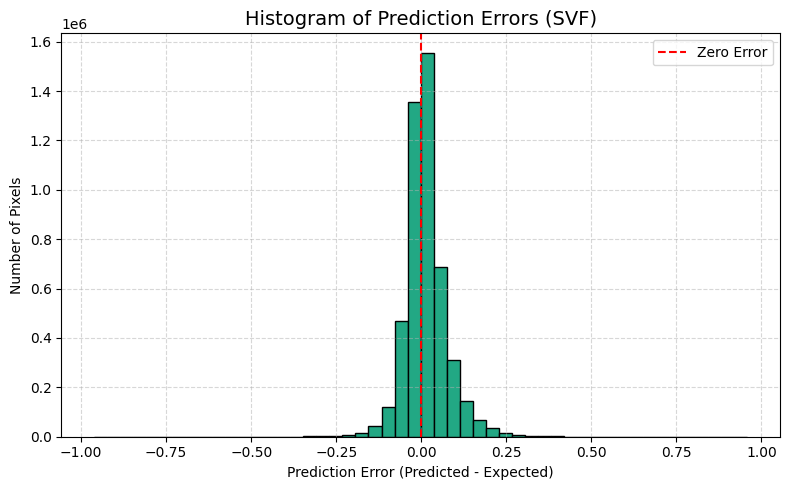

In [12]:
from matplotlib.cm import get_cmap


def plot_error_histogram(X_val, Y_val, model, bins=50, clip_range=(-1, 1)):
    # Predict
    preds = model.predict(X_val)

    # Flatten
    y_true = Y_val.flatten()
    y_pred = preds.flatten()

    # Compute errors and clip
    errors = np.clip(y_pred - y_true, clip_range[0], clip_range[1])

    # Get color from viridis colormap
    cmap = get_cmap("viridis")
    color = cmap(0.6)  # middle shade

    # Plot
    plt.figure(figsize=(8, 5))
    plt.hist(errors, bins=bins, color=color, edgecolor='black')
    plt.title("Histogram of Prediction Errors (SVF)", fontsize=14)
    plt.xlabel("Prediction Error (Predicted - Expected)")
    plt.ylabel("Number of Pixels")
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.axvline(x=0, color='red', linestyle='--', label='Zero Error')
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_error_histogram(X_val, Y_val, svf_model)

10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 212ms/step


C:\Users\Ardo\AppData\Local\Temp\ipykernel_11108\3837288442.py:24: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap("viridis")


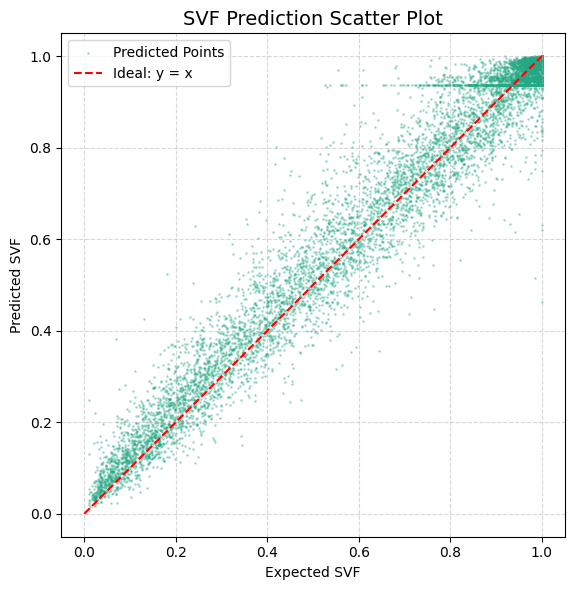

In [13]:
from matplotlib.cm import get_cmap


def plot_svf_scatter(X_val, Y_val, model, sample_size=10000):
    # Predict
    preds = model.predict(X_val)

    # Flatten predictions and ground truth
    y_true = Y_val.flatten()
    y_pred = preds.flatten()

    # Remove NaNs/Infs
    mask = np.isfinite(y_true) & np.isfinite(y_pred)
    y_true = y_true[mask]
    y_pred = y_pred[mask]

    # Downsample
    if len(y_true) > sample_size:
        idx = np.random.choice(len(y_true), sample_size, replace=False)
        y_true = y_true[idx]
        y_pred = y_pred[idx]

    # Use viridis colormap for point color
    cmap = get_cmap("viridis")
    color = cmap(0.6)  # mid-tone green

    # Plot
    plt.figure(figsize=(6, 6))
    plt.scatter(y_true, y_pred, alpha=0.3, s=1, color=color, label='Predicted Points')
    plt.plot([0, 1], [0, 1], 'r--', label='Ideal: y = x')
    plt.xlabel("Expected SVF")
    plt.ylabel("Predicted SVF")
    plt.title("SVF Prediction Scatter Plot", fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.axis('square')
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_svf_scatter(X_val, Y_val, svf_model)

In [14]:
def save_predicted_svf_for_all_tiles(base_folder, model, output_name="predicted_svf.tif"):
    tile_folders = [os.path.join(base_folder, d) for d in os.listdir(base_folder) if os.path.isdir(os.path.join(base_folder, d))]
    print(f"Processing {len(tile_folders)} tiles...")

    for tile_path in tile_folders:
        try:
            dsm_path = os.path.join(tile_path, "dsm.tif")
            cdsm_path = os.path.join(tile_path, "cdsm.tif")

            if not os.path.exists(dsm_path) or not os.path.exists(cdsm_path):
                print(f"Skipping {tile_path} — missing inputs")
                continue

            with rasterio.open(dsm_path) as src:
                dsm = src.read(1).astype(np.float32)
                profile = src.profile
                transform = src.transform

            cdsm = rasterio.open(cdsm_path).read(1).astype(np.float32)

            # Preprocess
            dsm = np.clip(np.nan_to_num(dsm), 0, 50)
            cdsm = np.clip(np.nan_to_num(cdsm), 0, 50)
            dsm = dsm / np.max(dsm) if np.max(dsm) > 0 else np.zeros_like(dsm)
            cdsm = cdsm / np.max(cdsm) if np.max(cdsm) > 0 else np.zeros_like(cdsm)

            input_tensor = np.expand_dims(np.stack([dsm, cdsm], axis=-1), axis=0)
            svf_pred = model.predict(input_tensor)[0, ..., 0]

            # Save predicted SVF
            output_path = os.path.join(tile_path, output_name)
            profile.update(dtype=rasterio.float32, count=1)

            with rasterio.open(output_path, 'w', **profile) as dst:
                dst.write(svf_pred.astype(np.float32), 1)

        except Exception as e:
            print(f" Failed on {tile_path}: {e}")

    print(" All predicted SVFs saved.")

In [15]:
save_predicted_svf_for_all_tiles(
    base_folder=r"E:\patches_all_split\part1",
    model=svf_model
)

Processing 3708 tiles...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━

Start GAT

In [ ]:
"""def compute_contextual_features(dsm, buildings, cdsm, landuse, patch_size=8):
    h, w = dsm.shape
    feature_list = []

    for row in range(0, h, patch_size):
        for col in range(0, w, patch_size):
            row_end = min(row + patch_size, h)
            col_end = min(col + patch_size, w)

            block_dsm = dsm[row:row_end, col:col_end]
            block_bld = buildings[row:row_end, col:col_end]
            block_cdsm = cdsm[row:row_end, col:col_end]
            block_lu = landuse[row:row_end, col:col_end]

            block_area = block_dsm.size

            # --- 1. Mean Building Height ---
            building_mask = block_bld > 0
            mean_building_height = np.mean(block_dsm[building_mask]) if np.any(building_mask) else 0.0

            # --- 2. Volume Density ---
            building_volume = np.sum(block_dsm[building_mask]) if np.any(building_mask) else 0.0
            volume_density = building_volume / block_area

            # --- 3. Tree Density ---
            tree_mask = block_cdsm > 0
            tree_density = np.sum(tree_mask) / block_area

            # --- 4. Mean Tree Height ---
            mean_tree_height = np.mean(block_cdsm[tree_mask]) if np.any(tree_mask) else 0.0

            # --- 5–7. Land Use Ratios ---
            pavement_ratio = np.sum(block_lu == 1) / block_area
            green_ratio    = np.sum(block_lu == 5) / block_area
            building_ratio = np.sum(block_lu == 2) / block_area

            features = [
                mean_building_height,
                volume_density,
                tree_density,
                mean_tree_height,
                pavement_ratio,
                green_ratio,
                building_ratio
            ]

            feature_list.append(features)

    return np.array(feature_list)  # shape: [num_patches, 7]"""


Contextual Feature Extraction per Patch

In [4]:
def compute_contextual_features(dsm, buildings, cdsm, landuse, patch_size=8):
    h, w = dsm.shape
    contextual_map = np.zeros((h, w, 7), dtype=np.float32)

    for row in range(0, h, patch_size):
        for col in range(0, w, patch_size):
            row_end = min(row + patch_size, h)
            col_end = min(col + patch_size, w)

            block_dsm = dsm[row:row_end, col:col_end]
            block_cdsm = cdsm[row:row_end, col:col_end]
            block_lu = landuse[row:row_end, col:col_end]

            block_area = block_dsm.size

            # Define building mask based on DSM > 0
            bld_mask = block_dsm > 0
            mean_bld_height = np.mean(block_dsm[bld_mask]) if np.any(bld_mask) else 0.0
            building_volume = np.sum(block_dsm[bld_mask]) if np.any(bld_mask) else 0.0
            volume_density = building_volume / block_area

            # Tree-based features from CDSM
            tree_mask = block_cdsm > 0
            tree_density = np.sum(tree_mask) / block_area
            mean_tree_height = np.mean(block_cdsm[tree_mask]) if np.any(tree_mask) else 0.0

            # Land use ratios
            pavement_ratio = np.sum(block_lu == 1) / block_area
            green_ratio    = np.sum(block_lu == 5) / block_area
            building_ratio = np.sum(block_lu == 2) / block_area

            patch_features = np.array([
                mean_bld_height,
                volume_density,
                tree_density,
                mean_tree_height,
                pavement_ratio,
                green_ratio,
                building_ratio
            ], dtype=np.float32)

            # Fill all pixels in patch with the same contextual values
            contextual_map[row:row_end, col:col_end, :] = patch_features

    return contextual_map  # shape: (H, W, 7)

Graph construction per tile

In [5]:
def create_tile_graph(tile_path, clip_max=50):
    try:
        def load_raster(name):
            path = os.path.join(tile_path, name)
            with rasterio.open(path) as src:
                arr = src.read(1).astype(np.float32)
                nodata = src.nodata
                if nodata is not None:
                    arr[arr == nodata] = np.nan
            return arr

        # Load inputs
        dsm       = load_raster("dsm.tif")
        cdsm      = load_raster("cdsm.tif")
        svf       = load_raster("predicted_svf.tif")
        tmrt      = load_raster("Tmrt_average.tif")
        landuse   = load_raster("combined_landuse.tif")
        buildings = load_raster("buildings.tif")
        shadows   = load_raster('shadow.tif')

        shapes = {arr.shape for arr in [dsm, cdsm, svf, tmrt, landuse, buildings, shadows]}
        if len(shapes) != 1:
            raise ValueError(f"Raster shapes differ: {shapes}. Reproject/resample so they match (e.g., 128x128 at 1 m).")
        
        buildings = np.clip(np.nan_to_num(buildings, nan=0.0), 0, 1)
        dsm       = np.nan_to_num(np.clip(dsm, 0, clip_max), nan=0.0)
        cdsm      = np.nan_to_num(np.clip(cdsm, 0, clip_max), nan=0.0)
        svf       = np.clip(np.nan_to_num(svf, nan=0.0), 0, 1)
        tmrt      = np.nan_to_num(tmrt, nan=0.0)
        landuse   = np.nan_to_num(landuse, nan=0.0)
        shadows     = np.clip(np.nan_to_num(shadows, nan=0.0), 0, 1)

        # Normalize DSM / CDSM
        #dsm  = dsm / np.max(dsm)  if np.max(dsm)  > 0 else np.zeros_like(dsm)
        #cdsm = cdsm / np.max(cdsm) if np.max(cdsm) > 0 else np.zeros_like(cdsm)

        # Compute contextual features
        contextual_features = compute_contextual_features(dsm, buildings, cdsm, landuse)  # shape: (H, W, 7)

        # Coordinates
        h, w = dsm.shape
        yy, xx = np.meshgrid(np.arange(h), np.arange(w), indexing='ij')
        x_coord = xx / max(w - 1, 1)
        y_coord = yy / max(h - 1, 1)

        # Static features
        static_features = np.stack([
            dsm,
            cdsm,
            svf,
            shadows,
            x_coord,
            y_coord,
            buildings,
            landuse
        ], axis=-1)  # shape: (H, W, 8)

        # --- Combine static + contextual ---
        full_features = np.concatenate([static_features, contextual_features], axis=-1)  # shape: (H, W, 14)
        feat_dim = full_features.shape[-1]  # 14
        x = full_features.reshape(-1, feat_dim).astype(np.float32)  # [N, 14]
        


        # --- Flatten target ---
        y = tmrt.reshape(-1).astype(np.float32)  # [N]

        # --- 4-neighbor undirected edges ---
        edges = []
        for row in range(h):
            for col in range(w):
                idx = row * w + col
                if col < w - 1:
                    right = idx + 1
                    edges.append([idx, right])
                    edges.append([right, idx])
                if row < h - 1:
                    down = idx + w
                    edges.append([idx, down])
                    edges.append([down, idx])
        edge_index = np.array(edges, dtype=np.int64).T  # [2, E]

        # --- Package into PyG Data object ---
        return Data(
            x=torch.tensor(x, dtype=torch.float32),           # [N, 14]
            y=torch.tensor(y, dtype=torch.float32),           # [N]
            edge_index=torch.tensor(edge_index, dtype=torch.long)  # [2, E]
        )

    except Exception as e:
        print(f"Error processing {tile_path}: {e}")
        return None

In [6]:
# Root folder with all patch subfolders
root_folder = r"E:\patches_all_split\part1"

# Collect all tile graph data
graph_list = []

# Loop through all folders
for folder_name in tqdm(os.listdir(root_folder), desc="Processing tiles"):
    folder_path = os.path.join(root_folder, folder_name)
    
    if os.path.isdir(folder_path):
        data = create_tile_graph(folder_path)
        if data is not None:
            graph_list.append(data)
        else:
            print(f"Skipped: {folder_name}")

print(f"\n Finished: {len(graph_list)} valid graphs loaded.")


Processing tiles: 100%|██████████| 3710/3710 [25:08<00:00,  2.46it/s]  


 Finished: 3708 valid graphs loaded.


In [7]:
from torch_geometric.utils import to_networkx
import matplotlib.pyplot as plt
import networkx as nx

# Choose a graph
graph = graph_list[0]  # or any index you like

In [8]:
# Convert to undirected NetworkX graph
G = to_networkx(graph, to_undirected=True)

In [9]:
graph = graph_list[0]  # your PyG Data object


In [10]:
node_idx = 8000
features = graph.x[node_idx].cpu().numpy()  # [14]


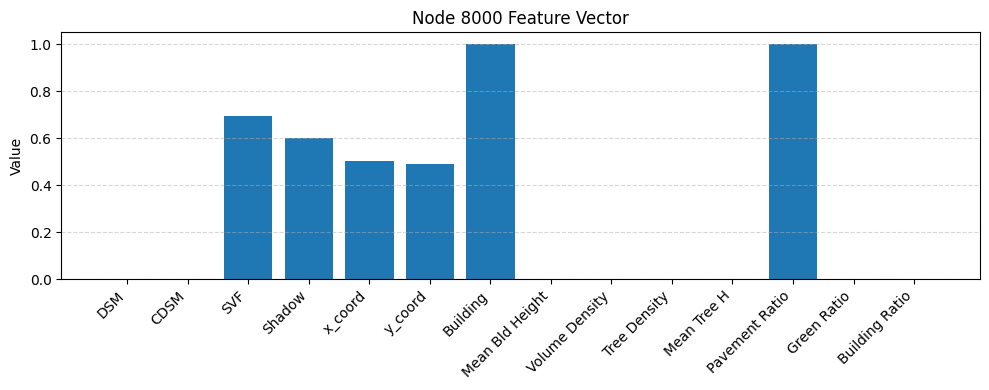

In [25]:
import matplotlib.pyplot as plt

feature_names = [
    "DSM", "CDSM", "SVF", "Shadow",
    "x_coord", "y_coord", "Building",
    "Mean Bld Height", "Volume Density", "Tree Density",
    "Mean Tree H", "Pavement Ratio", "Green Ratio", "Building Ratio"
]

plt.figure(figsize=(10, 4))
plt.bar(range(len(features)), features)
plt.xticks(range(len(features)), feature_names, rotation=45, ha='right')
plt.title(f"Node {node_idx} Feature Vector")
plt.ylabel("Value")
plt.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


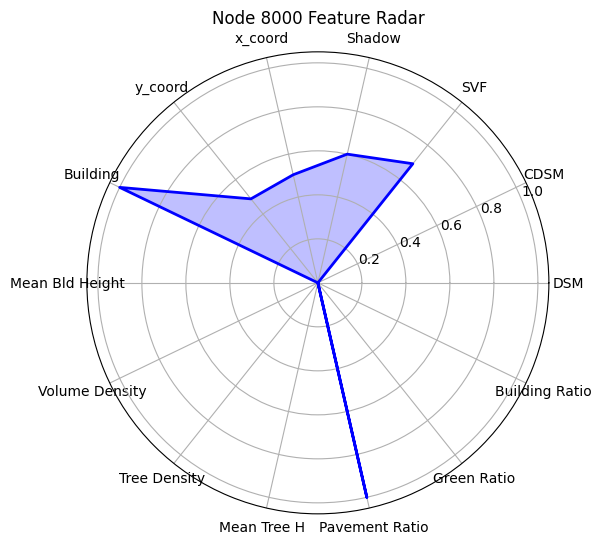

In [26]:
import numpy as np

angles = np.linspace(0, 2 * np.pi, len(features), endpoint=False).tolist()
features_circular = np.concatenate((features, [features[0]]))
angles_circular = np.concatenate((angles, [angles[0]]))

fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))
ax.plot(angles_circular, features_circular, 'b-', linewidth=2)
ax.fill(angles_circular, features_circular, 'b', alpha=0.25)
ax.set_thetagrids(np.degrees(angles), feature_names)
ax.set_title(f"Node {node_idx} Feature Radar")
plt.show()


In [27]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np


In [28]:
node_idx = 8000  # or any index
features = graph.x[node_idx].cpu().numpy()
feature_dim = features.shape[0]


In [29]:
# Origin of the vector (node's spatial location, optional)
origin = np.array([0, 0, 0])

# Generate feature directions on a hemisphere using spherical coordinates
phi = np.linspace(0, 2 * np.pi, feature_dim, endpoint=False)
theta = np.pi / 4  # Elevation angle (45° from ground plane)

# Direction vectors for each feature
dirs = np.stack([
    np.cos(phi) * np.sin(theta),
    np.sin(phi) * np.sin(theta),
    np.cos(theta) * np.ones_like(phi)
], axis=1)  # shape: (F, 3)

# Scale each direction by the feature magnitude
vectors = dirs * features[:, None]


C:\Users\Ardo\AppData\Local\Temp\ipykernel_11108\3485227065.py:39: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



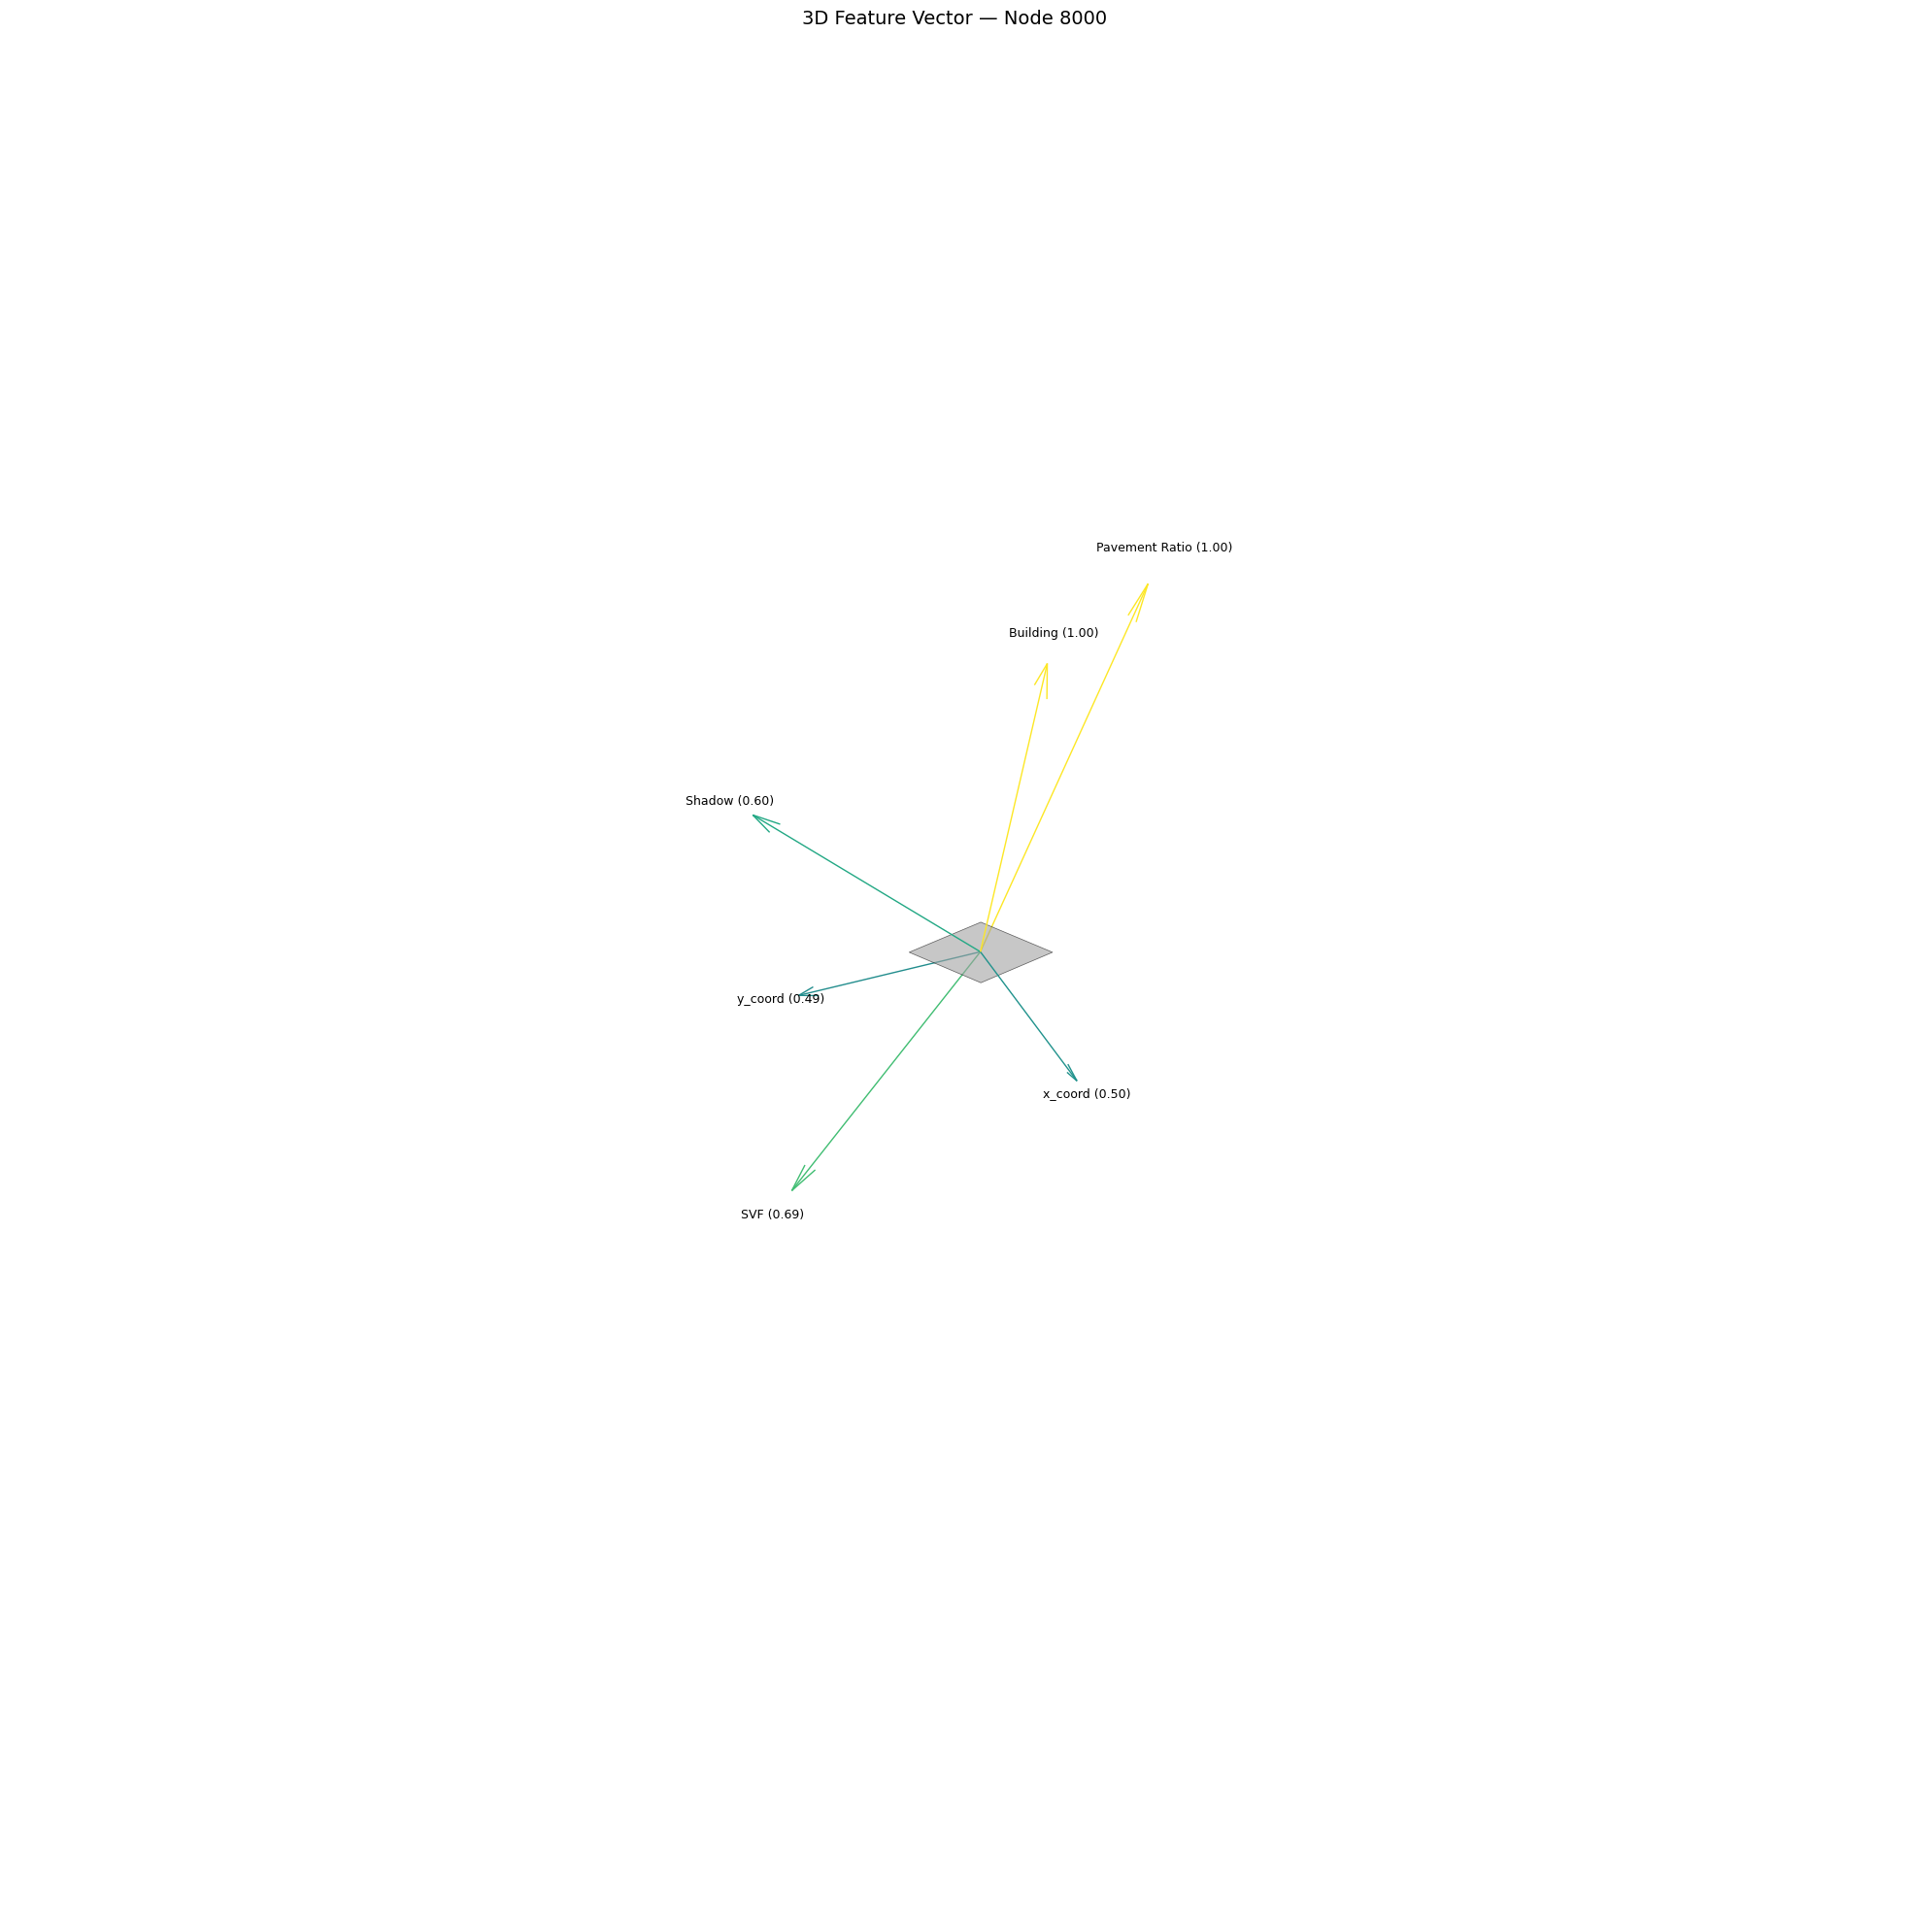

In [50]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.cm as cm

# --- Replace this with your actual data ---
node_idx = 8000
features = graph.x[node_idx].cpu().numpy()
feature_dim = features.shape[0]

feature_names = [
    "DSM", "CDSM", "SVF", "Shadow",
    "x_coord", "y_coord", "Building",
    "Mean Bld Height", "Volume Density", "Tree Density",
    "Mean Tree H", "Pavement Ratio", "Green Ratio", "Building Ratio"
]

# --- Normalize feature values for consistent arrow lengths ---
features_norm = features / np.max(features) if np.max(features) > 0 else features

# --- Use a Fibonacci sphere to evenly distribute directions ---
def fibonacci_sphere(samples):
    points = []
    phi = np.pi * (3. - np.sqrt(5.))  # golden angle
    for i in range(samples):
        y = 1 - (i / float(samples - 1)) * 2
        radius = np.sqrt(1 - y * y)
        theta = phi * i
        x = np.cos(theta) * radius
        z = np.sin(theta) * radius
        points.append((x, y, z))
    return np.array(points)

directions = fibonacci_sphere(feature_dim)
origin = np.array([0, 0, 0])

# --- Set up the color map (viridis) based on original feature magnitudes ---
norm = plt.Normalize(np.min(features), np.max(features))
cmap = cm.get_cmap("viridis")

# --- Create 3D plot ---
fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(111, projection='3d')

# --- Add a square tile at the origin in the XY-plane ---
tile_size = 0.2  # Length of one side of the square
half = tile_size / 2
tile_x = np.array([[-half, half], [-half, half]])
tile_y = np.array([[-half, -half], [half, half]])
tile_z = np.zeros_like(tile_x)

ax.plot_surface(tile_x, tile_y, tile_z, color='lightgray', alpha=0.6, edgecolor='k', linewidth=0.5)

# --- Plot feature vectors ---
for i in range(feature_dim):
    if features_norm[i] < 1e-6:
        continue  # Skip zero or near-zero values

    vec = directions[i] * features_norm[i]
    color = cmap(norm(features[i]))  # Use original (not normalized) value for color

    # Draw arrow
    ax.quiver(*origin, *vec, color=color, arrow_length_ratio=0.1, linewidth=1)

    # Label at tip
    label_pos = vec * 1.1
    label_text = f"{feature_names[i]} ({features[i]:.2f})"
    ax.text(*label_pos, label_text, fontsize=9, ha='center', va='center')

# --- Style the plot ---
ax.set_title(f"3D Feature Vector — Node {node_idx}", fontsize=14)
ax.set_xlim([-1.2, 1.2])
ax.set_ylim([-1.2, 1.2])
ax.set_zlim([-1.2, 1.2])
ax.set_axis_off()
ax.view_init(elev=25, azim=135)

# Optional colorbar
# mappable = cm.ScalarMappable(norm=norm, cmap=cmap)
# cbar = plt.colorbar(mappable, ax=ax, shrink=0.6, pad=0.1)
# cbar.set_label("Feature Value", fontsize=10)

plt.tight_layout()
plt.show()


In [43]:
import torch

# Count non-zero features for each node
nonzero_counts = (graph.x != 0).sum(dim=1)  # shape: (num_nodes,)

# Find the node index with the highest number of non-zero features
best_node_idx = torch.argmax(nonzero_counts).item()

# Get the actual count and feature vector
nonzero_feature_count = nonzero_counts[best_node_idx].item()
best_node_features = graph.x[best_node_idx]

print(f"Node {best_node_idx} has {nonzero_feature_count}/14 non-zero features.")
print("Feature values:", best_node_features)


Node 228 has 12/14 non-zero features.
Feature values: tensor([0.0000e+00, 1.0000e+01, 3.5608e-01, 1.4667e-01, 7.8740e-01, 7.8740e-03,
        1.0000e+00, 2.1714e+01, 7.1250e+00, 4.3750e-01, 8.7500e+00, 6.7188e-01,
        0.0000e+00, 3.2812e-01])


C:\Users\Ardo\AppData\Local\Temp\ipykernel_20968\3611041102.py:41: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("viridis")


IndexError: list index out of range

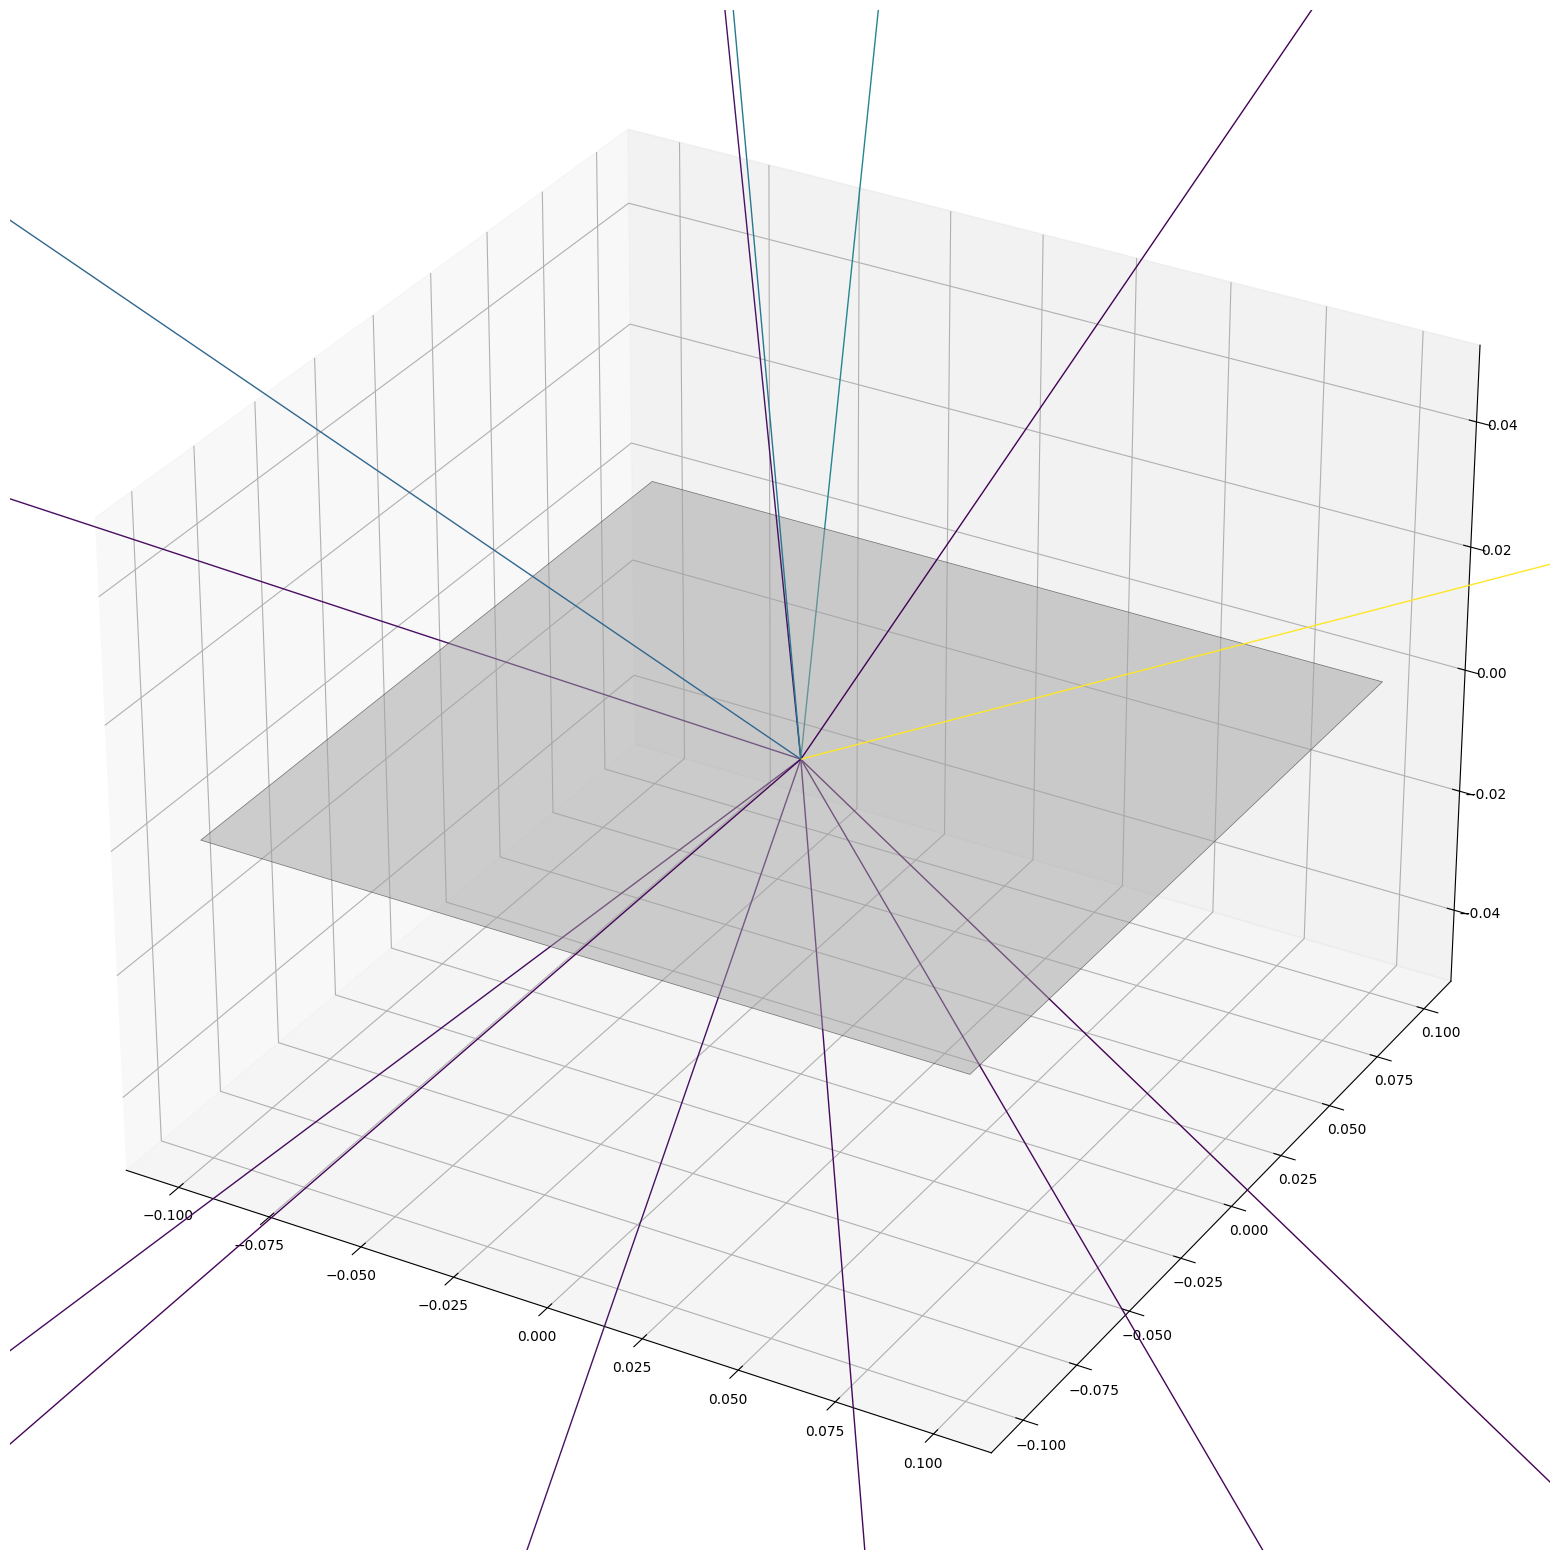

In [183]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.cm as cm

node_idx = 228
features = graph.x[node_idx].cpu().numpy()
feature_dim = features.shape[0]

feature_names = [
    "DSM", "CDSM", "SVF", "Shadow",
    "x_coord", "y_coord", "Building",
    "Mean Bld Height", "Volume Density", "Tree Density",
    "Mean Tree H", "Pavement Ratio", "Green Ratio", "Building Ratio"
]

# --- Logarithmic scaling to enhance small values ---
epsilon = 1e-6
features_log = np.log(features + epsilon)
features_log -= features_log.min()  # Shift to non-negative
features_norm = features_log / features_log.max()  # Normalize to [0, 1]

# --- Use a Fibonacci sphere to evenly distribute directions ---
def fibonacci_sphere(samples):
    points = []
    phi = np.pi * (3. - np.sqrt(5.))  # golden angle
    for i in range(samples):
        y = 1 - (i / float(samples - 1)) * 2
        radius = np.sqrt(1 - y * y)
        theta = phi * i
        x = np.cos(theta) * radius
        z = np.sin(theta) * radius
        points.append((x, y, z))
    return np.array(points)

directions = fibonacci_sphere(feature_dim)
origin = np.array([0, 0, 0])

# --- Set up the color map (viridis) based on original feature magnitudes ---
norm = plt.Normalize(np.min(features), np.max(features))
cmap = cm.get_cmap("viridis")

# --- Create 3D plot ---
fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(111, projection='3d')

# --- Add square tile at origin (XY-plane at Z=0) ---
tile_size = 0.2  # length of tile side
half = tile_size / 2
tile_x = np.array([[-half, half], [-half, half]])
tile_y = np.array([[-half, -half], [half, half]])
tile_z = np.zeros_like(tile_x)

ax.plot_surface(tile_x, tile_y, tile_z, color='lightgray', alpha=0.5, edgecolor='k', linewidth=0.5)

# --- Plot feature vectors ---
for i in range(feature_dim):
    if features[i] < 1e-6:
        continue  # Skip actual zero values

    vec = directions[i] * features_norm[i]
    color = cmap(norm(features[i]))  # Use original value for color

    # Draw arrow
    ax.quiver(*origin, *vec, color=color, arrow_length_ratio=0.1, linewidth=1)

    # Label at tip
    label_pos = vec * 1.1
    label_text = f"{feature_names[i]} ({features[i]:.2f})"
    ax.text(*label_pos, label_text, fontsize=9, ha='center', va='center')

# --- Style the plot ---
ax.set_title(f"3D Feature Vector — Node {node_idx}", fontsize=14)
ax.set_xlim([-1.2, 1.2])
ax.set_ylim([-1.2, 1.2])
ax.set_zlim([-1.2, 1.2])
ax.set_axis_off()
ax.view_init(elev=25, azim=135)

# Optional colorbar
# mappable = cm.ScalarMappable(norm=norm, cmap=cmap)
# cbar = plt.colorbar(mappable, ax=ax, shrink=0.6, pad=0.1)
# cbar.set_label("Feature Value", fontsize=10)

plt.tight_layout()
plt.show()


In [95]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm
import imageio.v2 as imageio
import tempfile

# --- Output location ---
output_gif = r"C:\Users\Ardo\Desktop\presentation_material\node_feature_animation.gif"

# --- More frames, smoother animation ---
node_indices = list(range(0, 500, 5))  # Sample every 5th node for smoother animation

# --- Feature names (14 total) ---
feature_names = [
    "DSM", "CDSM", "SVF", "Shadow",
    "x_coord", "y_coord", "Building",
    "Mean Bld Height", "Volume Density", "Tree Density",
    "Mean Tree H", "Pavement Ratio", "Green Ratio", "Building Ratio"
]

# --- Fibonacci sphere for even vector directions ---
def fibonacci_sphere(samples):
    points = []
    phi = np.pi * (3. - np.sqrt(5.))  # golden angle
    for i in range(samples):
        y = 1 - (i / float(samples - 1)) * 2
        radius = np.sqrt(1 - y * y)
        theta = phi * i
        x = np.cos(theta) * radius
        z = np.sin(theta) * radius
        points.append((x, y, z))
    return np.array(points)

# --- Plot a single node's feature vector in 3D ---
def plot_node_3d_arrow(graph, node_idx, feature_names, save_path):
    features = graph.x[node_idx].cpu().numpy()
    feature_dim = len(features)

    # Log scaling for better visual contrast
    epsilon = 1e-6
    features_log = np.log(features + epsilon)
    features_log -= features_log.min()
    features_norm = features_log / features_log.max()

    directions = fibonacci_sphere(feature_dim)
    origin = np.array([0, 0, 0])
    norm = plt.Normalize(np.min(features), np.max(features))
    cmap = cm.get_cmap("viridis")

    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Square tile at origin (XY plane)
    tile_size = 0.2
    half = tile_size / 2
    tile_x = np.array([[-half, half], [-half, half]])
    tile_y = np.array([[-half, -half], [half, half]])
    tile_z = np.zeros_like(tile_x)
    ax.plot_surface(tile_x, tile_y, tile_z, color='lightgray', alpha=0.5, edgecolor='k', linewidth=0.5)

    for i in range(feature_dim):
        if features[i] < 1e-6:
            continue
        vec = directions[i] * features_norm[i]
        color = cmap(norm(features[i]))
        ax.quiver(*origin, *vec, color=color, arrow_length_ratio=0.1, linewidth=1)
        label_pos = vec * 1.1
        ax.text(*label_pos, f"{feature_names[i]}", fontsize=7, ha='center', va='center')

    ax.set_title(f"Node {node_idx}", fontsize=10)
    ax.set_xlim([-1.2, 1.2])
    ax.set_ylim([-1.2, 1.2])
    ax.set_zlim([-1.2, 1.2])
    ax.set_axis_off()
    ax.view_init(elev=25, azim=135)

    plt.tight_layout()
    plt.savefig(save_path, dpi=120)
    plt.close()

# --- Generate animation frames ---
def generate_animation(graph, node_indices, feature_names, output_gif_path):
    with tempfile.TemporaryDirectory() as temp_dir:
        frame_paths = []
        for i, node_idx in enumerate(node_indices):
            frame_path = os.path.join(temp_dir, f"frame_{i:03d}.png")
            plot_node_3d_arrow(graph, node_idx, feature_names, save_path=frame_path)
            frame_paths.append(frame_path)

        frames = [imageio.imread(fp) for fp in frame_paths]
        imageio.mimsave(output_gif_path, frames, duration=1.0, loop=0)  # 🔁 Loop forever
        print(f"✅ GIF saved to: {output_gif_path}")

# --- Run it ---
generate_animation(graph, node_indices, feature_names, output_gif)


C:\Users\Ardo\AppData\Local\Temp\ipykernel_11108\1581917308.py:51: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



✅ GIF saved to: C:\Users\Ardo\Desktop\presentation_material\node_feature_animation.gif


C:\Users\Ardo\AppData\Local\Temp\ipykernel_20968\341519995.py:61: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("viridis")


IndexError: list index out of range

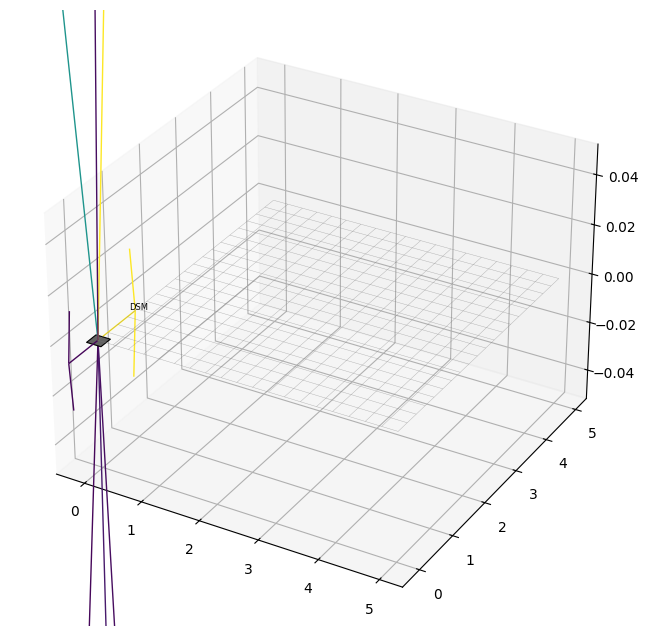

In [ ]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm
import imageio.v2 as imageio
import tempfile

# --- Path to save GIF ---
output_gif = r"C:\Users\Ardo\Desktop\presentation_material\node_feature_grid_every8.gif"

# --- Sample 1 every 8 nodes ---
node_indices = list(range(0, 1024, 16))

# --- Feature names ---
feature_names = [
    "DSM", "CDSM", "SVF", "Shadow",
    "x_coord", "y_coord", "Building",
    "Mean Bld Height", "Volume Density", "Tree Density",
    "Mean Tree H", "Pavement Ratio", "Green Ratio", "Building Ratio"
]

# --- Fibonacci sphere for arrow directions ---
def fibonacci_sphere(samples):
    points = []
    phi = np.pi * (3. - np.sqrt(5.))  # golden angle
    for i in range(samples):
        y = 1 - (i / float(samples - 1)) * 2
        radius = np.sqrt(1 - y * y)
        theta = phi * i
        x = np.cos(theta) * radius
        z = np.sin(theta) * radius
        points.append((x, y, z))
    return np.array(points)

# --- Grid settings ---
GRID_SCALE = 5.0
GRID_BUFFER = 1.0
X_RANGE = [0 - GRID_BUFFER, GRID_SCALE + GRID_BUFFER]
Y_RANGE = [0 - GRID_BUFFER, GRID_SCALE + GRID_BUFFER]
Z_RANGE = [-1.2, 1.2]

# --- Plot 1 node with fixed camera and full grid ---
def plot_node_fixed_grid(graph, node_idx, feature_names, save_path, scale=GRID_SCALE):
    features = graph.x[node_idx].cpu().numpy()
    feature_dim = len(features)

    epsilon = 1e-6
    features_log = np.log(features + epsilon)
    features_log -= features_log.min()
    features_norm = features_log / features_log.max()

    # Compute position in grid
    x_offset = features[4] * scale
    y_offset = features[5] * scale
    origin = np.array([x_offset, y_offset, 0])

    directions = fibonacci_sphere(feature_dim)
    norm = plt.Normalize(np.min(features), np.max(features))
    cmap = cm.get_cmap("viridis")

    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Draw background grid wireframe
    grid_res = 20
    gx, gy = np.meshgrid(
        np.linspace(0, scale, grid_res),
        np.linspace(0, scale, grid_res)
    )
    gz = np.zeros_like(gx)
    ax.plot_wireframe(gx, gy, gz, color='gray', linewidth=0.3, alpha=0.6, zorder=0)

    # Highlight current node with gray tile
    tile_size = 0.25
    half = tile_size / 2
    tile_x = np.array([[-half, half], [-half, half]]) + origin[0]
    tile_y = np.array([[-half, -half], [half, half]]) + origin[1]
    tile_z = np.zeros_like(tile_x) + origin[2]
    ax.plot_surface(
        tile_x, tile_y, tile_z,
        color='gray', alpha=1.0, edgecolor='black', linewidth=0.8, zorder=10
    )

    # ➤ Draw feature arrows
    for i in range(feature_dim):
        if features[i] < 1e-6:
            continue
        vec = directions[i] * features_norm[i]
        color = cmap(norm(features[i]))
        ax.quiver(*origin, *vec, color=color, arrow_length_ratio=0.1, linewidth=1)
        label_pos = origin + vec * 1.1
        ax.text(*label_pos, f"{feature_names[i]}", fontsize=6, ha='center', va='center')

    # Camera and axes settings
    ax.set_xlim(X_RANGE)
    ax.set_ylim(Y_RANGE)
    ax.set_zlim(Z_RANGE)
    ax.view_init(elev=25, azim=135)
    ax.set_axis_off()
    ax.set_title(f"Node {node_idx}", fontsize=10)
    plt.tight_layout()
    plt.savefig(save_path, dpi=120)
    plt.close()

# --- Generate GIF animation ---
def generate_global_grid_animation(graph, node_indices, feature_names, output_gif_path):
    with tempfile.TemporaryDirectory() as temp_dir:
        frame_paths = []
        for i, node_idx in enumerate(node_indices):
            frame_path = os.path.join(temp_dir, f"frame_{i:03d}.png")
            plot_node_fixed_grid(graph, node_idx, feature_names, save_path=frame_path)
            frame_paths.append(frame_path)

        # Collect frames
        frames = [imageio.imread(fp) for fp in frame_paths]
        imageio.mimsave(output_gif_path, frames, duration=1.0, loop=0)
        print(f"Grid GIF saved to: {output_gif_path}")

# --- Run it
generate_global_grid_animation(graph, node_indices, feature_names, output_gif)


In [23]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm
import imageio.v2 as imageio
import tempfile

# --- Path to save GIF ---
output_gif = r"C:\Users\Ardo\Desktop\presentation_material\node_feature_grid_8x8_tiles.gif"

# --- Feature names ---
feature_names = [
    "DSM", "CDSM", "SVF", "Shadow",
    "x_coord", "y_coord", "Building","Landuse",
    "Mean Bld Height", "Volume Density", "Tree Density",
    "Mean Tree H", "Pavement Ratio", "Green Ratio", "Building Ratio"
]

# --- Fibonacci sphere for arrow directions ---
def fibonacci_sphere(samples):
    points = []
    phi = np.pi * (3. - np.sqrt(5.))  # golden angle
    for i in range(samples):
        y = 1 - (i / float(samples - 1)) * 2
        radius = np.sqrt(1 - y * y)
        theta = phi * i
        x = np.cos(theta) * radius
        z = np.sin(theta) * radius
        points.append((x, y, z))
    return np.array(points)

# --- Grid settings ---
GRID_SCALE = 5.0
GRID_BUFFER = 1.0
X_RANGE = [0 - GRID_BUFFER, GRID_SCALE + GRID_BUFFER]
Y_RANGE = [0 - GRID_BUFFER, GRID_SCALE + GRID_BUFFER]
Z_RANGE = [-1.2, 1.2]

# --- Plot 1 node with fixed camera and full grid ---
def plot_node_fixed_grid(graph, node_idx, feature_names, save_path, scale=GRID_SCALE):
    features = graph.x[node_idx].cpu().numpy()
    feature_dim = len(features)

    epsilon = 1e-6
    features_log = np.log(features + epsilon)
    features_log -= features_log.min()
    features_norm = features_log / features_log.max()

    x_offset = features[4] * scale
    y_offset = features[5] * scale
    origin = np.array([x_offset, y_offset, 0])

    directions = fibonacci_sphere(feature_dim)
    norm = plt.Normalize(np.min(features), np.max(features))
    cmap = cm.get_cmap("viridis")

    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Draw background grid wireframe (always visible)
    grid_res = 20
    gx, gy = np.meshgrid(
        np.linspace(0, scale, grid_res),
        np.linspace(0, scale, grid_res)
    )
    gz = np.zeros_like(gx)
    ax.plot_wireframe(gx, gy, gz, color='gray', linewidth=0.3, alpha=0.6, zorder=0)

    # Highlight current node with gray tile
    tile_size = 0.25
    half = tile_size / 2
    tile_x = np.array([[-half, half], [-half, half]]) + origin[0]
    tile_y = np.array([[-half, -half], [half, half]]) + origin[1]
    tile_z = np.zeros_like(tile_x) + origin[2]
    ax.plot_surface(
        tile_x, tile_y, tile_z,
        color='gray', alpha=1.0, edgecolor='black', linewidth=0.8, zorder=10
    )

    # Draw feature arrows
    for i in range(feature_dim):
        if features[i] < 1e-6:
            continue
        vec = directions[i] * features_norm[i]
        color = cmap(norm(features[i]))
        ax.quiver(*origin, *vec, color=color, arrow_length_ratio=0.1, linewidth=1)
        label_pos = origin + vec * 1.1
        ax.text(*label_pos, f"{feature_names[i]}", fontsize=6, ha='center', va='center')

    # Camera and axes settings
    ax.set_xlim(X_RANGE)
    ax.set_ylim(Y_RANGE)
    ax.set_zlim(Z_RANGE)
    ax.view_init(elev=25, azim=135)
    ax.set_axis_off()
    ax.set_title(f"Node {node_idx}", fontsize=10)
    plt.tight_layout()
    plt.savefig(save_path, dpi=120)
    plt.close()

# --- Get center node indices for 8x8 tiles ---
def get_8x8_tile_centers(tile_size=16, full_size=128):
    node_indices = []
    for row in range(8):
        for col in range(8):
            row_center = row * tile_size + tile_size // 2
            col_center = col * tile_size + tile_size // 2
            node_idx = row_center * full_size + col_center
            node_indices.append(node_idx)
    return node_indices

# --- Generate GIF animation ---
def generate_global_grid_animation(graph, node_indices, feature_names, output_gif_path):
    with tempfile.TemporaryDirectory() as temp_dir:
        frame_paths = []
        for i, node_idx in enumerate(node_indices):
            frame_path = os.path.join(temp_dir, f"frame_{i:03d}.png")
            plot_node_fixed_grid(graph, node_idx, feature_names, save_path=frame_path)
            frame_paths.append(frame_path)

        frames = [imageio.imread(fp) for fp in frame_paths]
        imageio.mimsave(output_gif_path, frames, duration=15.0, loop=0)
        print(f"8x8 Tile Grid GIF saved to: {output_gif_path}")

# --- Run it ---
node_indices = get_8x8_tile_centers()
generate_global_grid_animation(graph, node_indices, feature_names, output_gif)


C:\Users\Ardo\AppData\Local\Temp\ipykernel_20968\2284874730.py:57: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("viridis")


8x8 Tile Grid GIF saved to: C:\Users\Ardo\Desktop\presentation_material\node_feature_grid_8x8_tiles.gif


In [32]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm

# --- Settings ---
node_idx = 228  # Pick the node to visualize
save_path = r"C:\Users\Ardo\Desktop\presentation_material\node_228_centered_on_svf_new.png"
h, w = 128, 128  # Tile size

feature_names = [
    "DSM", "CDSM", "SVF", "Shadow",
    "x_coord", "y_coord", "Building","Landuse",
    "Mean Bld Height", "Volume Density", "Tree Density",
    "Mean Tree H", "Pavement Ratio", "Green Ratio", "Building Ratio"
]

GRID_SCALE = 5.0
X_RANGE = [0 - 1.0, GRID_SCALE + 1.0]
Y_RANGE = [0 - 1.0, GRID_SCALE + 1.0]
Z_RANGE = [-15.0, 15.0]

# Fibonacci sphere for arrows
def fibonacci_sphere(samples):
    points = []
    phi = np.pi * (3. - np.sqrt(5.))
    for i in range(samples):
        y = 1 - (i / float(samples - 1)) * 2
        radius = np.sqrt(1 - y * y)
        theta = phi * i
        x = np.cos(theta) * radius
        z = np.sin(theta) * radius
        points.append((x, y, z))
    return np.array(points)

# --- Main plot function ---
def plot_node_with_grayscale_layers(graph, node_idx, save_path, scale=GRID_SCALE, h=128, w=128):
    features = graph.x[node_idx].cpu().numpy()
    feature_dim = len(features)

    epsilon = 1e-6
    features_log = np.log(features + epsilon)
    features_log -= features_log.min()
    features_norm = features_log / features_log.max()

    # Position in grid
    x_offset = features[4] * scale
    y_offset = features[5] * scale
    origin = np.array([x_offset, y_offset, 0])
    directions = fibonacci_sphere(feature_dim)

    fig = plt.figure(figsize=(12, 20))
    ax = fig.add_subplot(111, projection='3d')

    # --- Background wire grid ---
    gx, gy = np.meshgrid(np.linspace(0, scale, 20), np.linspace(0, scale, 20))
    gz = np.zeros_like(gx)
    ax.plot_wireframe(gx, gy, gz, color='gray', linewidth=0.3, alpha=1.0)

    # --- Grey square for active node ---
    tile_size = 0.25
    half = tile_size / 2
    tile_x = np.array([[-half, half], [-half, half]]) + origin[0]
    tile_y = np.array([[-half, -half], [half, half]]) + origin[1]
    tile_z = np.zeros_like(tile_x) + origin[2]
    ax.plot_surface(tile_x, tile_y, tile_z, color='gray', alpha=1.0, edgecolor='black', linewidth=0.8)

    # --- Arrows ---
    norm = plt.Normalize(np.min(features), np.max(features))
    cmap = cm.get_cmap("viridis")
    for i in range(feature_dim):
        if features[i] < 1e-6:
            continue
        vec = directions[i] * features_norm[i]
        color = cmap(norm(features[i]))
        ax.quiver(*origin, *vec, color=color, arrow_length_ratio=0.1, linewidth=1)
        label_pos = origin + vec * 1.1
        ax.text(*label_pos, f"{feature_names[i]}", fontsize=6, ha='center', va='center')

    # --- 5 Base Layers (All Grayscale) ---
    full_features = graph.x.cpu().numpy().reshape(h, w, -1)
    layer_map = [
        ("DSM", 0, -5.0),
        ("CDSM", 1, -10.0),
        ("SVF", 2, -15.0),
        ("Shadow", 3, -20.0),
        ("Landuse", 5, -25.0),
    ]

    for label, feat_idx, z_offset in layer_map:
        if label == "Landuse":
            data = full_features[:, :, feat_idx].astype(int)
            unique_vals = np.unique(data)
            num_classes = int(unique_vals.max()) + 1
            color_map = np.linspace(0.1, 0.9, num_classes)
            mapped = np.zeros_like(data, dtype=np.float32)
            for cat in unique_vals:
                mapped[data == cat] = color_map[int(cat)]
            colors = cm.gray(mapped)
        else:
            data = full_features[:, :, feat_idx]
            data_norm = (data - data.min()) / (data.max() - data.min() + 1e-8)
            colors = cm.gray(data_norm)


        X, Y = np.meshgrid(
            np.linspace(0, scale, w),
            np.linspace(0, scale, h)
        )
        Z = np.full_like(X, z_offset)

        ax.plot_surface(X, Y, Z, facecolors=colors, rstride=1, cstride=1, shade=False, alpha=0.85)
        ax.text(scale + 0.3, scale + 0.3, z_offset, label, fontsize=10, color='black',ha='right')

    # --- View ---
    ax.set_xlim(X_RANGE)
    ax.set_ylim(Y_RANGE)
    ax.set_zlim(Z_RANGE)
    ax.set_axis_off()
    ax.view_init(elev=25, azim=135)
    ax.set_title(f"Node {node_idx} with Feature Arrows and Grayscale Layers", fontsize=11)

    plt.tight_layout()
    plt.savefig(save_path, dpi=150)
    plt.close()
    print(f" Saved static plot to:\n{save_path}")

# --- Run
plot_node_with_grayscale_layers(graph, node_idx, save_path)


C:\Users\Ardo\AppData\Local\Temp\ipykernel_20968\3021655862.py:72: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("viridis")


 Saved static plot to:
C:\Users\Ardo\Desktop\presentation_material\node_228_centered_on_svf_new.png


if is slow _ downsample

In [33]:
# Path where you want to save the file
save_dir = r"E:\patches_all_split\part1"
save_path = os.path.join(save_dir, "tile_graphs_new_new.pt")

# Save the graph list
torch.save(graph_list, save_path)

print(f"Saved {len(graph_list)} graphs to:\n{save_path}")

Saved 3708 graphs to:
E:\patches_all_split\part1\tile_graphs_new_new.pt


In [34]:
# Feature names for reference
contextual_feature_names = [
    "Mean Building Height",
    "Volume Density",
    "Tree Density",
    "Mean Tree Height",
    "Pavement Ratio",
    "Green Ratio",
    "Building Ratio"
    
]

def visualize_contextual_features(graph, h, w, tile_id=0, normalize=True):
    """
    Visualize the 7 contextual features from a tile graph.

    Args:
        graph: PyG Data object from create_tile_graph()
        h, w: tile dimensions
        tile_id: integer for labeling
        normalize: whether to normalize each feature to [0, 1]
    """
    # Slice contextual features: indices 7 to 13
    features = graph.x[:, 8:15].cpu().numpy().reshape(h, w, 7)

    if normalize:
        for i in range(7):
            channel = features[..., i]
            min_val, max_val = np.nanmin(channel), np.nanmax(channel)
            if max_val > min_val:
                features[..., i] = (channel - min_val) / (max_val - min_val)

    fig, axs = plt.subplots(1, 7, figsize=(22, 3))
    for i in range(7):
        im = axs[i].imshow(features[..., i], cmap='viridis', vmin=0, vmax=1)
        axs[i].set_title(contextual_feature_names[i], fontsize=8)
        axs[i].axis('off')
        fig.colorbar(im, ax=axs[i], fraction=0.046, pad=0.04)

    plt.suptitle(f"Tile #{tile_id} — Contextual Features (normalized 0–1)", fontsize=12)
    plt.tight_layout()
    plt.show()


✅ Saved: C:\Users\Ardo\Desktop\presentation_material\Tile_2619_contextual.png
✅ Saved: C:\Users\Ardo\Desktop\presentation_material\Tile_456_contextual.png
✅ Saved: C:\Users\Ardo\Desktop\presentation_material\Tile_102_contextual.png
✅ Saved: C:\Users\Ardo\Desktop\presentation_material\Tile_3037_contextual.png
✅ Saved: C:\Users\Ardo\Desktop\presentation_material\Tile_1126_contextual.png


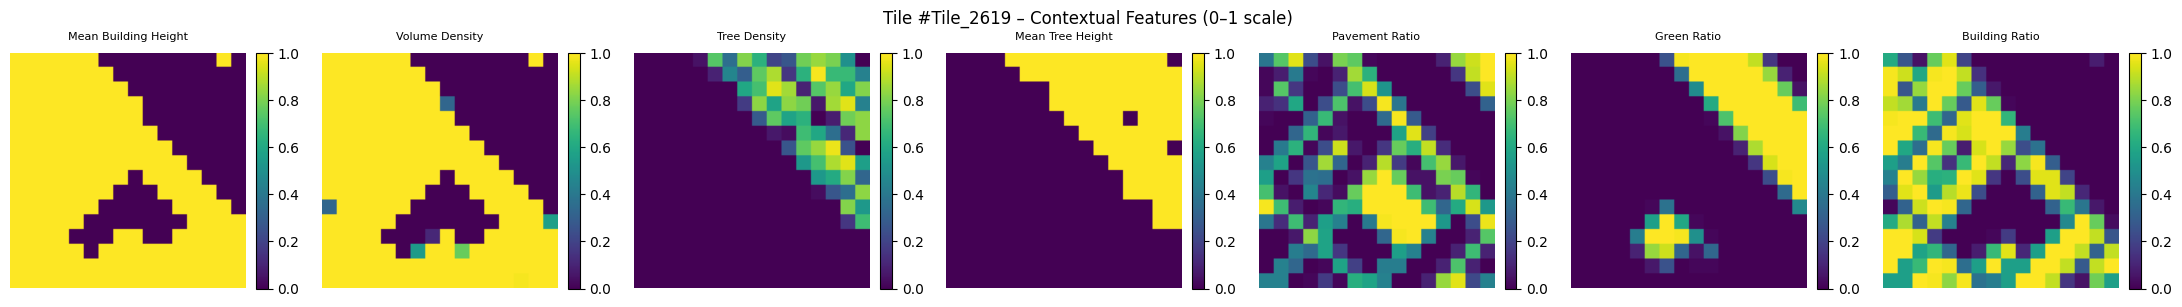

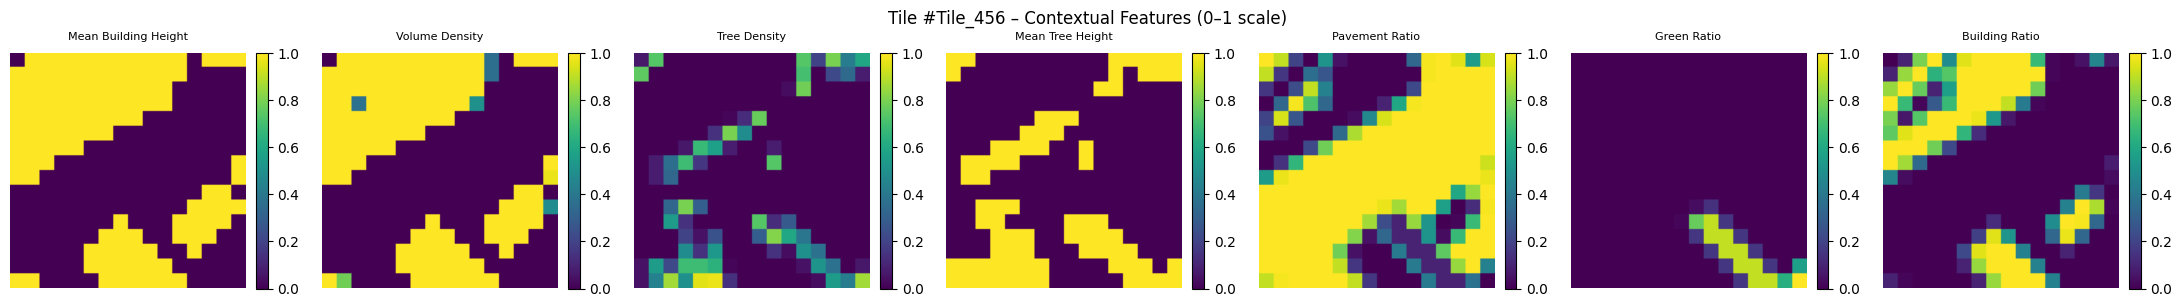

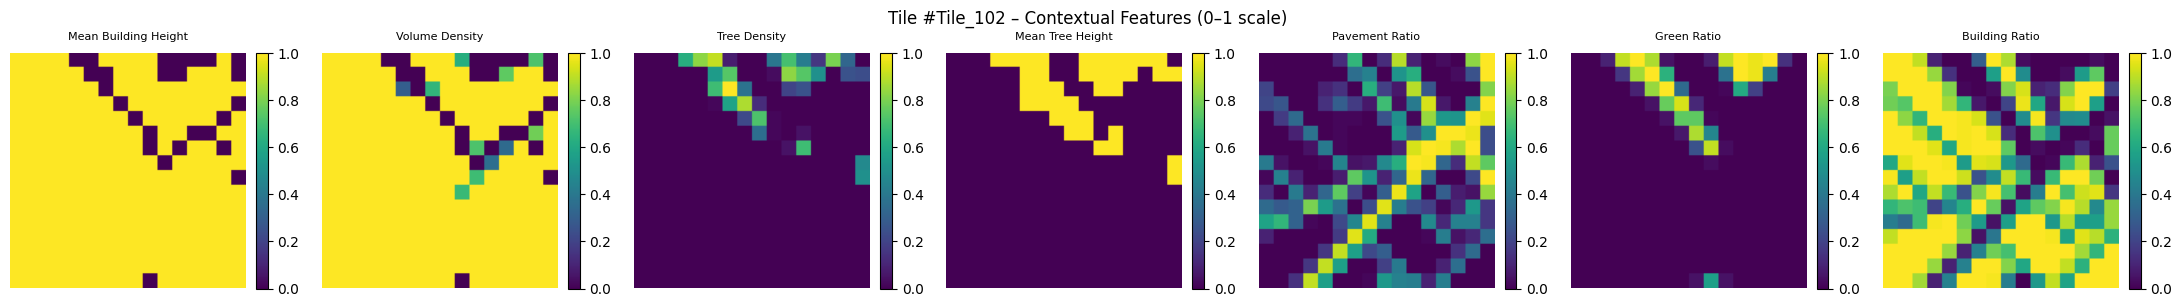

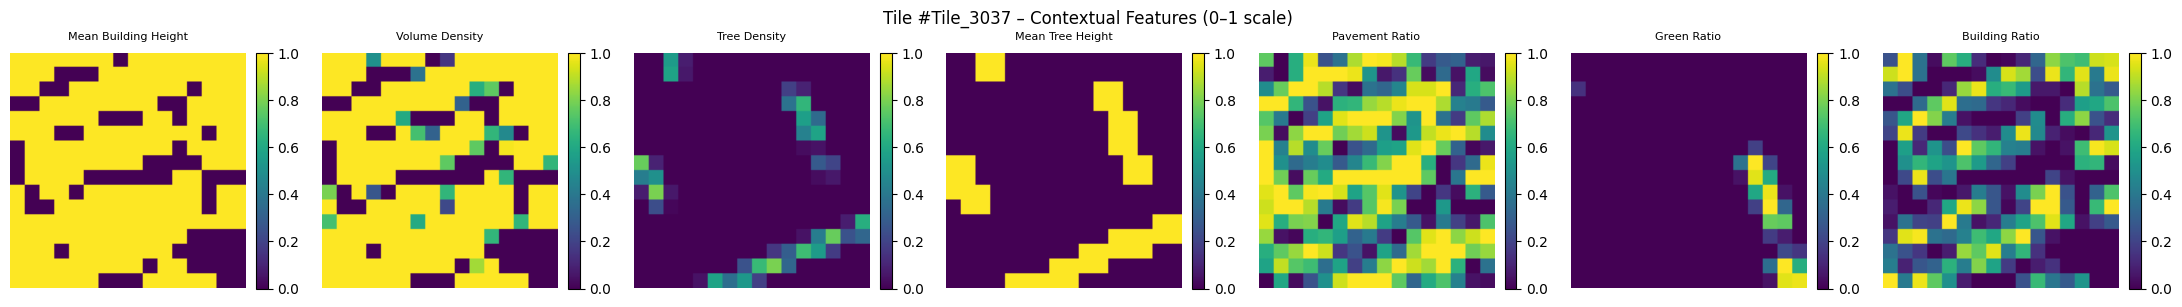

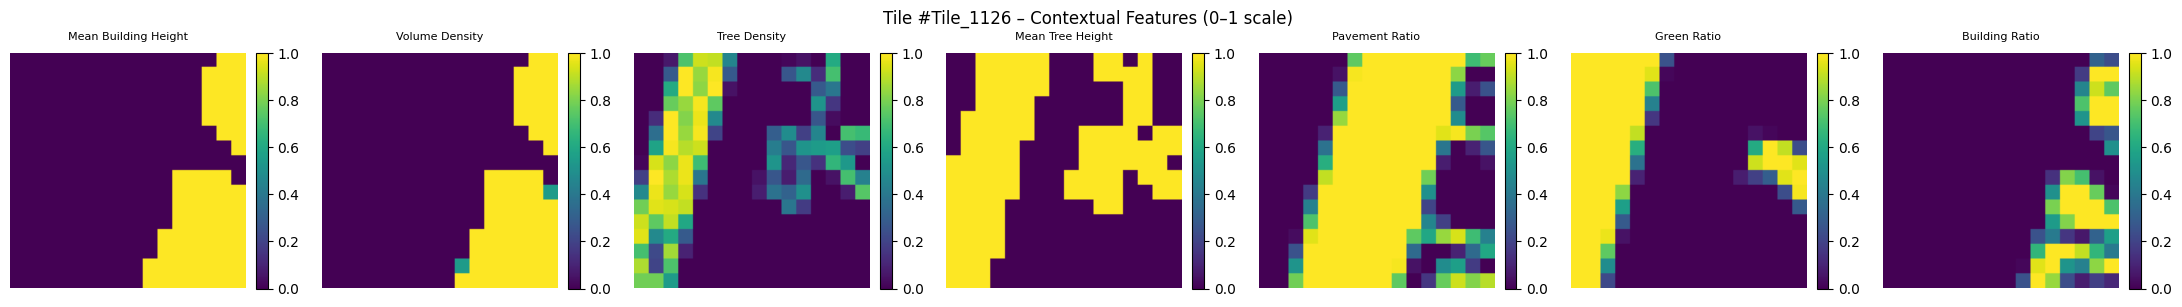

In [35]:
import os
import random
import matplotlib.pyplot as plt

def visualize_contextual_features(graph, h, w, tile_id=0, save_path=None):
    contextual_feature_names = [
        "Mean Building Height",
        "Volume Density",
        "Tree Density",
        "Mean Tree Height",
        "Pavement Ratio",
        "Green Ratio",
        "Building Ratio"
    ]

    features = graph.x[:, 8:15].reshape(h, w, 7)

    fig, axs = plt.subplots(1, 7, figsize=(22, 3))
    for i in range(7):
        im = axs[i].imshow(features[..., i], cmap='viridis', vmin=0, vmax=1)
        axs[i].set_title(contextual_feature_names[i], fontsize=8, pad=10)
        axs[i].axis('off')
        fig.colorbar(im, ax=axs[i], fraction=0.046, pad=0.04)

    plt.suptitle(f"Tile #{tile_id} – Contextual Features (0–1 scale)", fontsize=12)
    plt.tight_layout()

    if save_path:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(save_path, dpi=150)
        print(f"✅ Saved: {save_path}")
    # Don't close — keep it for plt.show()

# ---------------------------
# Set up and visualize 5 random tiles
# ---------------------------
h, w = 128, 128
random.seed(42)  # ✅ Fix random seed for reproducibility

save_dir = r"C:\Users\Ardo\Desktop\presentation_material"
num_tiles = len(graph_list)
assert num_tiles >= 5

random_indices = random.sample(range(num_tiles), 5)

for idx in random_indices:
    tile_name = getattr(graph_list[idx], 'tile_id', f"Tile_{idx}")
    save_path = os.path.join(save_dir, f"{tile_name}_contextual.png")
    visualize_contextual_features(graph_list[idx], h, w, tile_id=tile_name, save_path=save_path)

# ✅ Show all figures at once (after loop)
plt.show()


Mean Building Height

The average height of buildings within a patch (only where buildings exist).

Mathematically:

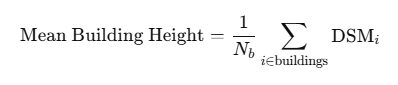
	​

 is the number of building pixels

It tells you how tall the buildings are, on average, in that patch

Volume Density

The total building volume per unit area in the patch.

Mathematically:

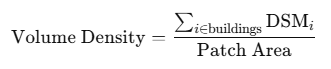

It aggregates the height + extent (coverage) of buildings

Includes both how many buildings and how tall they are

Normalized by the total patch area, not just the building pixels

In [36]:
class GATRegressor(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels=1, heads=4):
        super().__init__()
        self.gat1 = GATConv(in_channels, hidden_channels, heads=heads, concat=True)
        self.gat2 = GATConv(hidden_channels * heads, hidden_channels, heads=1, concat=False)
        self.linear = nn.Linear(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.gat1(x, edge_index)
        x = F.elu(x)
        x = self.gat2(x, edge_index)
        x = F.elu(x)
        x = self.linear(x)
        return x.squeeze(-1)  # Output shape: [N]


Input [N, in_channels]
   ↓
GATConv  (multi-head attention) → [N, hidden_channels * heads]
   ↓ elu
GATConv  (single-head)          → [N, hidden_channels]
   ↓ elu
Linear                          → [N, 1]
   ↓
.squeeze(-1)                    → [N]


In [37]:
# Split into train and val sets
train_graphs, val_graphs = train_test_split(graph_list, test_size=0.2, random_state=42)

# Create PyG DataLoaders
train_loader = DataLoader(train_graphs, batch_size=1, shuffle=True)
val_loader = DataLoader(val_graphs, batch_size=1)


In [38]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GATRegressor(in_channels=15, hidden_channels=64).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

def train_one_epoch():
    model.train()
    total_loss = 0
    for batch in train_loader:
        batch = batch.to(device)
        optimizer.zero_grad()
        out = model(batch.x, batch.edge_index)
        loss = F.mse_loss(out, batch.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(train_loader)

def evaluate(loader):
    model.eval()
    mae_total = 0
    mse_total = 0
    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)
            out = model(batch.x, batch.edge_index)
            mae = F.l1_loss(out, batch.y)
            mse = F.mse_loss(out, batch.y)
            mae_total += mae.item()
            mse_total += mse.item()
    return mae_total / len(loader), mse_total / len(loader)


In [40]:
num_epochs = 50

train_losses = []
val_maes = []
val_rmses = []

for epoch in range(1, num_epochs + 1):
    train_loss = train_one_epoch()
    val_mae, val_mse = evaluate(val_loader)
    val_rmse = val_mse**0.5

    train_losses.append(train_loss)
    val_maes.append(val_mae)
    val_rmses.append(val_rmse)

    print(f"Epoch {epoch:02d} | Train Loss: {train_loss:.4f} | Val MAE: {val_mae:.4f} | Val RMSE: {val_rmse:.4f}")



Epoch 01 | Train Loss: 0.5820 | Val MAE: 0.5572 | Val RMSE: 0.7554
Epoch 02 | Train Loss: 0.5767 | Val MAE: 0.5231 | Val RMSE: 0.7230
Epoch 03 | Train Loss: 0.5682 | Val MAE: 0.7318 | Val RMSE: 0.9179
Epoch 04 | Train Loss: 0.5598 | Val MAE: 0.5361 | Val RMSE: 0.7341
Epoch 05 | Train Loss: 0.5555 | Val MAE: 0.5267 | Val RMSE: 0.7363
Epoch 06 | Train Loss: 0.5535 | Val MAE: 0.5177 | Val RMSE: 0.7192
Epoch 07 | Train Loss: 0.5452 | Val MAE: 0.5679 | Val RMSE: 0.7618
Epoch 08 | Train Loss: 0.5409 | Val MAE: 0.5143 | Val RMSE: 0.7127
Epoch 09 | Train Loss: 0.5406 | Val MAE: 0.5231 | Val RMSE: 0.7206
Epoch 10 | Train Loss: 0.5386 | Val MAE: 0.5040 | Val RMSE: 0.7082
Epoch 11 | Train Loss: 0.5285 | Val MAE: 0.4948 | Val RMSE: 0.6971
Epoch 12 | Train Loss: 0.5261 | Val MAE: 0.5403 | Val RMSE: 0.7232
Epoch 13 | Train Loss: 0.5289 | Val MAE: 0.5037 | Val RMSE: 0.7029
Epoch 14 | Train Loss: 0.5203 | Val MAE: 0.5571 | Val RMSE: 0.7720
Epoch 15 | Train Loss: 0.5145 | Val MAE: 0.5797 | Val RMSE: 0.

______________
This save the best model while it train

In [ ]:
"""num_epochs = 25

train_losses = []
val_maes = []
val_rmses = []

for epoch in range(1, num_epochs + 1):
    train_loss = train_one_epoch()
    val_mae, val_mse = evaluate(val_loader)
    val_rmse = val_mse**0.5

    train_losses.append(train_loss)
    val_maes.append(val_mae)
    val_rmses.append(val_rmse)

    # Save model if validation MAE improves
    if val_mae < best_val_mae:
        best_val_mae = val_mae
        torch.save(model.state_dict(), best_model_path)
        print(f"Saved new best model (MAE: {val_mae:.4f})")

    print(f"Epoch {epoch:02d}/{num_epochs} | Train Loss: {train_loss:.4f} | Val MAE: {val_mae:.4f} | Val RMSE: {val_rmse:.4f}")"""


In [ ]:
"""model.load_state_dict(torch.load(r"C:\Users\Ardo\Desktop\trained_models\best_gat_model.pt"))
model.eval()"""

____________

In [160]:
import torch
import numpy as np
from sklearn.metrics import mean_absolute_error

def feature_ablation(model, graph, metric_fn=mean_absolute_error, y_true=None):
    """
    Compute feature importance by ablation (masking one feature at a time).
    
    Args:
        model: trained GNN model
        graph: PyG Data object with .x, .edge_index, .y
        metric_fn: function to compute error (default MAE)
        y_true: ground-truth labels (numpy array)

    Returns:
        importances: numpy array of length [num_features]
    """
    model.eval()
    device = next(model.parameters()).device
    x = graph.x.to(device)
    edge_index = graph.edge_index.to(device)
    y_true = y_true if y_true is not None else graph.y.view(-1).cpu().numpy()

    # --- Baseline performance ---
    with torch.no_grad():
        y_pred = model(x, edge_index).view(-1).cpu().numpy()
    baseline = metric_fn(y_true, y_pred)

    num_features = x.size(1)
    importances = np.zeros(num_features)

    # --- Ablate each feature ---
    for i in range(num_features):
        x_masked = x.clone()
        x_masked[:, i] = 0.0  # mask feature i
        with torch.no_grad():
            y_pred_masked = model(x_masked, edge_index).view(-1).cpu().numpy()
        score = metric_fn(y_true, y_pred_masked)
        importances[i] = score - baseline  # increase in error

    return importances


In [180]:
import matplotlib.pyplot as plt
import numpy as np

def plot_feature_importance(importances, feature_names, title="Feature Importance (Ablation)"):
    plt.figure(figsize=(7, 7))

    # Sort by importance
    sorted_idx = np.argsort(importances)[::-1]
    sorted_names = [feature_names[i] for i in sorted_idx]
    sorted_vals = importances[sorted_idx]
    #sorted_vals = sorted_vals / sorted_vals.max()


    # Create horizontal bar plot
    bars = plt.barh(
        sorted_names,
        sorted_vals,
        color="#29af7fff",     
        edgecolor='none'
    )

    # Add value labels to bars
    
    for bar, value in zip(bars, sorted_vals):
        plt.text(value + (sorted_vals.max() * 0.002),
                bar.get_y() + bar.get_height() / 2,
                f"{value:.4f}",
                va='center', ha='left', fontsize=8, color="black")

    # Axes labels and title
    plt.xlabel("MAE Increase (Ablation)", fontsize=10)
    plt.title(title, fontsize=12)

    # Invert Y-axis so top feature is at the top
    plt.gca().invert_yaxis()

    # Keep only bottom and left spines (X and Y axes)
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # Ensure ticks are visible
    plt.tick_params(left=True, bottom=True)

    #plt.xscale("log")
    plt.xlim(0, sorted_vals.max())

    plt.tight_layout()
    plt.show()


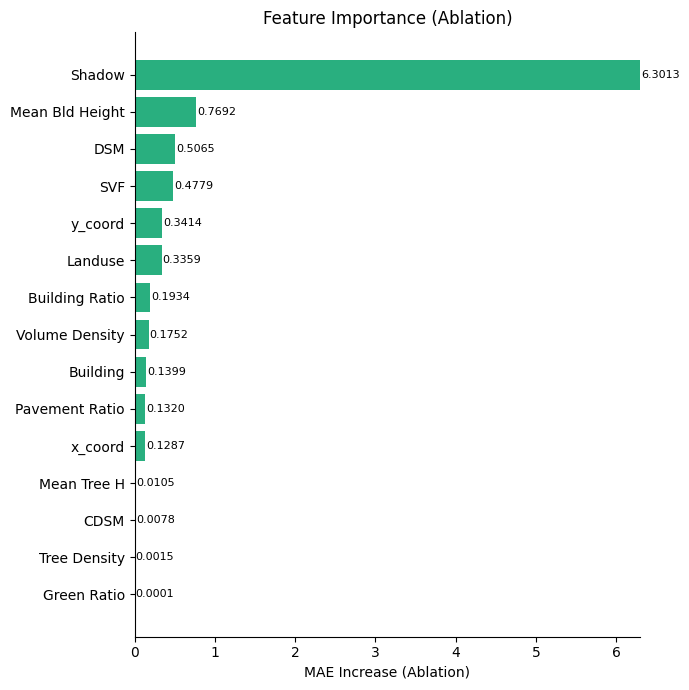

In [181]:
importances = feature_ablation(model, graph, mean_absolute_error, graph.y.cpu().numpy())
plot_feature_importance(importances, feature_names)

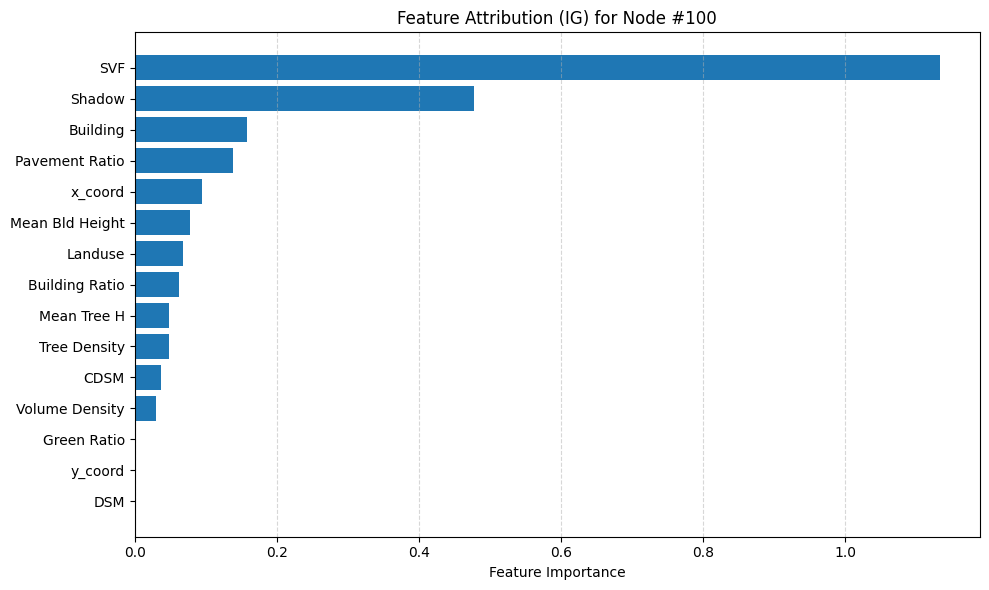

In [117]:
import torch
import matplotlib.pyplot as plt

# ===== User settings =====
node_idx = 100                # node to explain
method = "ig"                 # "ig" or "grad_x_input"
ig_steps = 64                 # path steps for Integrated Gradients
baseline_mode = "zeros"       # "zeros" or "mean" (for IG baseline of the target node)

# Feature names (must match graph.x.shape[1])
feature_names = [
    "DSM", "CDSM", "SVF", "Shadow",
    "x_coord", "y_coord", "Building", "Landuse",
    "Mean Bld Height", "Volume Density", "Tree Density",
    "Mean Tree H", "Pavement Ratio", "Green Ratio", "Building Ratio"
]

# ===== Helper: get scalar output for the node =====
def node_output_scalar(out, node_idx: int):
    """
    Returns a scalar from the model output for the given node.
    Works for shapes [N], [N,1], or [N,D] (will average D if D>1).
    """
    node_out = out[node_idx]
    if node_out.ndim == 0:
        return node_out
    return node_out.view(-1).mean()

# ===== Attribution methods =====
@torch.no_grad()
def _mean_feature_baseline(x: torch.Tensor):
    return x.mean(dim=0, keepdim=True).expand_as(x)

def grad_x_input_importance(model, graph, node_idx: int, device=None):
    device = device or next(model.parameters()).device
    x = graph.x.to(device).clone().detach().requires_grad_(True)
    edge_index = graph.edge_index.to(device)
    model.eval()

    out = model(x, edge_index)
    pred = node_output_scalar(out, node_idx)
    model.zero_grad(set_to_none=True)
    pred.backward()

    grad = x.grad[node_idx]                # [num_features]
    scores = (grad * x[node_idx]).abs()    # Grad ✕ Input
    return scores.detach().cpu()

def integrated_gradients_importance(model, graph, node_idx: int, steps=64,
                                    baseline_mode="zeros", device=None):
    """
    Integrated Gradients along a straight path that only varies the *target node's*
    features from baseline -> actual. All other nodes stay fixed (more stable for GNNs).
    """
    device = device or next(model.parameters()).device
    x_full = graph.x.to(device).clone().detach()
    edge_index = graph.edge_index.to(device)
    model.eval()

    # Build baseline that only replaces the target node’s features
    baseline = x_full.clone()
    if baseline_mode == "zeros":
        baseline[node_idx] = 0.0
    elif baseline_mode == "mean":
        baseline[node_idx] = x_full.mean(dim=0)
    else:
        raise ValueError("baseline_mode must be 'zeros' or 'mean'.")

    # Accumulate gradients for the target node only
    total_grad = torch.zeros_like(x_full[node_idx])

    # Path integral
    for s in range(1, steps + 1):
        alpha = float(s) / steps
        xi = x_full.clone()
        xi[node_idx] = baseline[node_idx] + alpha * (x_full[node_idx] - baseline[node_idx])
        xi.requires_grad_(True)

        out = model(xi, edge_index)
        pred = node_output_scalar(out, node_idx)
        model.zero_grad(set_to_none=True)

        # Gradient w.r.t. xi (use autograd.grad to get non-leaf grads reliably)
        grad_full = torch.autograd.grad(pred, xi, retain_graph=False, create_graph=False)[0]
        total_grad += grad_full[node_idx]

    # IG attribution for the node
    ig = (x_full[node_idx] - baseline[node_idx]) * (total_grad / steps)
    scores = ig.abs()
    return scores.detach().cpu()

# ===== Run & plot =====
def plot_feature_importance(scores, feature_names, node_idx):
    scores = scores.numpy()
    if feature_names is not None:
        assert len(feature_names) == len(scores), \
            f"feature_names ({len(feature_names)}) != num_features ({len(scores)})"

    sorted_idx = scores.argsort()[::-1]
    sorted_scores = scores[sorted_idx]
    sorted_labels = [feature_names[i] for i in sorted_idx] if feature_names else [str(i) for i in sorted_idx]

    plt.figure(figsize=(10, 6))
    plt.barh(range(len(sorted_scores)), sorted_scores)  # keep styling simple/robust
    plt.yticks(range(len(sorted_scores)), sorted_labels)
    plt.xlabel("Feature Importance")
    plt.title(f"Feature Attribution ({method.upper()}) for Node #{node_idx}")
    plt.gca().invert_yaxis()
    plt.grid(axis='x', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

# ===== Execute =====
def run_explanation(model, graph, node_idx, method="ig", ig_steps=64, baseline_mode="zeros"):
    # Basic checks
    assert 0 <= node_idx < graph.num_nodes, "node_idx out of range."
    if feature_names is not None:
        assert len(feature_names) == graph.x.size(1), \
            f"feature_names length ({len(feature_names)}) must equal graph.x.size(1) ({graph.x.size(1)})"

    if method.lower() in ("ig", "integrated_gradients"):
        scores = integrated_gradients_importance(model, graph, node_idx,
                                                 steps=ig_steps, baseline_mode=baseline_mode)
    elif method.lower() in ("grad_x_input", "grad*input", "grad_input"):
        scores = grad_x_input_importance(model, graph, node_idx)
    else:
        raise ValueError("Unknown method. Use 'ig' or 'grad_x_input'.")

    plot_feature_importance(scores, feature_names, node_idx)

# ==== Call it ====
# Make sure your variables `model` and `graph` already exist (as in your notebook).
run_explanation(model, graph, node_idx=node_idx, method=method,
                ig_steps=ig_steps, baseline_mode=baseline_mode)


In [120]:
import torch
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def evaluate_model(model, graph):
    model.eval()
    with torch.no_grad():
        out = model(graph.x, graph.edge_index)

    # Ground truth and predictions
    y_true = graph.y.view(-1).cpu().numpy()
    y_pred = out.view(-1).cpu().numpy()

    # Metrics
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / (y_true + 1e-8))) * 100

    print("📊 Model Evaluation Metrics")
    print(f"MAE   : {mae:.4f}")
    print(f"RMSE  : {rmse:.4f}")
    print(f"R²    : {r2:.4f}")
    print(f"MAPE  : {mape:.2f}%")

    return {
        "mae": mae,
        "rmse": rmse,
        "r2": r2,
        "mape": mape,
        "y_true": y_true,
        "y_pred": y_pred
    }

# --- Run it
results = evaluate_model(model, graph)


📊 Model Evaluation Metrics
MAE   : 0.4495
RMSE  : 0.6964
R²    : 0.9668
MAPE  : 1.30%


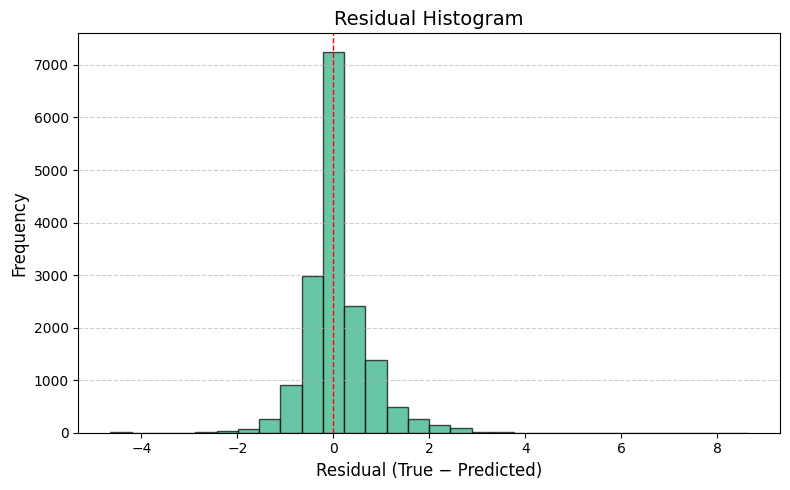

In [121]:
import matplotlib.pyplot as plt

def plot_residuals(results, bins=30):
    y_true = results["y_true"]
    y_pred = results["y_pred"]
    residuals = y_true - y_pred

    plt.figure(figsize=(8, 5))
    plt.hist(residuals, bins=bins, color="#29af7f", edgecolor="black", alpha=0.7)
    plt.axvline(0, color="red", linestyle="--", linewidth=1)
    
    plt.title("Residual Histogram", fontsize=14)
    plt.xlabel("Residual (True − Predicted)", fontsize=12)
    plt.ylabel("Frequency", fontsize=12)
    plt.grid(axis="y", linestyle="--", alpha=0.6)
    plt.tight_layout()
    plt.show()

# --- Run it
plot_residuals(results)



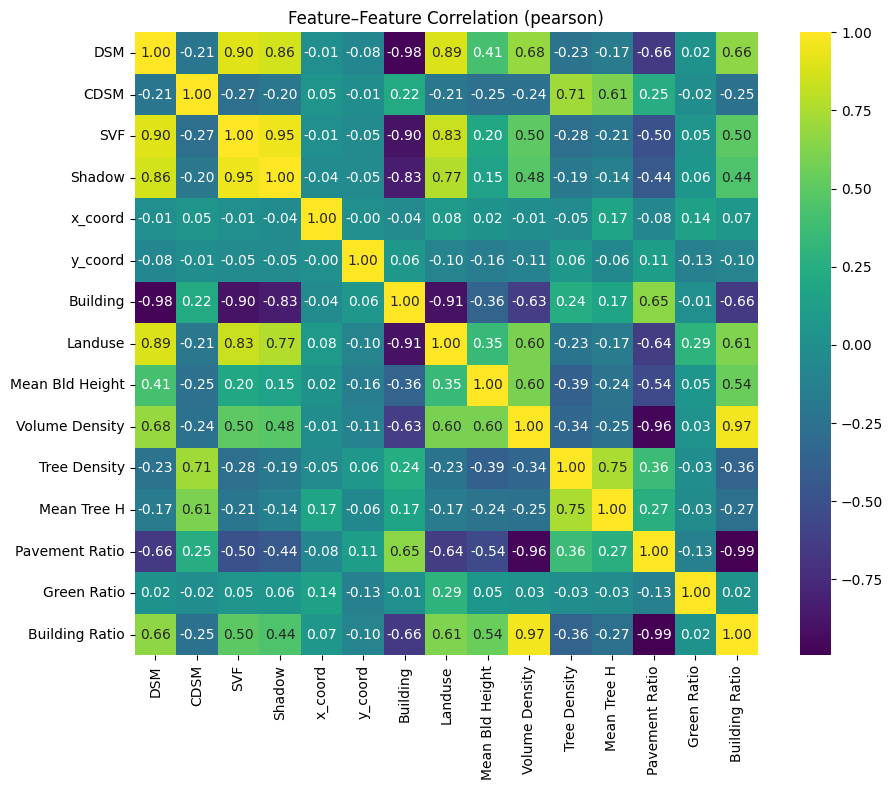

In [134]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def plot_feature_correlation(graph, feature_names=None, method="pearson"):
    X = graph.x.cpu().numpy()
    df = pd.DataFrame(X, columns=feature_names if feature_names else None)
    
    corr = df.corr(method=method)

    plt.figure(figsize=(10, 8))
    sns.heatmap(corr, annot=True, fmt=".2f", cmap="viridis", square=True, cbar=True)
    plt.title(f"Feature–Feature Correlation ({method})")
    plt.tight_layout()
    plt.show()

# Example
feature_names = [
    "DSM", "CDSM", "SVF", "Shadow",
    "x_coord", "y_coord", "Building", "Landuse",
    "Mean Bld Height", "Volume Density", "Tree Density",
    "Mean Tree H", "Pavement Ratio", "Green Ratio", "Building Ratio"
]
plot_feature_correlation(graph, feature_names)


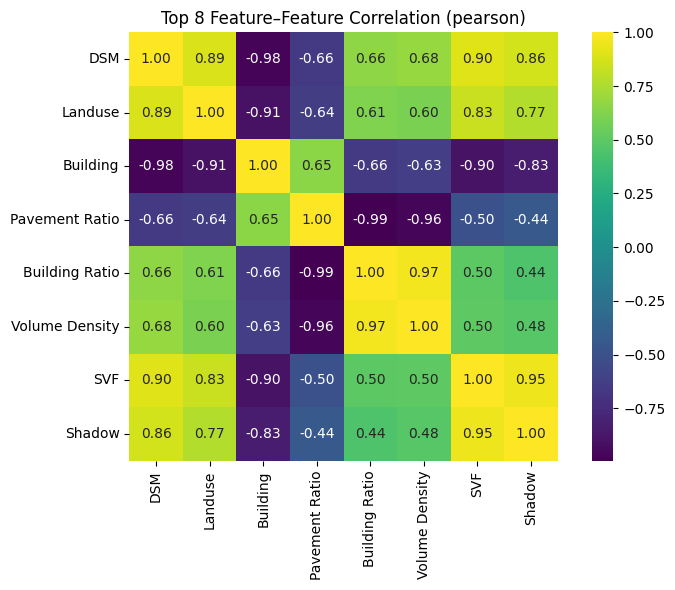

In [135]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def plot_feature_correlation(graph, feature_names=None, method="pearson", top_k=8):
    X = graph.x.cpu().numpy()
    df = pd.DataFrame(X, columns=feature_names if feature_names else None)
    
    corr = df.corr(method=method)

    # Rank features by mean absolute correlation (excluding self-correlation)
    mean_corr = corr.abs().mean().sort_values(ascending=False)
    top_features = mean_corr.head(top_k).index

    # Subset correlation matrix
    corr_top = corr.loc[top_features, top_features]

    # Plot heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(
        corr_top,
        annot=True,
        fmt=".2f",
        cmap="viridis",
        square=True,
        cbar=True
    )
    plt.title(f"Top {top_k} Feature–Feature Correlation ({method})")
    plt.tight_layout()
    plt.show()

# Example
feature_names = [
    "DSM", "CDSM", "SVF", "Shadow",
    "x_coord", "y_coord", "Building", "Landuse",
    "Mean Bld Height", "Volume Density", "Tree Density",
    "Mean Tree H", "Pavement Ratio", "Green Ratio", "Building Ratio"
]
plot_feature_correlation(graph, feature_names, top_k=8)


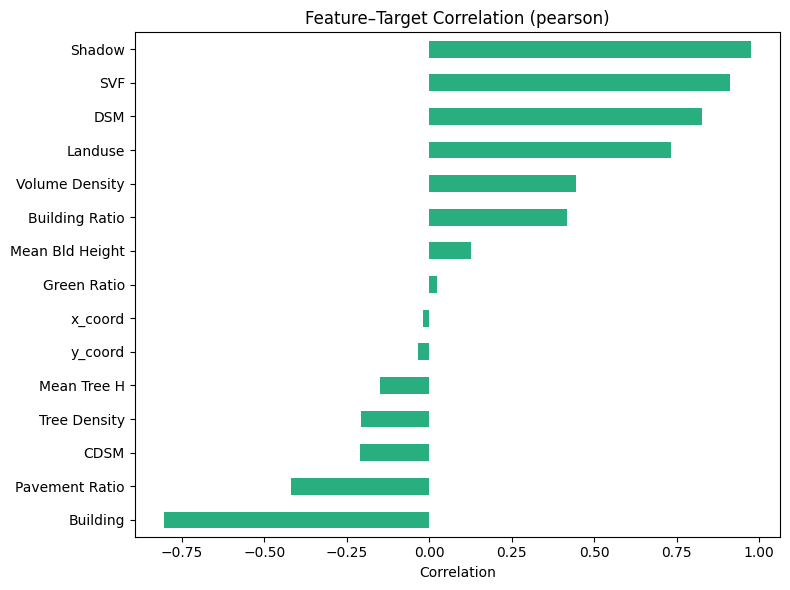

In [130]:
def feature_target_correlation(graph, feature_names=None, method="pearson"):
    import pandas as pd
    X = graph.x.cpu().numpy()
    y = graph.y.view(-1).cpu().numpy()

    df = pd.DataFrame(X, columns=feature_names if feature_names else None)
    df["target"] = y

    corr = df.corr(method=method)["target"].drop("target")

    plt.figure(figsize=(8, 6))
    corr.sort_values().plot(kind="barh", color="#29af7f")
    plt.title(f"Feature–Target Correlation ({method})")
    plt.xlabel("Correlation")
    plt.tight_layout()
    plt.show()

# Example
feature_target_correlation(graph, feature_names)


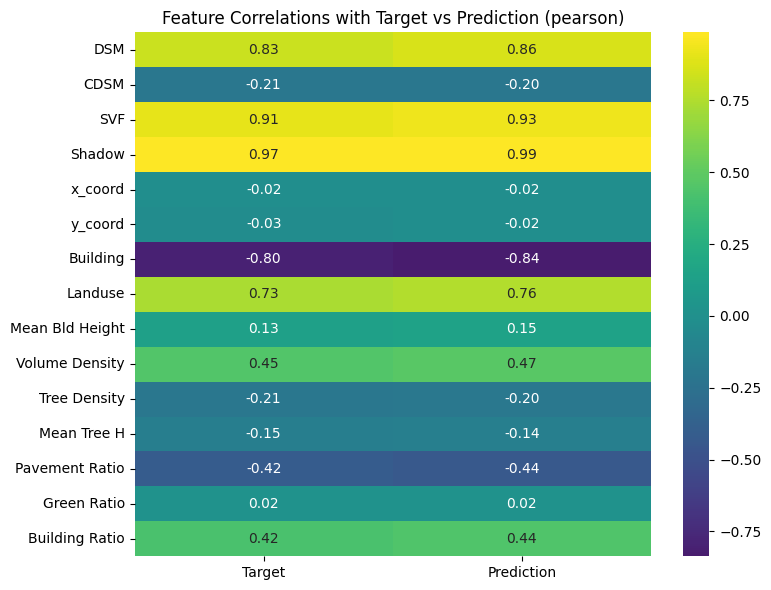

                   Target  Prediction
DSM              0.826610    0.860508
CDSM            -0.208853   -0.204747
SVF              0.911312    0.933227
Shadow           0.974534    0.986958
x_coord         -0.020454   -0.023832
y_coord         -0.034317   -0.022650
Building        -0.804965   -0.836864
Landuse          0.732456    0.758537
Mean Bld Height  0.125019    0.149175
Volume Density   0.446146    0.472938
Tree Density    -0.206487   -0.198339
Mean Tree H     -0.150598   -0.144462
Pavement Ratio  -0.418169   -0.443116
Green Ratio      0.023875    0.020368
Building Ratio   0.418961    0.444525


In [136]:
import torch
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def compare_target_prediction_correlation(model, graph, feature_names=None, method="pearson"):
    # --- Extract features and labels ---
    X = graph.x.cpu().numpy()
    y_true = graph.y.view(-1).cpu().numpy()

    # --- Get model predictions ---
    model.eval()
    with torch.no_grad():
        y_pred = model(graph.x, graph.edge_index).view(-1).cpu().numpy()

    # --- Build DataFrame ---
    df = pd.DataFrame(X, columns=feature_names if feature_names else None)
    df["target"] = y_true
    df["prediction"] = y_pred

    # --- Compute correlations ---
    corr_target = df.corr(method=method)["target"].drop(["target", "prediction"])
    corr_pred   = df.corr(method=method)["prediction"].drop(["target", "prediction"])

    # --- Combine into one DataFrame ---
    corr_df = pd.DataFrame({
        "Target": corr_target,
        "Prediction": corr_pred
    })

    # --- Plot ---
    plt.figure(figsize=(8, 6))
    sns.heatmap(corr_df, annot=True, fmt=".2f", cmap="viridis", center=0, cbar=True)
    plt.title(f"Feature Correlations with Target vs Prediction ({method})")
    plt.tight_layout()
    plt.show()

    return corr_df

# Example usage
feature_names = [
    "DSM", "CDSM", "SVF", "Shadow",
    "x_coord", "y_coord", "Building", "Landuse",
    "Mean Bld Height", "Volume Density", "Tree Density",
    "Mean Tree H", "Pavement Ratio", "Green Ratio", "Building Ratio"
]

corr_results = compare_target_prediction_correlation(model, graph, feature_names)
print(corr_results)


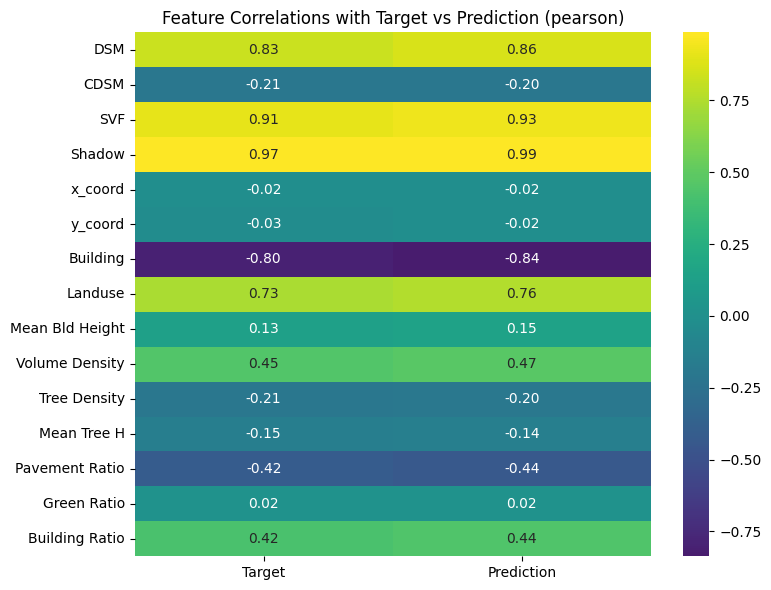

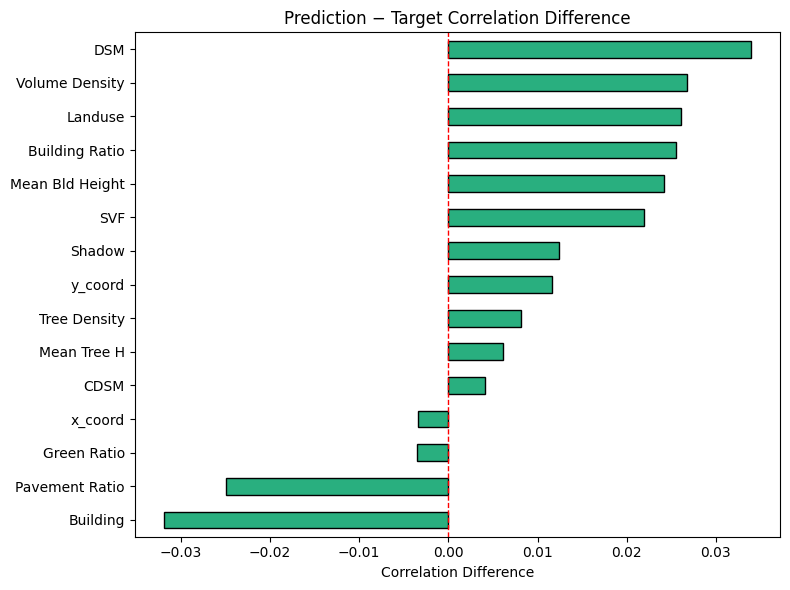

                   Target  Prediction  Difference
DSM              0.826610    0.860508    0.033898
CDSM            -0.208853   -0.204747    0.004106
SVF              0.911312    0.933227    0.021916
Shadow           0.974534    0.986958    0.012424
x_coord         -0.020454   -0.023832   -0.003377
y_coord         -0.034317   -0.022650    0.011667
Building        -0.804965   -0.836864   -0.031899
Landuse          0.732456    0.758537    0.026081
Mean Bld Height  0.125019    0.149175    0.024155
Volume Density   0.446146    0.472938    0.026793
Tree Density    -0.206487   -0.198339    0.008148
Mean Tree H     -0.150598   -0.144462    0.006136
Pavement Ratio  -0.418169   -0.443116   -0.024947
Green Ratio      0.023875    0.020368   -0.003508
Building Ratio   0.418961    0.444525    0.025564


In [137]:
import torch
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def compare_target_prediction_correlation(model, graph, feature_names=None, method="pearson"):
    # --- Extract features and labels ---
    X = graph.x.cpu().numpy()
    y_true = graph.y.view(-1).cpu().numpy()

    # --- Get model predictions ---
    model.eval()
    with torch.no_grad():
        y_pred = model(graph.x, graph.edge_index).view(-1).cpu().numpy()

    # --- Build DataFrame ---
    df = pd.DataFrame(X, columns=feature_names if feature_names else None)
    df["target"] = y_true
    df["prediction"] = y_pred

    # --- Compute correlations ---
    corr_target = df.corr(method=method)["target"].drop(["target", "prediction"])
    corr_pred   = df.corr(method=method)["prediction"].drop(["target", "prediction"])

    # --- Combine into one DataFrame ---
    corr_df = pd.DataFrame({
        "Target": corr_target,
        "Prediction": corr_pred
    })
    corr_df["Difference"] = corr_df["Prediction"] - corr_df["Target"]

    # --- Heatmap of correlations ---
    plt.figure(figsize=(8, 6))
    sns.heatmap(corr_df[["Target", "Prediction"]],
                annot=True, fmt=".2f", cmap="viridis", center=0, cbar=True)
    plt.title(f"Feature Correlations with Target vs Prediction ({method})")
    plt.tight_layout()
    plt.show()

    # --- Bar plot of differences ---
    plt.figure(figsize=(8, 6))
    corr_df["Difference"].sort_values().plot(kind="barh", color="#29af7f", edgecolor="black")
    plt.axvline(0, color="red", linestyle="--", linewidth=1)
    plt.title("Prediction − Target Correlation Difference")
    plt.xlabel("Correlation Difference")
    plt.tight_layout()
    plt.show()

    return corr_df

# Example usage
feature_names = [
    "DSM", "CDSM", "SVF", "Shadow",
    "x_coord", "y_coord", "Building", "Landuse",
    "Mean Bld Height", "Volume Density", "Tree Density",
    "Mean Tree H", "Pavement Ratio", "Green Ratio", "Building Ratio"
]

corr_results = compare_target_prediction_correlation(model, graph, feature_names)
print(corr_results)



In [139]:
import matplotlib.pyplot as plt

def plot_training_metrics(train_losses, val_maes, val_rmses):
    epochs = range(1, len(train_losses) + 1)

    cmap = plt.cm.viridis
    colors = [cmap(0.1), cmap(0.5), cmap(0.9)]

    fig, ax = plt.subplots(figsize=(10, 6))

    ax.plot(epochs, train_losses, label="Train Loss (MSE)", linewidth=2, color=colors[0])
    ax.plot(epochs, val_maes, label="Validation MAE", linewidth=2, color=colors[1])
    ax.plot(epochs, val_rmses, label="Validation RMSE", linewidth=2, color=colors[2])

    ax.set_xlabel("Epoch")
    ax.set_ylabel("Error / Loss")
    ax.set_title("GAT Model Training Progress")
    ax.grid(True, linestyle="--", alpha=0.6)
    ax.legend()
    fig.tight_layout()

    return fig  # <-- return instead of showing


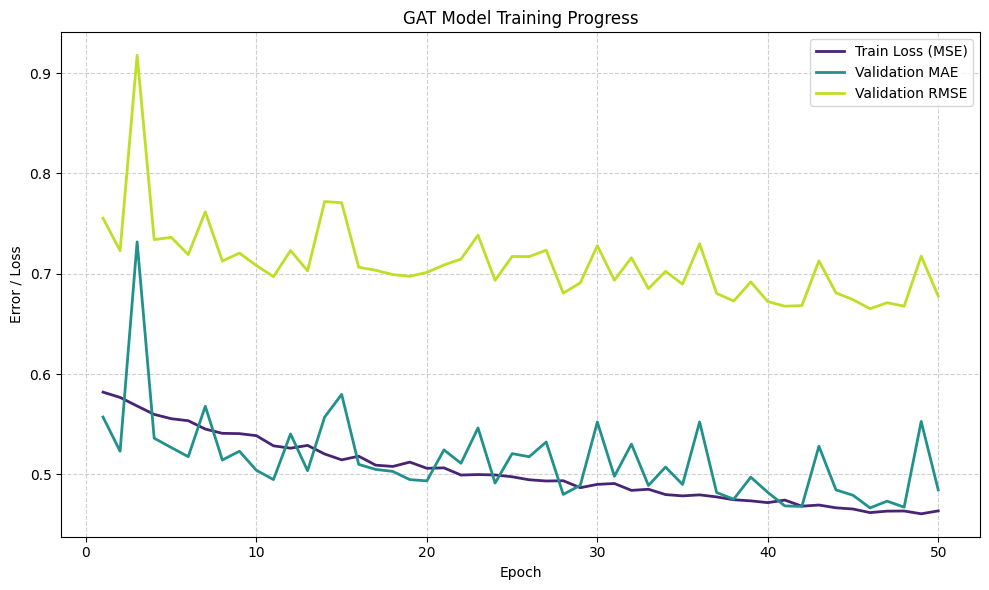

In [140]:
fig = plot_training_metrics(train_losses, val_maes, val_rmses)
fig.savefig("training_progress.png", dpi=300)


In [42]:
import matplotlib.pyplot as plt
import numpy as np

def plot_tmrt_scatter(graph, model, sample_size=10000, title="TMRT Prediction Scatter", color_by="true"):
    """
    Scatter plot of predicted vs. true TMRT, colored using viridis colormap.

    Args:
        graph: PyG Data object
        model: Trained GNN model
        sample_size: Max number of points to plot
        title: Plot title
        color_by: "true", "pred", or "residual" for coloring
    """
    model.eval()
    device = next(model.parameters()).device
    graph = graph.to(device)

    with torch.no_grad():
        pred = model(graph.x, graph.edge_index).cpu().numpy()

    true = graph.y.cpu().numpy()

    # Optionally sample
    if len(true) > sample_size:
        idx = np.random.choice(len(true), sample_size, replace=False)
        true = true[idx]
        pred = pred[idx]

    # Choose color mapping
    if color_by == "true":
        color_values = true
        color_label = "True TMRT"
    elif color_by == "pred":
        color_values = pred
        color_label = "Predicted TMRT"
    elif color_by == "residual":
        color_values = np.abs(pred - true)
        color_label = "Absolute Error"
    else:
        raise ValueError(f"Unknown color_by value: {color_by}")

    # Plot
    plt.figure(figsize=(6, 6))
    sc = plt.scatter(true, pred, c=color_values, cmap='viridis', alpha=0.6, s=5)
    plt.plot([true.min(), true.max()], [true.min(), true.max()], 'r--', label="Ideal (y = x)")
    plt.xlabel("True TMRT")
    plt.ylabel("Predicted TMRT")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.axis("square")
    plt.colorbar(sc, label=color_label)
    plt.tight_layout()
    plt.show()


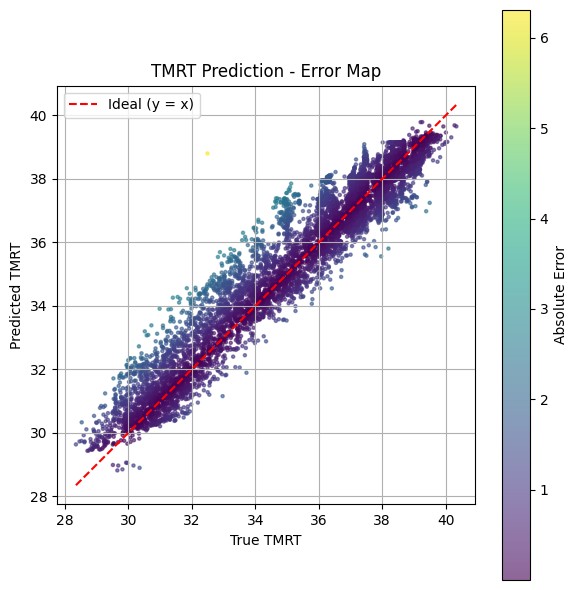

In [44]:
plot_tmrt_scatter(val_graphs[0], model, title="TMRT Prediction - Error Map", color_by="residual")


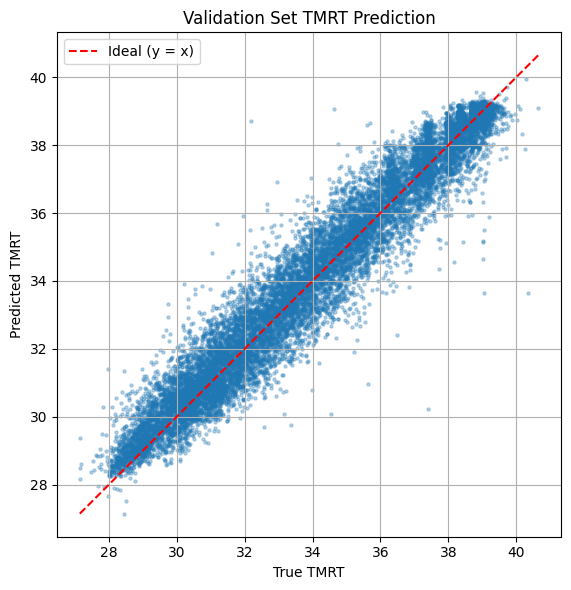

In [45]:
def plot_global_tmrt_scatter(graph_list, model, sample_size=20000, title="Global TMRT Prediction Scatter"):
    model.eval()
    device = next(model.parameters()).device

    all_true = []
    all_pred = []

    for graph in graph_list:
        graph = graph.to(device)
        with torch.no_grad():
            pred = model(graph.x, graph.edge_index).cpu().numpy()
        true = graph.y.cpu().numpy()

        all_true.append(true)
        all_pred.append(pred)

    # Flatten
    y_true = np.concatenate(all_true)
    y_pred = np.concatenate(all_pred)

    # Optionally sample
    if len(y_true) > sample_size:
        idx = np.random.choice(len(y_true), sample_size, replace=False)
        y_true = y_true[idx]
        y_pred = y_pred[idx]

    # Plot
    plt.figure(figsize=(6, 6))
    plt.scatter(y_true, y_pred, alpha=0.3, s=5)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', label="Ideal (y = x)")
    plt.xlabel("True TMRT")
    plt.ylabel("Predicted TMRT")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.axis("square")
    plt.tight_layout()
    plt.show()

plot_global_tmrt_scatter(val_graphs, model, title="Validation Set TMRT Prediction")

In [46]:
import matplotlib.pyplot as plt
import numpy as np

def plot_global_tmrt_scatter(graph_list, model, sample_size=20000,
                              title="Global TMRT Prediction Scatter", color_by="true"):
    """
    Scatter plot of predicted vs. true TMRT for multiple graphs,
    colored using a viridis colormap.

    Args:
        graph_list: list of PyG Data objects
        model: trained GNN model
        sample_size: max number of points to plot
        title: plot title
        color_by: "true", "pred", or "residual"
    """
    model.eval()
    device = next(model.parameters()).device

    all_true = []
    all_pred = []

    for graph in graph_list:
        graph = graph.to(device)
        with torch.no_grad():
            pred = model(graph.x, graph.edge_index).cpu().numpy()
        true = graph.y.cpu().numpy()

        all_true.append(true)
        all_pred.append(pred)

    # Flatten
    y_true = np.concatenate(all_true)
    y_pred = np.concatenate(all_pred)

    # Optionally sample
    if len(y_true) > sample_size:
        idx = np.random.choice(len(y_true), sample_size, replace=False)
        y_true = y_true[idx]
        y_pred = y_pred[idx]

    # Choose color mapping
    if color_by == "true":
        color_values = y_true
        color_label = "True TMRT"
    elif color_by == "pred":
        color_values = y_pred
        color_label = "Predicted TMRT"
    elif color_by == "residual":
        color_values = np.abs(y_pred - y_true)
        color_label = "Absolute Error"
    else:
        raise ValueError(f"Unknown color_by option: {color_by}")

    # Plot
    plt.figure(figsize=(6, 6))
    sc = plt.scatter(y_true, y_pred, c=color_values, cmap='viridis', alpha=0.5, s=5)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', label="Ideal (y = x)")
    plt.xlabel("True TMRT")
    plt.ylabel("Predicted TMRT")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.axis("square")
    plt.colorbar(sc, label=color_label)
    plt.tight_layout()
    plt.show()


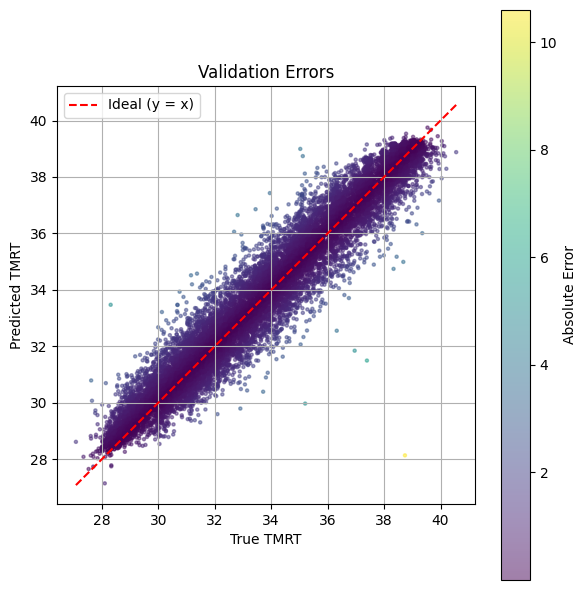

In [48]:
plot_global_tmrt_scatter(val_graphs, model, title="Validation Errors", color_by="residual")


In [ ]:
"""import torch
from torch_geometric.data import Data

def create_tile_graph(tile_path, clip_max=50):
    try:
        # Load input rasters
        dsm = rasterio.open(os.path.join(tile_path, "dsm.tif")).read(1).astype(np.float32)
        cdsm = rasterio.open(os.path.join(tile_path, "cdsm.tif")).read(1).astype(np.float32)
        svf = rasterio.open(os.path.join(tile_path, "predicted_svf.tif")).read(1).astype(np.float32)
        tmrt = rasterio.open(os.path.join(tile_path, "Tmrt_average.tif")).read(1).astype(np.float32)
        buildings = rasterio.open(os.path.join(tile_path, "buildings.tif")).read(1).astype(np.float32)
        buildings = np.clip(np.nan_to_num(buildings), 0, 1)

        # Replace NaNs and clip input data
        dsm = np.nan_to_num(np.clip(dsm, 0, clip_max))
        cdsm = np.nan_to_num(np.clip(cdsm, 0, clip_max))
        svf = np.clip(np.nan_to_num(svf), 0, 1)
        tmrt = np.nan_to_num(tmrt)

        # Normalize DSM and CDSM
        dsm = dsm / np.max(dsm) if np.max(dsm) > 0 else np.zeros_like(dsm)
        cdsm = cdsm / np.max(cdsm) if np.max(cdsm) > 0 else np.zeros_like(cdsm)

        # Compute contextual features
        density_map, mean_height_map = compute_contextual_features(dsm, buildings)

        # Get dimensions
        h, w = dsm.shape

        # Add spatial coordinates (normalized)
        xx, yy = np.meshgrid(np.arange(w), np.arange(h))
        x_coord = xx / w
        y_coord = yy / h

        # Stack all features into node feature matrix
        features = [
            dsm,
            cdsm,
            svf,
            x_coord,
            y_coord,
            buildings,
            density_map,
            mean_height_map
        ]
        x = np.stack(features, axis=-1).reshape(-1, len(features))  # shape: (N, 8)
        y = tmrt.flatten()

        # Build 4-neighbor grid edges
        edge_index = []
        for row in range(h):
            for col in range(w):
                idx = row * w + col
                if col < w - 1:
                    edge_index.append([idx, idx + 1])
                if row < h - 1:
                    edge_index.append([idx, idx + w])
        edge_index = np.array(edge_index).T  # shape: [2, num_edges]

        return Data(
            x=torch.tensor(x, dtype=torch.float),
            y=torch.tensor(y, dtype=torch.float),
            edge_index=torch.tensor(edge_index, dtype=torch.long)
        )

    except Exception as e:
        print(f"Error processing {tile_path}: {e}")
        return None
"""

Test GATConv (Graph Attention Network)

C:\Users\Ardo\AppData\Local\Temp\ipykernel_20968\2721085768.py:18: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap(colormap_name)


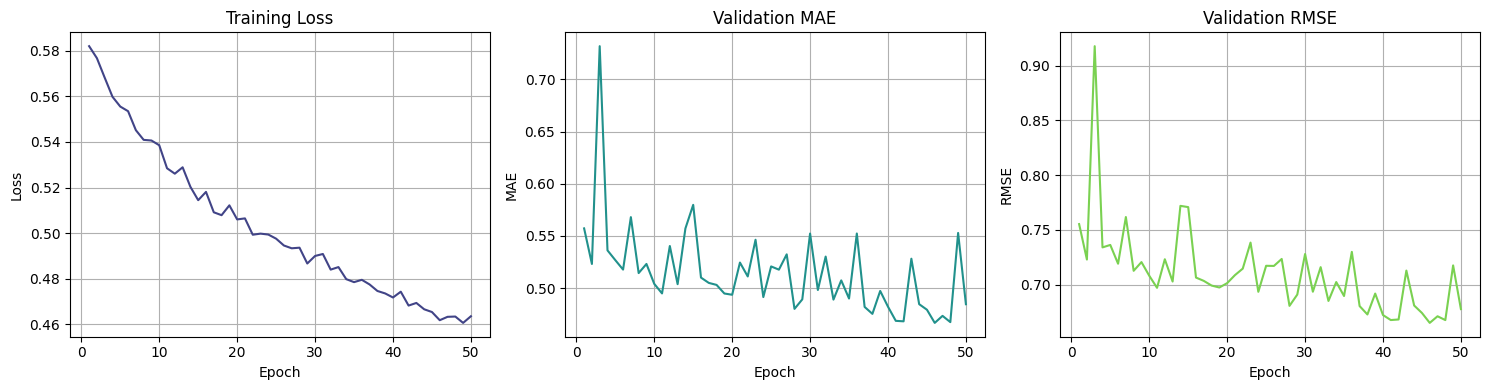

In [49]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.cm import get_cmap

def plot_training_metrics(train_losses, val_maes, val_rmses, colormap_name='viridis'):
    """
    Plot training loss, validation MAE, and RMSE using colors from a colormap.

    Args:
        train_losses: list of training losses (MSE)
        val_maes: list of validation MAEs
        val_rmses: list of validation RMSEs
        colormap_name: any valid matplotlib colormap name (default: 'viridis')
    """
    epochs = range(1, len(train_losses) + 1)

    # Get colormap and sample 3 evenly spaced colors
    cmap = get_cmap(colormap_name)
    colors = [cmap(i) for i in np.linspace(0.2, 0.8, 3)]

    plt.figure(figsize=(15, 4))

    # Loss
    plt.subplot(1, 3, 1)
    plt.plot(epochs, train_losses, label='Train Loss (MSE)', color=colors[0])
    plt.title("Training Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid(True)

    # MAE
    plt.subplot(1, 3, 2)
    plt.plot(epochs, val_maes, label='Validation MAE', color=colors[1])
    plt.title("Validation MAE")
    plt.xlabel("Epoch")
    plt.ylabel("MAE")
    plt.grid(True)

    # RMSE
    plt.subplot(1, 3, 3)
    plt.plot(epochs, val_rmses, label='Validation RMSE', color=colors[2])
    plt.title("Validation RMSE")
    plt.xlabel("Epoch")
    plt.ylabel("RMSE")
    plt.grid(True)

    plt.tight_layout()
    plt.show()

plot_training_metrics(train_losses, val_maes, val_rmses, colormap_name='viridis')


In [ ]:
"""import matplotlib.pyplot as plt
import numpy as np

def visualize_test_predictions(model, X_test, Y_test, n=5):
    preds = model.predict(X_test)

    for i in range(n):
        pred = preds[i].squeeze()
        true = Y_test[i].squeeze()
        error = np.abs(pred - true)

        # Metrics
        mae = np.mean(error)
        rmse = np.sqrt(np.mean((pred - true) ** 2))

        # Clamp the error color scale to a safe maximum (e.g., 0.2 or 0.3)
        error_vmax = np.clip(np.max(error), 0, 0.3)

        # Layout
        fig = plt.figure(figsize=(18, 6))
        gs = fig.add_gridspec(1, 4, width_ratios=[1, 1, 1, 0.05])

        fig.suptitle(f"Sample #{i} | MAE: {mae:.4f}, RMSE: {rmse:.4f}", fontsize=16, weight='bold')

        # True SVF
        ax0 = fig.add_subplot(gs[0])
        ax0.imshow(true, cmap='gray', vmin=0, vmax=1)
        ax0.set_title("Expected SVF")
        ax0.axis('off')

        # Predicted SVF
        ax1 = fig.add_subplot(gs[1])
        ax1.imshow(pred, cmap='gray', vmin=0, vmax=1)
        ax1.set_title("Predicted SVF")
        ax1.axis('off')

        # Error image (less scary)
        ax2 = fig.add_subplot(gs[2])
        im2 = ax2.imshow(error, cmap='hot', vmin=0, vmax=error_vmax)
        ax2.set_title("Absolute Error")
        ax2.axis('off')

        # Colorbar
        cax = fig.add_subplot(gs[3])
        cbar = fig.colorbar(im2, cax=cax)
        cbar.set_label("Error Magnitude", rotation=270, labelpad=12)

        plt.tight_layout()
        plt.show()"""

In [ ]:
"""import matplotlib.pyplot as plt
import numpy as np
import torch
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def visualize_validation_predictions(val_loader, model, max_plots=5, tile_size=(128, 128)):
    model.eval()
    device = next(model.parameters()).device
    shown = 0

    with torch.no_grad():
        for batch in val_loader:
            batch = batch.to(device)
            pred = model(batch.x, batch.edge_index).cpu().numpy()
            true = batch.y.cpu().numpy()

            h, w = tile_size
            pred_img = pred.reshape(h, w)
            true_img = true.reshape(h, w)
            error_img = np.abs(pred_img - true_img)

            # Metrics
            mask = ~np.isnan(true) & ~np.isnan(pred)
            mae = mean_absolute_error(true[mask], pred[mask])
            rmse = np.sqrt(mean_squared_error(true[mask], pred[mask]))
            r2 = r2_score(true[mask], pred[mask])

            # Colormap range
            vmin, vmax = 20, 50  # for Tmrt in °C

            # Plot
            fig, axs = plt.subplots(1, 3, figsize=(15, 5))
            fig.suptitle(f"MAE: {mae:.2f} | RMSE: {rmse:.2f} | R²: {r2:.2f}", fontsize=12)

            # Ground truth with Spectral_r colormap
            axs[0].imshow(true_img, cmap='Spectral_r', vmin=vmin, vmax=vmax)
            axs[0].set_title("Calculated Tmrt °C")
            axs[0].axis('off')

            # Prediction with Spectral_r colormap
            axs[1].imshow(pred_img, cmap='Spectral_r', vmin=vmin, vmax=vmax)
            axs[1].set_title("Predicted Tmrt °C")
            axs[1].axis('off')

            # Error image with hot colormap
            im = axs[2].imshow(error_img, cmap='hot')
            axs[2].set_title("Absolute Error")
            axs[2].axis('off')

            # Add colorbar for error image
            cbar = fig.colorbar(im, ax=axs[2], fraction=0.046, pad=0.04)
            cbar.set_label('Error (°C)', rotation=270, labelpad=12)

            plt.tight_layout()
            plt.show()

            shown += 1
            if shown >= max_plots:
                break
"""

In [103]:
import os
import matplotlib.pyplot as plt
import numpy as np
import torch
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def visualize_validation_predictions(val_loader, model, max_plots=5, tile_size=(128, 128), save_dir=None, show=True):
    """
    Visualize and optionally save TMRT prediction results for validation graphs.

    Args:
        val_loader: DataLoader of PyG graphs
        model: trained PyTorch model
        max_plots: number of plots to generate
        tile_size: tuple (H, W)
        save_dir: path to folder where to save images (if None, don't save)
        show: if True, also show the plots with plt.show()
    """
    model.eval()
    device = next(model.parameters()).device
    shown = 0

    if save_dir:
        os.makedirs(save_dir, exist_ok=True)

    with torch.no_grad():
        for batch in val_loader:
            batch = batch.to(device)
            pred = model(batch.x, batch.edge_index).cpu().numpy()
            true = batch.y.cpu().numpy()

            h, w = tile_size
            pred_img = pred.reshape(h, w)
            true_img = true.reshape(h, w)
            error_img = np.abs(pred_img - true_img)

            # Metrics
            mask = ~np.isnan(true) & ~np.isnan(pred)
            mae = mean_absolute_error(true[mask], pred[mask])
            rmse = np.sqrt(mean_squared_error(true[mask], pred[mask]))
            r2 = r2_score(true[mask], pred[mask])

            # Tile ID
            tile_id = getattr(batch, 'tile_id', f"Tile_{shown}")

            # Colormap range
            vmin, vmax = 20, 50

            # Plot
            fig, axs = plt.subplots(1, 3, figsize=(15, 5), constrained_layout=True)
            fig.suptitle(f"MAE: {mae:.2f} | RMSE: {rmse:.2f} | R²: {r2:.2f}",
                         fontsize=14, y=1.05)

            # Ground Truth
            im0 = axs[0].imshow(true_img, cmap='Spectral_r', vmin=vmin, vmax=vmax)
            axs[0].set_title("Calculated Tmrt (°C)", fontsize=11, pad=12)
            axs[0].axis('off')

            # Prediction
            im1 = axs[1].imshow(pred_img, cmap='Spectral_r', vmin=vmin, vmax=vmax)
            axs[1].set_title("Predicted Tmrt (°C)", fontsize=11, pad=12)
            axs[1].axis('off')
            cbar1 = fig.colorbar(im1, ax=axs[1], fraction=0.05, pad=0.04)
            cbar1.set_label('TmrT (°C)', rotation=270, labelpad=12)

            # Error
            im2 = axs[2].imshow(error_img, cmap='hot')
            axs[2].set_title("Absolute Error (°C)", fontsize=11, pad=12)
            axs[2].axis('off')
            cbar2 = fig.colorbar(im2, ax=axs[2], fraction=0.05, pad=0.04)
            cbar2.set_label('Error (°C)', rotation=270, labelpad=12)

            # Save to file
            if save_dir:
                filename = f"{tile_id}.png"
                save_path = os.path.join(save_dir, filename)
                plt.savefig(save_path, dpi=150)
                print(f"Saved: {save_path}")

            if show:
                plt.show()
            else:
                plt.close()

            shown += 1
            if shown >= max_plots:
                break


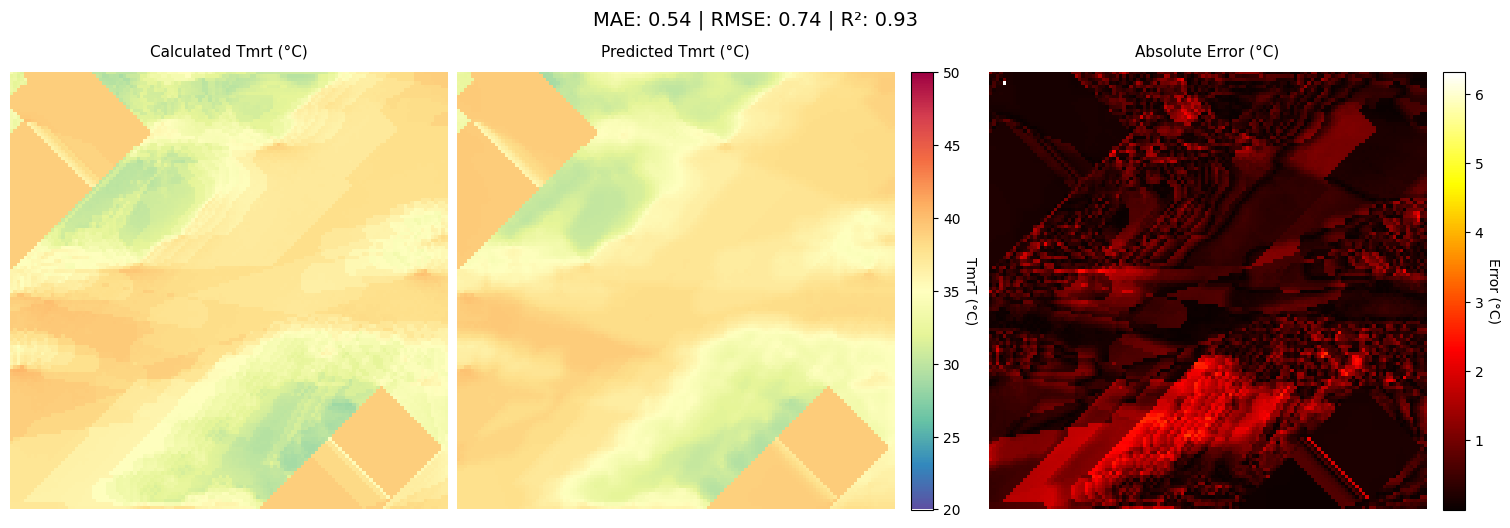

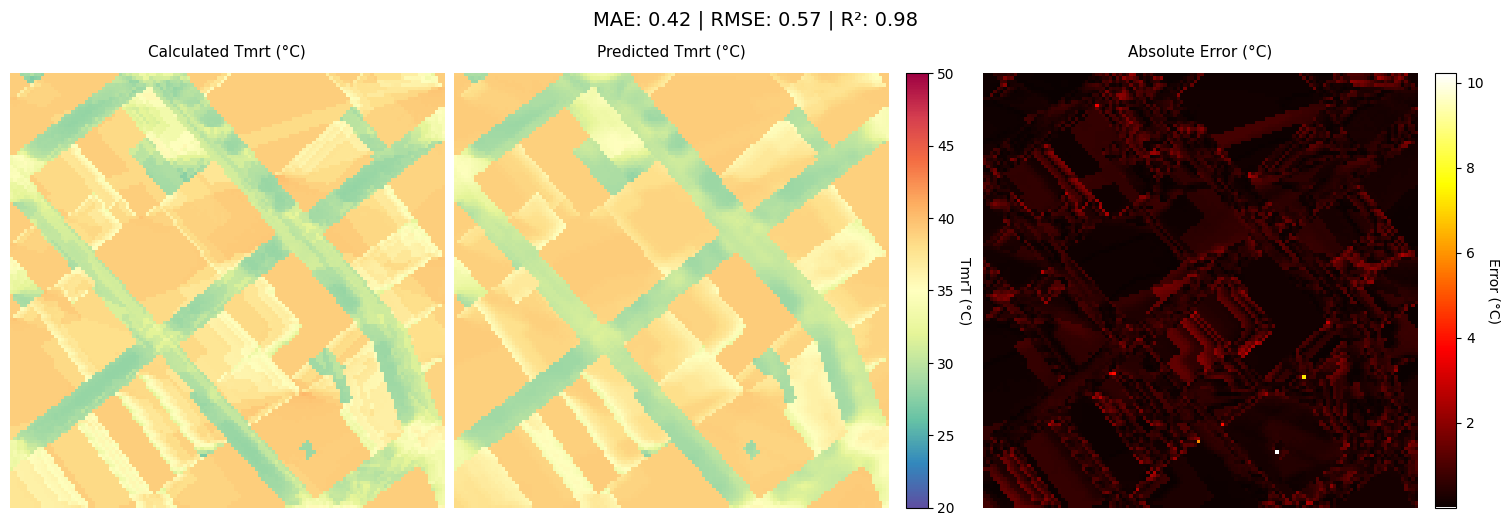

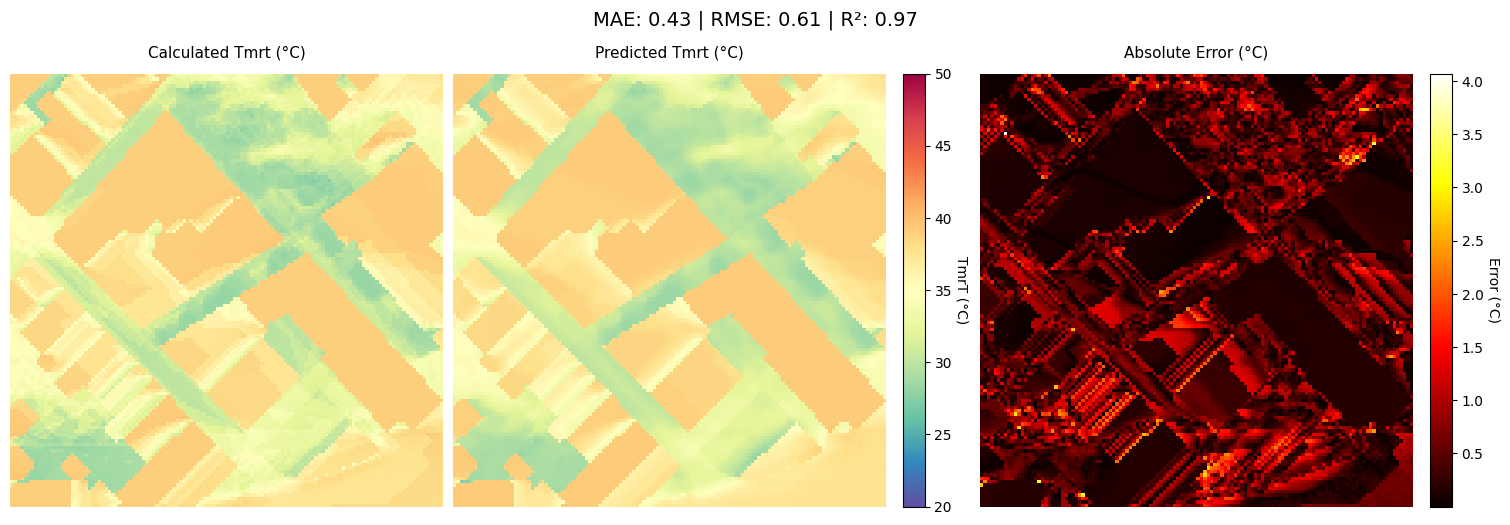

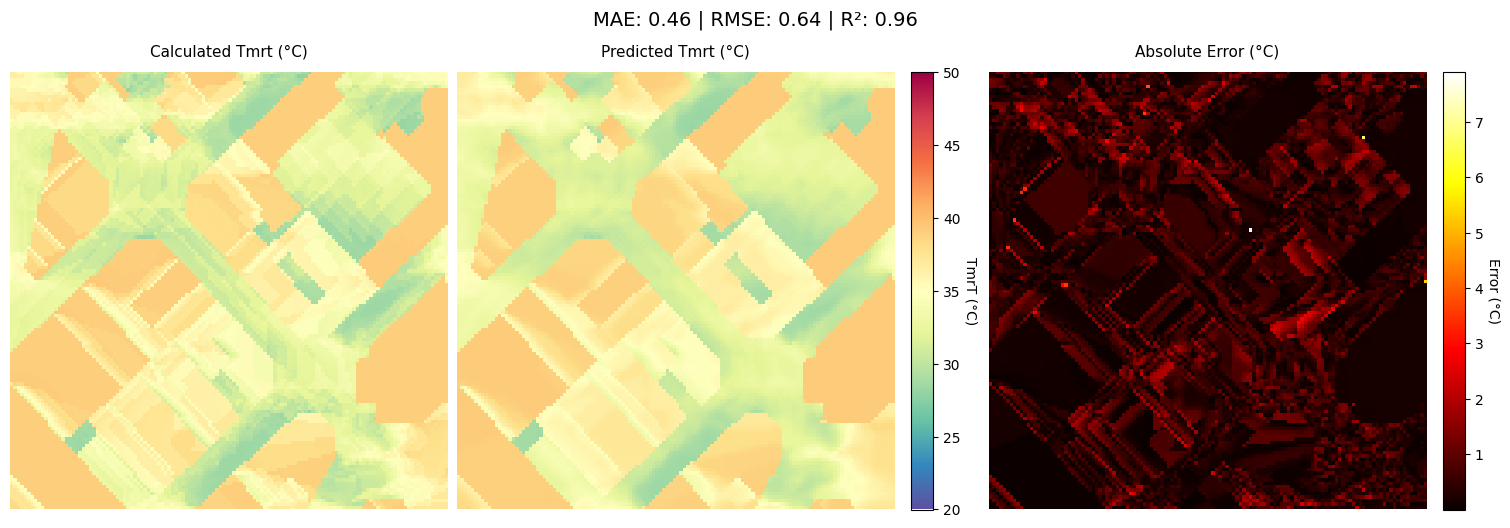

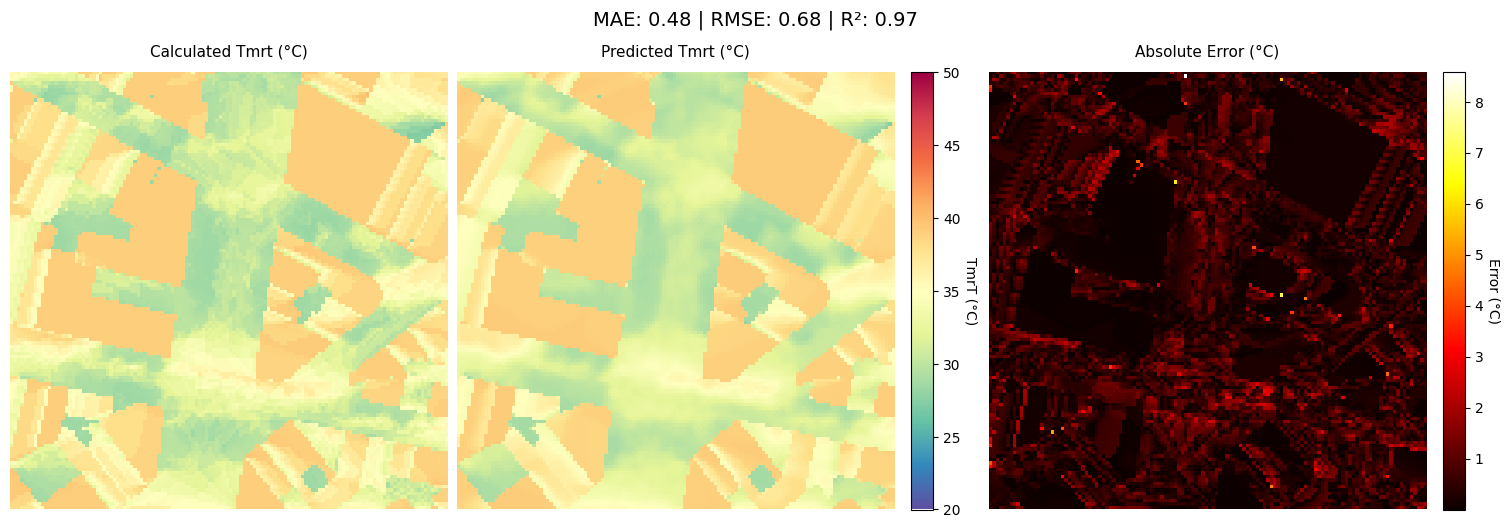

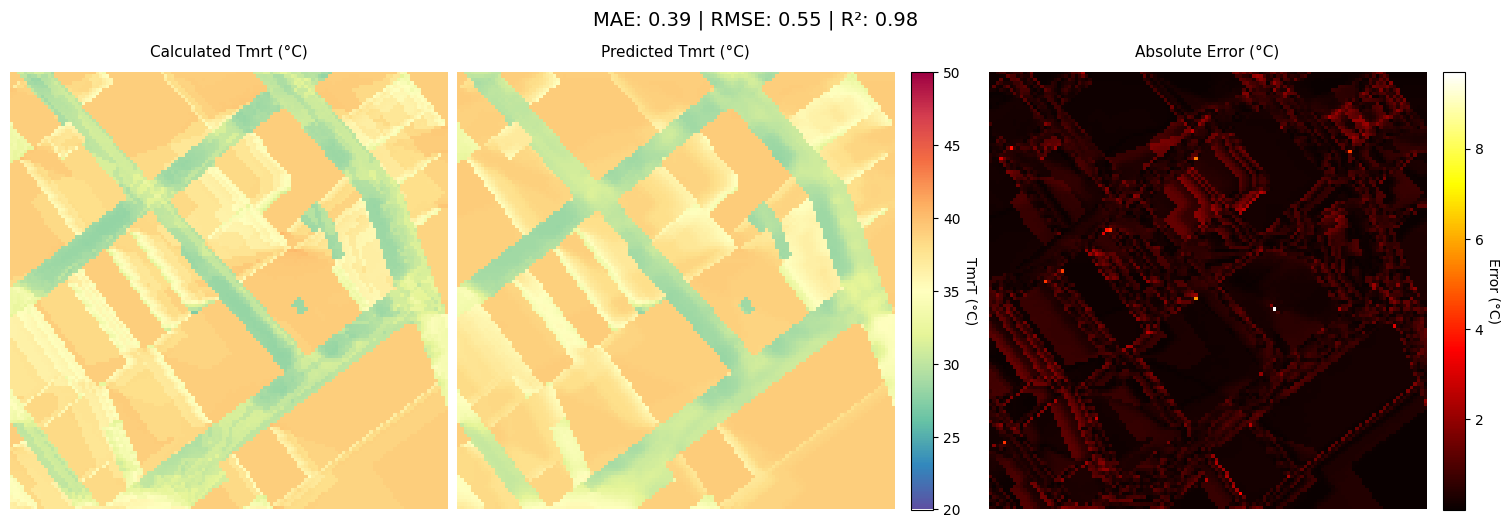

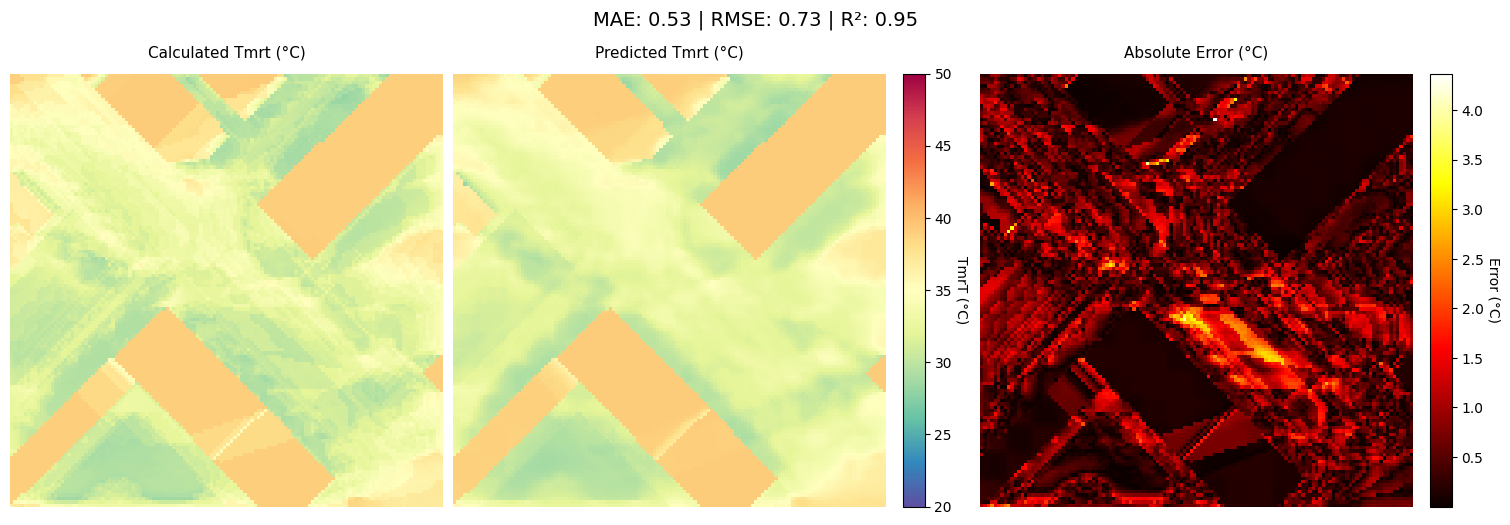

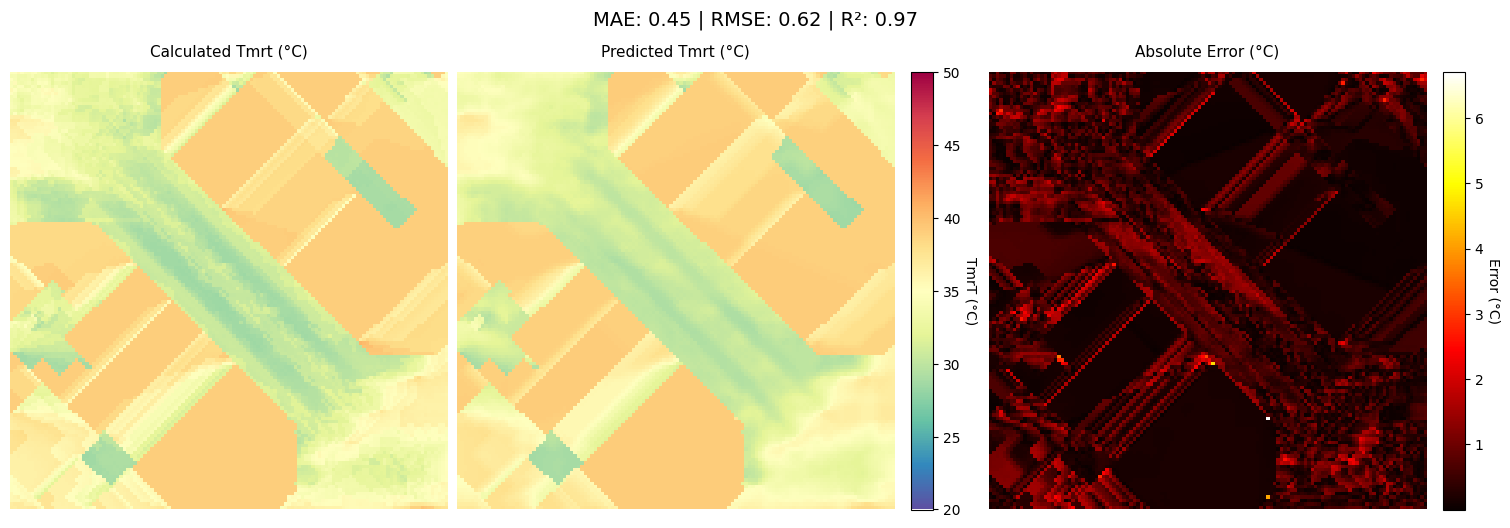

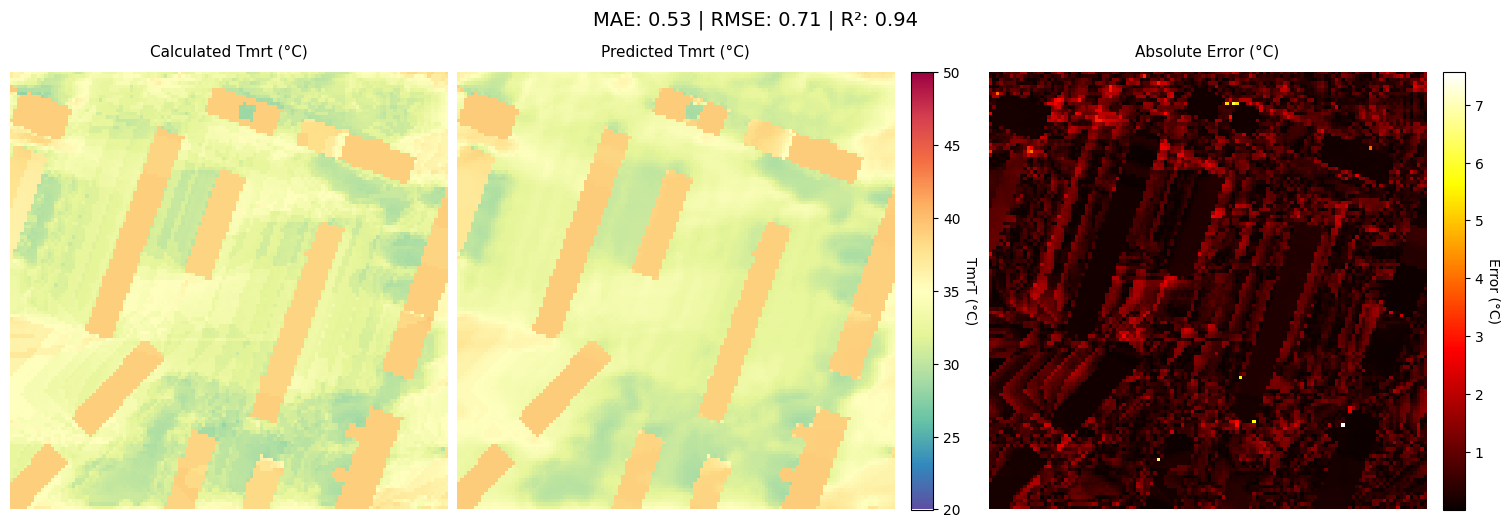

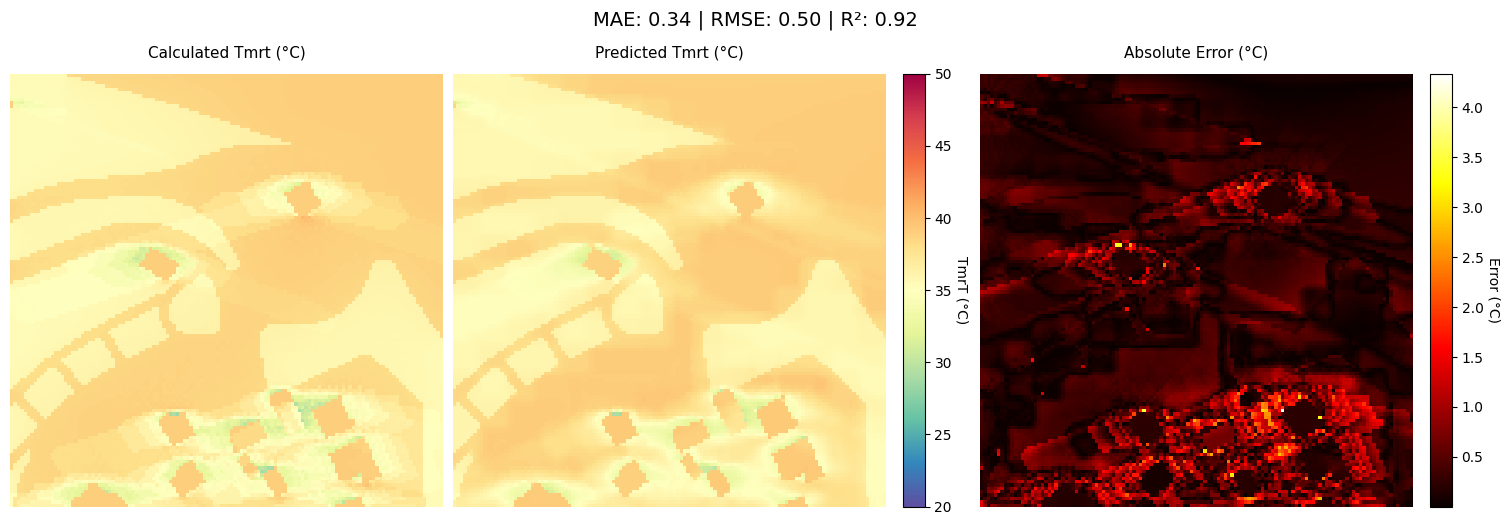

In [104]:
visualize_validation_predictions(val_loader, model, max_plots=10)

In [77]:
visualize_validation_predictions(
    val_loader=val_loader,
    model=model,
    max_plots=10,
    save_dir = r"C:\Users\Ardo\Desktop\presentation_material",
    show=False  # Set to True if you also want to see the plots interactively
)


Saved: C:\Users\Ardo\Desktop\presentation_material\Tile_0.png
Saved: C:\Users\Ardo\Desktop\presentation_material\Tile_1.png
Saved: C:\Users\Ardo\Desktop\presentation_material\Tile_2.png
Saved: C:\Users\Ardo\Desktop\presentation_material\Tile_3.png
Saved: C:\Users\Ardo\Desktop\presentation_material\Tile_4.png
Saved: C:\Users\Ardo\Desktop\presentation_material\Tile_5.png
Saved: C:\Users\Ardo\Desktop\presentation_material\Tile_6.png
Saved: C:\Users\Ardo\Desktop\presentation_material\Tile_7.png
Saved: C:\Users\Ardo\Desktop\presentation_material\Tile_8.png
Saved: C:\Users\Ardo\Desktop\presentation_material\Tile_9.png


In [53]:
import os
import torch

# Define target folder
model_dir = r"C:\Users\Ardo\Desktop\trained_models"
os.makedirs(model_dir, exist_ok=True)

# Define file paths
pth_path = os.path.join(model_dir, "gnn_tmrt_model_new.pth")  # weights only
pt_path = os.path.join(model_dir, "gnn_tmrt_model_new.pt")    # full model

# Save weights (.pth)
torch.save(model.state_dict(), pth_path)

# Save full model (.pt)
torch.save(model, pt_path)

print(f"Saved model weights to: {pth_path}")
print(f"Saved full model to: {pt_path}")



Saved model weights to: C:\Users\Ardo\Desktop\trained_models\gnn_tmrt_model_new.pth
Saved full model to: C:\Users\Ardo\Desktop\trained_models\gnn_tmrt_model_new.pt


In [ ]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
import rasterio
from rasterio.transform import from_origin

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
model.eval()

# Set root folder with all tile subfolders
root_folder = r"C:\Users\Ardo\Desktop\patch_combined_red"

def save_tmrt_tif(pred, tile_path):
    dsm_path = os.path.join(tile_path, "dsm.tif")
    with rasterio.open(dsm_path) as src:
        profile = src.profile
        transform = src.transform
        height, width = src.shape

    pred_img = pred.reshape(height, width)

    output_path = os.path.join(tile_path, "predicted_tmrt.tif")
    profile.update(dtype=rasterio.float32, count=1)

    with rasterio.open(output_path, 'w', **profile) as dst:
        dst.write(pred_img.astype(np.float32), 1)

def save_tmrt_png(pred, tile_path):
    dsm_path = os.path.join(tile_path, "dsm.tif")
    with rasterio.open(dsm_path) as src:
        height, width = src.shape

    pred_img = pred.reshape(height, width)

    # Load building mask
    buildings_path = os.path.join(tile_path, "buildings.tif")
    if os.path.exists(buildings_path):
        with rasterio.open(buildings_path) as bld:
            buildings = bld.read(1).astype(np.uint8)
        # Mask out buildings (where buildings == 0)
        pred_img = np.where(buildings == 0, np.nan, pred_img)
    else:
        print(f" No buildings.tif found in {tile_path}, skipping mask.")

    # Plot
    plt.figure(figsize=(4, 4))
    plt.imshow(pred_img, cmap='Spectral_r', vmin=10, vmax=50)
    plt.axis('off')
    plt.tight_layout()

    output_path = os.path.join(tile_path, "predicted_tmrt.png")
    plt.savefig(output_path, bbox_inches='tight', pad_inches=0, dpi=300)
    plt.close()

# Loop over tiles and predict
with torch.no_grad():
    for tile in os.listdir(root_folder):
        tile_path = os.path.join(root_folder, tile)
        if not os.path.isdir(tile_path):
            continue

        graph = create_tile_graph(tile_path)
        if graph is None:
            continue

        graph = graph.to(device)
        pred = model(graph.x, graph.edge_index).cpu().numpy()

        save_tmrt_tif(pred, tile_path)
        save_tmrt_png(pred, tile_path)

print(" Done! All Tmrt predictions saved.")
